# BERT

In [4]:
target_dir = '../backend/chatbot/'

In [5]:
from transformers import TrainerCallback

class AlignedLossCallback(TrainerCallback):
    def __init__(self):
        self.train_steps = []
        self.eval_steps = []
        self.train_losses = []
        self.eval_losses = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        logs = logs or {}
        # Log training loss
        if "loss" in logs:
            self.train_steps.append(state.global_step)
            self.train_losses.append(logs["loss"])
        # Log evaluation loss
        if "eval_loss" in logs:
            self.eval_steps.append(state.global_step)
            self.eval_losses.append(logs["eval_loss"])

aligned_loss_callback = AlignedLossCallback()

In [6]:
from datasets import Dataset
import pandas as pd
from transformers import BertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
from transformers import DataCollatorWithPadding
import torch

# Load dataset
# datafile = '../data/Bitext.csv'
datafile = './data/bert_input.csv'
df = pd.read_csv(datafile)
df = df[['instruction', 'intent']]
print(len(df))

# Convert to Hugging Face dataset
intent_dataset = Dataset.from_pandas(df)

# get device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Initialize tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize_function(example):
    return tokenizer(example['instruction'], padding='max_length', truncation=True, max_length=128)

# Apply tokenization to the dataset
intent_dataset = intent_dataset.map(tokenize_function, remove_columns=["instruction"])

# Map 'intent' to numerical labels
intent_labels = {intent: idx for idx, intent in enumerate(df['intent'].unique())}
intent_dataset = intent_dataset.map(lambda x: {'labels': intent_labels[x['intent']]})

# Number of intents
num_intents = len(df['intent'].unique())
print(num_intents)

# Load DistilBERT model for sequence classification
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=num_intents)

# Data collator (use for sequence classification, handles padding)
data_collator = DataCollatorWithPadding(tokenizer, padding='max_length', max_length=128)

# Define training arguments
training_args = TrainingArguments(
    output_dir='./intent_model',
    save_strategy="steps",
    save_steps=500,  # Save model every 500 steps
    logging_dir='./logs',
    logging_steps=10,  # Log training loss every 500 steps
    evaluation_strategy="steps",  # Evaluate every 500 steps
    eval_steps=10,  # Perform evaluation every 500 steps
    save_total_limit=2,
    num_train_epochs=50,
    per_device_train_batch_size=8,
    disable_tqdm=False,
    load_best_model_at_end=True,
)

# split dataset
# Initial train/test split
train_val_split = intent_dataset.train_test_split(test_size=0.1)
intent_dataset_train = train_val_split['train']
intent_dataset_val = train_val_split['test']

# Further split the training set into train and test sets
train_test_split = intent_dataset_train.train_test_split(test_size=0.1)
intent_dataset_train = train_test_split['train']
intent_dataset_test = train_test_split['test']

# Trainer setup
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=intent_dataset_train,
    eval_dataset=intent_dataset_val,
    data_collator=data_collator,
    callbacks=[aligned_loss_callback]
)

# Train the model with tqdm progress bar
trainer.train()
tokenizer.save_pretrained('./intent_model')

104
Using device: cuda


Map: 100%|██████████| 104/104 [00:00<00:00, 26285.48 examples/s]


7


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/harshit/IITH/Sem7/CyberSecurityAndAI/project/cyber_security_project/venv/lib/python3.12/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
                                       
  0%|          | 0/550 [00:04<?, ?it/s]        

{'loss': 1.8382, 'grad_norm': 3.0462381839752197, 'learning_rate': 4.909090909090909e-05, 'epoch': 0.91}



                                       
                                             

  0%|          | 0/550 [00:04<?, ?it/s]



{'eval_loss': 1.733505368232727, 'eval_runtime': 0.0229, 'eval_samples_per_second': 480.172, 'eval_steps_per_second': 87.304, 'epoch': 0.91}


                                       
  0%|          | 0/550 [00:04<?, ?it/s]         

{'loss': 1.4991, 'grad_norm': 3.6689486503601074, 'learning_rate': 4.8181818181818186e-05, 'epoch': 1.82}



                                       
                                             

  0%|          | 0/550 [00:04<?, ?it/s]



{'eval_loss': 1.398667812347412, 'eval_runtime': 0.0209, 'eval_samples_per_second': 526.598, 'eval_steps_per_second': 95.745, 'epoch': 1.82}


                                       
  0%|          | 0/550 [00:05<?, ?it/s]         

{'loss': 1.08, 'grad_norm': 5.072202682495117, 'learning_rate': 4.7272727272727275e-05, 'epoch': 2.73}



                                       
                                             

  0%|          | 0/550 [00:05<?, ?it/s]



{'eval_loss': 1.2354590892791748, 'eval_runtime': 0.0205, 'eval_samples_per_second': 536.843, 'eval_steps_per_second': 97.608, 'epoch': 2.73}


                                       
  0%|          | 0/550 [00:06<?, ?it/s]         

{'loss': 0.7504, 'grad_norm': 3.0624804496765137, 'learning_rate': 4.636363636363636e-05, 'epoch': 3.64}



                                       
                                             

  0%|          | 0/550 [00:06<?, ?it/s]



{'eval_loss': 0.963223397731781, 'eval_runtime': 0.0228, 'eval_samples_per_second': 483.377, 'eval_steps_per_second': 87.887, 'epoch': 3.64}


                                       
  0%|          | 0/550 [00:06<?, ?it/s]         

{'loss': 0.392, 'grad_norm': 3.267622709274292, 'learning_rate': 4.545454545454546e-05, 'epoch': 4.55}



                                       
                                             

  0%|          | 0/550 [00:06<?, ?it/s]



{'eval_loss': 0.5634075999259949, 'eval_runtime': 0.0202, 'eval_samples_per_second': 544.348, 'eval_steps_per_second': 98.972, 'epoch': 4.55}


                                       
  0%|          | 0/550 [00:07<?, ?it/s]         

{'loss': 0.3257, 'grad_norm': 1.7141941785812378, 'learning_rate': 4.454545454545455e-05, 'epoch': 5.45}



                                       
                                             

  0%|          | 0/550 [00:07<?, ?it/s]



{'eval_loss': 0.39811667799949646, 'eval_runtime': 0.0205, 'eval_samples_per_second': 537.13, 'eval_steps_per_second': 97.66, 'epoch': 5.45}


                                       
  0%|          | 0/550 [00:08<?, ?it/s]         

{'loss': 0.1763, 'grad_norm': 0.6844483613967896, 'learning_rate': 4.3636363636363636e-05, 'epoch': 6.36}



                                       
                                             

  0%|          | 0/550 [00:08<?, ?it/s]



{'eval_loss': 0.32101747393608093, 'eval_runtime': 0.0213, 'eval_samples_per_second': 516.818, 'eval_steps_per_second': 93.967, 'epoch': 6.36}


                                       
  0%|          | 0/550 [00:08<?, ?it/s]         

{'loss': 0.0829, 'grad_norm': 0.5801619291305542, 'learning_rate': 4.2727272727272724e-05, 'epoch': 7.27}



                                       
                                             

  0%|          | 0/550 [00:08<?, ?it/s]



{'eval_loss': 0.30745482444763184, 'eval_runtime': 0.0206, 'eval_samples_per_second': 535.174, 'eval_steps_per_second': 97.304, 'epoch': 7.27}


                                       
  0%|          | 0/550 [00:09<?, ?it/s]         

{'loss': 0.0676, 'grad_norm': 0.2315966933965683, 'learning_rate': 4.181818181818182e-05, 'epoch': 8.18}



                                       
                                             

  0%|          | 0/550 [00:09<?, ?it/s]



{'eval_loss': 0.18147777020931244, 'eval_runtime': 0.0204, 'eval_samples_per_second': 539.126, 'eval_steps_per_second': 98.023, 'epoch': 8.18}


                                       
  0%|          | 0/550 [00:10<?, ?it/s]         

{'loss': 0.0466, 'grad_norm': 0.3035655617713928, 'learning_rate': 4.0909090909090915e-05, 'epoch': 9.09}



                                       
                                              

  0%|          | 0/550 [00:10<?, ?it/s]



{'eval_loss': 0.1817246675491333, 'eval_runtime': 0.0228, 'eval_samples_per_second': 481.993, 'eval_steps_per_second': 87.635, 'epoch': 9.09}


                                       
  0%|          | 0/550 [00:11<?, ?it/s]          

{'loss': 0.0316, 'grad_norm': 0.20526602864265442, 'learning_rate': 4e-05, 'epoch': 10.0}



                                       
                                              

  0%|          | 0/550 [00:11<?, ?it/s]



{'eval_loss': 0.1356523185968399, 'eval_runtime': 0.0206, 'eval_samples_per_second': 533.133, 'eval_steps_per_second': 96.933, 'epoch': 10.0}


                                       
  0%|          | 0/550 [00:11<?, ?it/s]          

{'loss': 0.0257, 'grad_norm': 0.16359613835811615, 'learning_rate': 3.909090909090909e-05, 'epoch': 10.91}



                                       
                                              

  0%|          | 0/550 [00:11<?, ?it/s]



{'eval_loss': 0.10992706567049026, 'eval_runtime': 0.022, 'eval_samples_per_second': 500.231, 'eval_steps_per_second': 90.951, 'epoch': 10.91}


                                       
  0%|          | 0/550 [00:12<?, ?it/s]          

{'loss': 0.0199, 'grad_norm': 0.6832999587059021, 'learning_rate': 3.818181818181819e-05, 'epoch': 11.82}



                                       
                                              

  0%|          | 0/550 [00:12<?, ?it/s]



{'eval_loss': 0.10704027861356735, 'eval_runtime': 0.0211, 'eval_samples_per_second': 521.733, 'eval_steps_per_second': 94.86, 'epoch': 11.82}


                                       
  0%|          | 0/550 [00:13<?, ?it/s]          

{'loss': 0.0154, 'grad_norm': 0.12545230984687805, 'learning_rate': 3.7272727272727276e-05, 'epoch': 12.73}



                                       
                                              

  0%|          | 0/550 [00:13<?, ?it/s]



{'eval_loss': 0.10844938457012177, 'eval_runtime': 0.0233, 'eval_samples_per_second': 472.854, 'eval_steps_per_second': 85.974, 'epoch': 12.73}


                                       
  0%|          | 0/550 [00:13<?, ?it/s]          

{'loss': 0.0129, 'grad_norm': 0.09046117216348648, 'learning_rate': 3.6363636363636364e-05, 'epoch': 13.64}



                                       
                                              

  0%|          | 0/550 [00:13<?, ?it/s]



{'eval_loss': 0.10034282505512238, 'eval_runtime': 0.0218, 'eval_samples_per_second': 504.614, 'eval_steps_per_second': 91.748, 'epoch': 13.64}


                                       
  0%|          | 0/550 [00:14<?, ?it/s]          

{'loss': 0.0097, 'grad_norm': 0.11815277487039566, 'learning_rate': 3.545454545454546e-05, 'epoch': 14.55}



                                       
                                              

  0%|          | 0/550 [00:14<?, ?it/s]



{'eval_loss': 0.09579344093799591, 'eval_runtime': 0.0203, 'eval_samples_per_second': 540.915, 'eval_steps_per_second': 98.348, 'epoch': 14.55}


                                       
  0%|          | 0/550 [00:15<?, ?it/s]          

{'loss': 0.0114, 'grad_norm': 0.0862511470913887, 'learning_rate': 3.454545454545455e-05, 'epoch': 15.45}



                                       
                                              

  0%|          | 0/550 [00:15<?, ?it/s]



{'eval_loss': 0.07634881883859634, 'eval_runtime': 0.0213, 'eval_samples_per_second': 517.583, 'eval_steps_per_second': 94.106, 'epoch': 15.45}


                                       
  0%|          | 0/550 [00:15<?, ?it/s]          

{'loss': 0.0094, 'grad_norm': 0.05837612971663475, 'learning_rate': 3.3636363636363636e-05, 'epoch': 16.36}



                                       
                                              

  0%|          | 0/550 [00:15<?, ?it/s]



{'eval_loss': 0.07618245482444763, 'eval_runtime': 0.0206, 'eval_samples_per_second': 534.672, 'eval_steps_per_second': 97.213, 'epoch': 16.36}


                                       
  0%|          | 0/550 [00:16<?, ?it/s]          

{'loss': 0.0084, 'grad_norm': 0.06925254315137863, 'learning_rate': 3.272727272727273e-05, 'epoch': 17.27}



                                       
                                              

  0%|          | 0/550 [00:16<?, ?it/s]



{'eval_loss': 0.07523252069950104, 'eval_runtime': 0.0217, 'eval_samples_per_second': 506.636, 'eval_steps_per_second': 92.116, 'epoch': 17.27}


                                       
  0%|          | 0/550 [00:17<?, ?it/s]          

{'loss': 0.0107, 'grad_norm': 0.05320402607321739, 'learning_rate': 3.181818181818182e-05, 'epoch': 18.18}



                                       
                                              

  0%|          | 0/550 [00:17<?, ?it/s]



{'eval_loss': 0.06420987099409103, 'eval_runtime': 0.0214, 'eval_samples_per_second': 514.18, 'eval_steps_per_second': 93.487, 'epoch': 18.18}


                                       
  0%|          | 0/550 [00:17<?, ?it/s]          

{'loss': 0.0062, 'grad_norm': 0.060485851019620895, 'learning_rate': 3.090909090909091e-05, 'epoch': 19.09}



                                       
                                              

  0%|          | 0/550 [00:17<?, ?it/s]



{'eval_loss': 0.04963890463113785, 'eval_runtime': 0.0216, 'eval_samples_per_second': 508.922, 'eval_steps_per_second': 92.531, 'epoch': 19.09}


                                       
  0%|          | 0/550 [00:18<?, ?it/s]          

{'loss': 0.0069, 'grad_norm': 0.05226839706301689, 'learning_rate': 3e-05, 'epoch': 20.0}



                                       
                                              

  0%|          | 0/550 [00:18<?, ?it/s]



{'eval_loss': 0.05284247547388077, 'eval_runtime': 0.0206, 'eval_samples_per_second': 534.579, 'eval_steps_per_second': 97.196, 'epoch': 20.0}


                                       
  0%|          | 0/550 [00:19<?, ?it/s]          

{'loss': 0.0066, 'grad_norm': 0.0846463069319725, 'learning_rate': 2.909090909090909e-05, 'epoch': 20.91}



                                       
                                              

  0%|          | 0/550 [00:19<?, ?it/s]



{'eval_loss': 0.05466644838452339, 'eval_runtime': 0.0221, 'eval_samples_per_second': 497.491, 'eval_steps_per_second': 90.453, 'epoch': 20.91}


                                       
  0%|          | 0/550 [00:20<?, ?it/s]          

{'loss': 0.006, 'grad_norm': 0.08177467435598373, 'learning_rate': 2.818181818181818e-05, 'epoch': 21.82}



                                       
                                              

  0%|          | 0/550 [00:20<?, ?it/s]



{'eval_loss': 0.0531911626458168, 'eval_runtime': 0.021, 'eval_samples_per_second': 522.761, 'eval_steps_per_second': 95.048, 'epoch': 21.82}


                                       
  0%|          | 0/550 [00:20<?, ?it/s]          

{'loss': 0.0055, 'grad_norm': 0.04494163393974304, 'learning_rate': 2.7272727272727273e-05, 'epoch': 22.73}



                                       
                                              

  0%|          | 0/550 [00:20<?, ?it/s]



{'eval_loss': 0.04673478752374649, 'eval_runtime': 0.0236, 'eval_samples_per_second': 466.086, 'eval_steps_per_second': 84.743, 'epoch': 22.73}


                                       
  0%|          | 0/550 [00:21<?, ?it/s]          

{'loss': 0.0041, 'grad_norm': 0.04599730670452118, 'learning_rate': 2.636363636363636e-05, 'epoch': 23.64}



                                       
                                              

  0%|          | 0/550 [00:21<?, ?it/s]



{'eval_loss': 0.04572063684463501, 'eval_runtime': 0.0213, 'eval_samples_per_second': 516.974, 'eval_steps_per_second': 93.995, 'epoch': 23.64}


                                       
  0%|          | 0/550 [00:22<?, ?it/s]          

{'loss': 0.0063, 'grad_norm': 0.04303509742021561, 'learning_rate': 2.5454545454545454e-05, 'epoch': 24.55}



                                       
                                              

  0%|          | 0/550 [00:22<?, ?it/s]



{'eval_loss': 0.048958513885736465, 'eval_runtime': 0.0207, 'eval_samples_per_second': 532.082, 'eval_steps_per_second': 96.742, 'epoch': 24.55}


                                       
  0%|          | 0/550 [00:22<?, ?it/s]          

{'loss': 0.0049, 'grad_norm': 0.1708202362060547, 'learning_rate': 2.4545454545454545e-05, 'epoch': 25.45}



                                       
                                              

  0%|          | 0/550 [00:22<?, ?it/s]



{'eval_loss': 0.05218730866909027, 'eval_runtime': 0.021, 'eval_samples_per_second': 523.354, 'eval_steps_per_second': 95.155, 'epoch': 25.45}


                                       
  0%|          | 0/550 [00:23<?, ?it/s]          

{'loss': 0.0039, 'grad_norm': 0.031310055404901505, 'learning_rate': 2.3636363636363637e-05, 'epoch': 26.36}



                                       
                                              

  0%|          | 0/550 [00:23<?, ?it/s]



{'eval_loss': 0.05193132534623146, 'eval_runtime': 0.0208, 'eval_samples_per_second': 529.274, 'eval_steps_per_second': 96.232, 'epoch': 26.36}


                                       
  0%|          | 0/550 [00:24<?, ?it/s]          

{'loss': 0.0048, 'grad_norm': 0.12126282602548599, 'learning_rate': 2.272727272727273e-05, 'epoch': 27.27}



                                       
                                              

  0%|          | 0/550 [00:24<?, ?it/s]



{'eval_loss': 0.04753037542104721, 'eval_runtime': 0.0208, 'eval_samples_per_second': 528.014, 'eval_steps_per_second': 96.003, 'epoch': 27.27}


                                       
  0%|          | 0/550 [00:24<?, ?it/s]          

{'loss': 0.0032, 'grad_norm': 0.03553953394293785, 'learning_rate': 2.1818181818181818e-05, 'epoch': 28.18}



                                       
                                              

  0%|          | 0/550 [00:24<?, ?it/s]



{'eval_loss': 0.04698806628584862, 'eval_runtime': 0.0216, 'eval_samples_per_second': 509.113, 'eval_steps_per_second': 92.566, 'epoch': 28.18}


                                       
  0%|          | 0/550 [00:25<?, ?it/s]          

{'loss': 0.0043, 'grad_norm': 0.05898289009928703, 'learning_rate': 2.090909090909091e-05, 'epoch': 29.09}



                                       
                                              

  0%|          | 0/550 [00:25<?, ?it/s]



{'eval_loss': 0.046253811568021774, 'eval_runtime': 0.0224, 'eval_samples_per_second': 491.466, 'eval_steps_per_second': 89.357, 'epoch': 29.09}


                                       
  0%|          | 0/550 [00:26<?, ?it/s]          

{'loss': 0.0038, 'grad_norm': 0.05561373382806778, 'learning_rate': 2e-05, 'epoch': 30.0}



                                       
                                              

  0%|          | 0/550 [00:26<?, ?it/s]



{'eval_loss': 0.045228783041238785, 'eval_runtime': 0.0206, 'eval_samples_per_second': 532.967, 'eval_steps_per_second': 96.903, 'epoch': 30.0}


                                       
  0%|          | 0/550 [00:26<?, ?it/s]          

{'loss': 0.0038, 'grad_norm': 0.029945941641926765, 'learning_rate': 1.9090909090909094e-05, 'epoch': 30.91}



                                       
                                              

  0%|          | 0/550 [00:26<?, ?it/s]



{'eval_loss': 0.04533572494983673, 'eval_runtime': 0.0234, 'eval_samples_per_second': 469.878, 'eval_steps_per_second': 85.432, 'epoch': 30.91}


                                       
  0%|          | 0/550 [00:27<?, ?it/s]          

{'loss': 0.0032, 'grad_norm': 0.0329001247882843, 'learning_rate': 1.8181818181818182e-05, 'epoch': 31.82}



                                       
                                              

  0%|          | 0/550 [00:27<?, ?it/s]



{'eval_loss': 0.0456208810210228, 'eval_runtime': 0.0213, 'eval_samples_per_second': 515.651, 'eval_steps_per_second': 93.755, 'epoch': 31.82}


                                       
  0%|          | 0/550 [00:28<?, ?it/s]          

{'loss': 0.0054, 'grad_norm': 0.03776073828339577, 'learning_rate': 1.7272727272727274e-05, 'epoch': 32.73}



                                       
                                              

  0%|          | 0/550 [00:28<?, ?it/s]



{'eval_loss': 0.04981813207268715, 'eval_runtime': 0.0224, 'eval_samples_per_second': 490.635, 'eval_steps_per_second': 89.206, 'epoch': 32.73}


                                       
  0%|          | 0/550 [00:28<?, ?it/s]          

{'loss': 0.0042, 'grad_norm': 0.025958983227610588, 'learning_rate': 1.6363636363636366e-05, 'epoch': 33.64}



                                       
                                              

  0%|          | 0/550 [00:28<?, ?it/s]



{'eval_loss': 0.05055500194430351, 'eval_runtime': 0.0225, 'eval_samples_per_second': 487.906, 'eval_steps_per_second': 88.71, 'epoch': 33.64}


                                       
  0%|          | 0/550 [00:29<?, ?it/s]          

{'loss': 0.0034, 'grad_norm': 0.02378898113965988, 'learning_rate': 1.5454545454545454e-05, 'epoch': 34.55}



                                       
                                              

  0%|          | 0/550 [00:29<?, ?it/s]



{'eval_loss': 0.047238968312740326, 'eval_runtime': 0.0211, 'eval_samples_per_second': 521.579, 'eval_steps_per_second': 94.833, 'epoch': 34.55}


                                       
  0%|          | 0/550 [00:30<?, ?it/s]          

{'loss': 0.0026, 'grad_norm': 0.042714305222034454, 'learning_rate': 1.4545454545454545e-05, 'epoch': 35.45}



                                       
                                              

  0%|          | 0/550 [00:30<?, ?it/s]



{'eval_loss': 0.04569743573665619, 'eval_runtime': 0.0227, 'eval_samples_per_second': 485.069, 'eval_steps_per_second': 88.194, 'epoch': 35.45}


                                       
  0%|          | 0/550 [00:31<?, ?it/s]          

{'loss': 0.0032, 'grad_norm': 0.024938061833381653, 'learning_rate': 1.3636363636363637e-05, 'epoch': 36.36}



                                       
                                              

  0%|          | 0/550 [00:31<?, ?it/s]



{'eval_loss': 0.04367595538496971, 'eval_runtime': 0.0216, 'eval_samples_per_second': 508.535, 'eval_steps_per_second': 92.461, 'epoch': 36.36}


                                       
  0%|          | 0/550 [00:31<?, ?it/s]          

{'loss': 0.0038, 'grad_norm': 0.13651064038276672, 'learning_rate': 1.2727272727272727e-05, 'epoch': 37.27}



                                       
                                              

  0%|          | 0/550 [00:31<?, ?it/s]



{'eval_loss': 0.04145647957921028, 'eval_runtime': 0.0226, 'eval_samples_per_second': 487.72, 'eval_steps_per_second': 88.676, 'epoch': 37.27}


                                       
  0%|          | 0/550 [00:32<?, ?it/s]          

{'loss': 0.0025, 'grad_norm': 0.026540685445070267, 'learning_rate': 1.1818181818181819e-05, 'epoch': 38.18}



                                       
                                              

  0%|          | 0/550 [00:32<?, ?it/s]



{'eval_loss': 0.04023966193199158, 'eval_runtime': 0.0218, 'eval_samples_per_second': 505.354, 'eval_steps_per_second': 91.883, 'epoch': 38.18}


                                       
  0%|          | 0/550 [00:33<?, ?it/s]          

{'loss': 0.0036, 'grad_norm': 0.1223682314157486, 'learning_rate': 1.0909090909090909e-05, 'epoch': 39.09}



                                       
                                              

  0%|          | 0/550 [00:33<?, ?it/s]



{'eval_loss': 0.039650097489356995, 'eval_runtime': 0.0231, 'eval_samples_per_second': 476.119, 'eval_steps_per_second': 86.567, 'epoch': 39.09}


                                       
  0%|          | 0/550 [00:33<?, ?it/s]          

{'loss': 0.0026, 'grad_norm': 0.06386372447013855, 'learning_rate': 1e-05, 'epoch': 40.0}



                                       
                                              

  0%|          | 0/550 [00:33<?, ?it/s]



{'eval_loss': 0.03929305449128151, 'eval_runtime': 0.0214, 'eval_samples_per_second': 514.661, 'eval_steps_per_second': 93.575, 'epoch': 40.0}


                                       
  0%|          | 0/550 [00:34<?, ?it/s]          

{'loss': 0.0027, 'grad_norm': 0.026665374636650085, 'learning_rate': 9.090909090909091e-06, 'epoch': 40.91}



                                       
                                              

  0%|          | 0/550 [00:34<?, ?it/s]



{'eval_loss': 0.03917952626943588, 'eval_runtime': 0.0226, 'eval_samples_per_second': 486.491, 'eval_steps_per_second': 88.453, 'epoch': 40.91}


                                       
  0%|          | 0/550 [00:35<?, ?it/s]          

{'loss': 0.0028, 'grad_norm': 0.024493658915162086, 'learning_rate': 8.181818181818183e-06, 'epoch': 41.82}



                                       
                                              

  0%|          | 0/550 [00:35<?, ?it/s]



{'eval_loss': 0.03915528580546379, 'eval_runtime': 0.0212, 'eval_samples_per_second': 519.647, 'eval_steps_per_second': 94.481, 'epoch': 41.82}


                                       
  0%|          | 0/550 [00:35<?, ?it/s]          

{'loss': 0.0031, 'grad_norm': 0.1089385598897934, 'learning_rate': 7.272727272727272e-06, 'epoch': 42.73}



                                       
                                              

  0%|          | 0/550 [00:35<?, ?it/s]



{'eval_loss': 0.03942897170782089, 'eval_runtime': 0.0211, 'eval_samples_per_second': 520.18, 'eval_steps_per_second': 94.578, 'epoch': 42.73}


                                       
  0%|          | 0/550 [00:36<?, ?it/s]          

{'loss': 0.0022, 'grad_norm': 0.023889323696494102, 'learning_rate': 6.363636363636363e-06, 'epoch': 43.64}



                                       
                                              

  0%|          | 0/550 [00:36<?, ?it/s]



{'eval_loss': 0.03957602381706238, 'eval_runtime': 0.0213, 'eval_samples_per_second': 516.037, 'eval_steps_per_second': 93.825, 'epoch': 43.64}


                                       
  0%|          | 0/550 [00:37<?, ?it/s]          

{'loss': 0.0024, 'grad_norm': 0.034331709146499634, 'learning_rate': 5.4545454545454545e-06, 'epoch': 44.55}



                                       
                                              

  0%|          | 0/550 [00:37<?, ?it/s]



{'eval_loss': 0.039643295109272, 'eval_runtime': 0.0209, 'eval_samples_per_second': 526.778, 'eval_steps_per_second': 95.778, 'epoch': 44.55}


                                       
  0%|          | 0/550 [00:37<?, ?it/s]          

{'loss': 0.0029, 'grad_norm': 0.044132739305496216, 'learning_rate': 4.5454545454545455e-06, 'epoch': 45.45}



                                       
                                              

  0%|          | 0/550 [00:37<?, ?it/s]



{'eval_loss': 0.04009478911757469, 'eval_runtime': 0.0218, 'eval_samples_per_second': 505.714, 'eval_steps_per_second': 91.948, 'epoch': 45.45}


                                       
  0%|          | 0/550 [00:39<?, ?it/s]          

{'loss': 0.0033, 'grad_norm': 0.0245288647711277, 'learning_rate': 3.636363636363636e-06, 'epoch': 46.36}



                                       
                                              

  0%|          | 0/550 [00:39<?, ?it/s]



{'eval_loss': 0.03987034410238266, 'eval_runtime': 0.022, 'eval_samples_per_second': 499.019, 'eval_steps_per_second': 90.731, 'epoch': 46.36}


                                       
  0%|          | 0/550 [00:40<?, ?it/s]          

{'loss': 0.0025, 'grad_norm': 0.07769925892353058, 'learning_rate': 2.7272727272727272e-06, 'epoch': 47.27}



                                       
                                              

  0%|          | 0/550 [00:40<?, ?it/s]



{'eval_loss': 0.03980012610554695, 'eval_runtime': 0.0216, 'eval_samples_per_second': 508.591, 'eval_steps_per_second': 92.471, 'epoch': 47.27}


                                       
  0%|          | 0/550 [00:41<?, ?it/s]          

{'loss': 0.003, 'grad_norm': 0.028443804010748863, 'learning_rate': 1.818181818181818e-06, 'epoch': 48.18}



                                       
                                              

  0%|          | 0/550 [00:41<?, ?it/s]



{'eval_loss': 0.039906810969114304, 'eval_runtime': 0.0215, 'eval_samples_per_second': 511.325, 'eval_steps_per_second': 92.968, 'epoch': 48.18}


                                       
  0%|          | 0/550 [00:41<?, ?it/s]          

{'loss': 0.0022, 'grad_norm': 0.0341641902923584, 'learning_rate': 9.09090909090909e-07, 'epoch': 49.09}



                                       
                                              

  0%|          | 0/550 [00:41<?, ?it/s]



{'eval_loss': 0.03999437019228935, 'eval_runtime': 0.0225, 'eval_samples_per_second': 489.854, 'eval_steps_per_second': 89.064, 'epoch': 49.09}


                                       
  0%|          | 0/550 [00:42<?, ?it/s]          

{'loss': 0.0025, 'grad_norm': 0.027468480169773102, 'learning_rate': 0.0, 'epoch': 50.0}



                                       
                                              

  0%|          | 0/550 [00:42<?, ?it/s]



{'eval_loss': 0.0399969108402729, 'eval_runtime': 0.0216, 'eval_samples_per_second': 509.186, 'eval_steps_per_second': 92.579, 'epoch': 50.0}


                                       
100%|██████████| 550/550 [00:40<00:00, 13.50it/s]

{'train_runtime': 40.7303, 'train_samples_per_second': 101.89, 'train_steps_per_second': 13.503, 'train_loss': 0.11906311922114003, 'epoch': 50.0}


('./intent_model/tokenizer_config.json',
 './intent_model/special_tokens_map.json',
 './intent_model/vocab.txt',
 './intent_model/added_tokens.json')

55 55 55


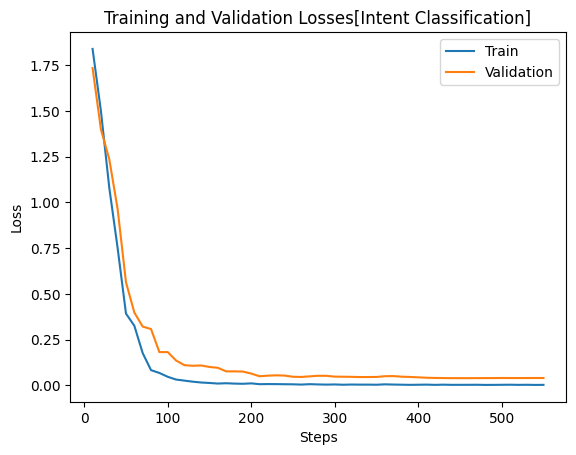

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Align losses
validation_steps = np.array(aligned_loss_callback.eval_steps)
train_losses = np.array(aligned_loss_callback.train_losses)
eval_losses = np.array(aligned_loss_callback.eval_losses)
print(len(validation_steps), len(train_losses), len(eval_losses))

# Plot aligned losses
plt.plot(validation_steps, train_losses, label='Train')
plt.plot(validation_steps, eval_losses, label='Validation')
plt.title('Training and Validation Losses[Intent Classification]')

plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.savefig('./images/intent_losses.png')

In [8]:
# store the intent labels
import json
with open('./intent_model/intent_labels.json', 'w') as f:
    json.dump(intent_labels, f)

In [9]:
# Function to test the trained model
def test_model(input_text, model, tokenizer):
    # Tokenize the input text without 'token_type_ids'
    inputs = tokenizer(input_text, return_tensors='pt', padding=True, truncation=True, max_length=128)
    
    # Remove 'token_type_ids' from the input if it exists
    inputs.pop('token_type_ids', None)
    
    # Move tensors to the appropriate device (GPU if available)
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.to(device)
    inputs = {key: value.to(device) for key, value in inputs.items()}
    
    # Make prediction
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Get predicted label (the class with the highest score)
    logits = outputs.logits
    predicted_class_id = torch.argmax(logits, dim=-1).item()
    
    return predicted_class_id

# Test the trained model with a sample input
input_text = "[INT] [BOT] [USR] Hey i want to know list my orders"
predicted_class_id = test_model(input_text, model, tokenizer)

# Print the predicted intent
print(f"Predicted intent ID: {predicted_class_id}")

# Optionally map the predicted intent ID back to the intent label
# get key from value
predicted_intent = list(intent_labels.keys())[list(intent_labels.values()).index(predicted_class_id)]
print(f"Predicted intent: {predicted_intent}")


Predicted intent ID: 2
Predicted intent: list_orders


In [10]:
# Load the model
# model = DistilBertForSequenceClassification.from_pretrained('./results/checkpoint-1500')

# Load the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Test the trained model with a sample input
input_text = "[INT] track_order [BOT] Please share the order ID [USR] 1231"
print(len(input_text))

# Get the predicted intent ID
predicted_class_id = test_model(input_text, model, tokenizer)

# Print the predicted intent
print(f"Predicted intent ID: {predicted_class_id}")
print(f"Predicted intent: {list(intent_labels.keys())[list(intent_labels.values()).index(predicted_class_id)]}")

# print probability scores of other intents
def get_intent_probs(input_text, model, tokenizer):
    # Tokenize the input text without 'token_type_ids'
    inputs = tokenizer(input_text, return_tensors='pt', padding=True, truncation=True, max_length=128)
    
    # Remove 'token_type_ids' from the input if it exists
    inputs.pop('token_type_ids', None)
    
    # Move tensors to the appropriate device (GPU if available)
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.to(device)
    inputs = {key: value.to(device) for key, value in inputs.items()}
    
    # Make prediction
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Get predicted label (the class with the highest score)
    logits = outputs.logits
    probs = torch.softmax(logits, dim=-1)
    
    return probs

# Get the probability scores for all intents
probs = get_intent_probs(input_text, model, tokenizer)

test_df = pd.read_csv(datafile)
test_df = test_df[['instruction', 'intent']]

# randomly take 15 samples
test_df = test_df.sample(15)

# Get the predicted intent ID for each sample
test_df['predicted_intent_id'] = test_df['instruction'].apply(lambda x: test_model(x, model, tokenizer))

# Map the predicted intent ID back to the intent label
test_df['predicted_intent'] = test_df['predicted_intent_id'].apply(lambda x: list(intent_labels.keys())[list(intent_labels.values()).index(x)])

for idx, row in test_df.iterrows():
    print(f"Instruction: {row['instruction']}")
    print(f"True intent: {row['intent']}")
    print(f"Predicted intent: {row['predicted_intent']}")
    print('')


60
Predicted intent ID: 1
Predicted intent: give_order_id
Instruction: [INT] [BOT]  [USR] Can you check my order 12345?
True intent: track_order
Predicted intent: track_order

Instruction: [INT] cancel_order [BOT] Please confirm the cancellation of your last order. [USR] Yes, confirm it.
True intent: confirm_command
Predicted intent: confirm_command

Instruction: [INT] [BOT]  [USR] Cancel the last item I ordered.
True intent: cancel_order
Predicted intent: cancel_order

Instruction: [INT] give_order_id [BOT] Are you sure? [USR] Yes I am sure!
True intent: confirm_command
Predicted intent: confirm_command

Instruction: [INT] list_orders [BOT] Do you need to filter anything? [USR] Yeah give me just 32 of them
True intent: give_list_order_params
Predicted intent: give_list_order_params

Instruction: [INT] cancel_order [BOT] Can you confirm the cancellation of your most recent order? [USR] No, don’t proceed with it.
True intent: confirm_command
Predicted intent: confirm_command

Instructio

# NER

In [11]:
from transformers import BertTokenizerFast
from datasets import Dataset
import pandas as pd

# Initialize tokenizer
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")
special_tokens = ["[INT]", "[BOT]", "[USR]"]
tokenizer.add_special_tokens({"additional_special_tokens": special_tokens})


# Load the data
data = pd.read_csv('./data/ner_data.csv')
data["labels"] = data["labels"].apply(eval)

# Extract unique labels and create a mapping
unique_labels = sorted({label for labels in data["labels"] for label in labels})
label_to_id = {label: idx for idx, label in enumerate(unique_labels)}

print("Label to ID Mapping:", label_to_id)

# Convert DataFrame to list of dictionaries for Dataset.from_list
data = data.to_dict(orient="records")

# Tokenize and align labels
def tokenize_and_align_labels(examples):
    # Tokenize the text
    tokenized_inputs = tokenizer(examples["instruction"], truncation=True, is_split_into_words=False)
    tokens = tokenizer.convert_ids_to_tokens(tokenized_inputs["input_ids"])
    word_ids = tokenized_inputs.word_ids()
    previous_word_idx = None
    label_ids = []
    labels = examples["labels"]

    # print(f"{'Token':<15} {'Word':<15} {'Label':<15}")

    for i, word_idx in enumerate(word_ids):
        token = tokens[i]  # Current token

        if word_idx is None:  # Special tokens ([CLS], [SEP], padding)
            word = "N/A"
            label = "Special"
            label_ids.append(-100)
        elif word_idx != previous_word_idx:  # First subword
            word = examples["instruction"][word_idx]
            label = labels[word_idx]
            label_ids.append(label_to_id[label])
        else:  # Subword token
            word = examples["instruction"][word_idx]
            label = labels[word_idx]
            token = f"Subword: {token} (Part of: {word})"
            label_ids.append(-100)

        # Print token, word, and label in the same line
        # print(f"{token:<15} {word:<15} {label:<15}")
        previous_word_idx = word_idx

    tokenized_inputs["labels"] = label_ids
    return tokenized_inputs

# Convert to Hugging Face Dataset
dataset = Dataset.from_list(data)

# Map tokenizer to the dataset
dataset = dataset.map(tokenize_and_align_labels)


Label to ID Mapping: {'B-AFFIRMATION': 0, 'B-CONFIRMATION': 1, 'B-COUNT': 2, 'B-END_DATE': 3, 'B-ORD': 4, 'B-REASON': 5, 'B-START_DATE': 6, 'I-END_DATE': 7, 'I-REASON': 8, 'I-START_DATE': 9, 'O': 10}


Map: 100%|██████████| 104/104 [00:00<00:00, 7993.40 examples/s]


In [12]:
# store the label_to_id mapping
import json
import os
if not os.path.exists('./ner_model'):
    os.makedirs('./ner_model')
with open('./ner_model/entity_labels.json', 'w') as f:
    json.dump(label_to_id, f)

In [13]:
from transformers import BertTokenizerFast, BertForTokenClassification, TrainingArguments, Trainer
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split
import pandas as pd

# Initialize tokenizer
# tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

# Load the data
data = pd.read_csv('./data/ner_data.csv')

# Convert stringified lists in 'labels' to actual lists
data["labels"] = data["labels"].apply(eval)

# Extract unique labels and create a mapping
unique_labels = sorted({label for labels in data["labels"] for label in labels})

# unique_labels = ['B-ORD', 'I-ORD', 'O']
label_to_id = {label: idx for idx, label in enumerate(unique_labels)}
id_to_label = {idx: label for label, idx in label_to_id.items()}

print("Label to ID Mapping:", label_to_id)

# Convert DataFrame to list of dictionaries
data_dict = data.to_dict(orient="records")


# Tokenize and align labels

# Convert data to Hugging Face Dataset
hf_dataset = Dataset.from_list(data_dict)

# Split the dataset into train and validation sets
train_data, val_data = train_test_split(data_dict, test_size=0.1, random_state=42)
hf_dataset = DatasetDict({
    "train": Dataset.from_list(train_data),
    "validation": Dataset.from_list(val_data),
})

# Apply the tokenizer and label alignment
hf_dataset = hf_dataset.map(tokenize_and_align_labels, batched=False)
# Define the model
model = BertForTokenClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=len(label_to_id),
    id2label=id_to_label,
    label2id=label_to_id
)

model.resize_token_embeddings(len(tokenizer)) # need to test

# Define training arguments
training_args = TrainingArguments(
    output_dir="./ner_model",
    evaluation_strategy="steps",  # Perform evaluation at specific steps
    eval_steps=10,  # Log evaluation loss every 10 steps
    save_strategy="steps",
    save_steps=10,
    logging_steps=10,  # Log training loss every 10 steps
    learning_rate=1e-5,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    num_train_epochs=100,
    weight_decay=0.0001,
    logging_dir="./logs",
    save_total_limit=2,
    load_best_model_at_end=True
)


# Use default data collator for token classification
from transformers import DataCollatorForTokenClassification
data_collator = DataCollatorForTokenClassification(tokenizer)

# Define the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=hf_dataset["train"],
    eval_dataset=hf_dataset["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    callbacks=[aligned_loss_callback]
)

# Train the model
trainer.train()

# Save the model and tokenizer
model.save_pretrained("./ner_model")
tokenizer.save_pretrained("./ner_model")


Label to ID Mapping: {'B-AFFIRMATION': 0, 'B-CONFIRMATION': 1, 'B-COUNT': 2, 'B-END_DATE': 3, 'B-ORD': 4, 'B-REASON': 5, 'B-START_DATE': 6, 'I-END_DATE': 7, 'I-REASON': 8, 'I-START_DATE': 9, 'O': 10}


Map: 100%|██████████| 11/11 [00:00<00:00, 2501.62 examples/s]
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`
/home/harshit/IITH/Sem7/CyberSecurityAndAI/project/cyber_security_project/venv/lib/python3.12/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipykernel_29747/2903455539.py:76: FutureWarning: `tokenizer` is deprecated and will be removed

{'loss': 1.939, 'grad_norm': 11.833813667297363, 'learning_rate': 9.97872340425532e-06, 'epoch': 0.21}



                                       

                               
  0%|          | 0/550 [00:47<?, ?it/s]          



{'eval_loss': 1.252511978149414, 'eval_runtime': 0.0328, 'eval_samples_per_second': 335.403, 'eval_steps_per_second': 182.947, 'epoch': 0.21}


                                       
  0%|          | 0/550 [00:49<?, ?it/s]          

{'loss': 0.8872, 'grad_norm': 5.8260498046875, 'learning_rate': 9.957446808510639e-06, 'epoch': 0.43}



                                       

                               
  0%|          | 0/550 [00:49<?, ?it/s]          



{'eval_loss': 0.38449764251708984, 'eval_runtime': 0.0282, 'eval_samples_per_second': 390.28, 'eval_steps_per_second': 212.88, 'epoch': 0.43}


                                       
  0%|          | 0/550 [00:51<?, ?it/s]          

{'loss': 0.5857, 'grad_norm': 2.212134838104248, 'learning_rate': 9.936170212765958e-06, 'epoch': 0.64}



                                       

                               
  0%|          | 0/550 [00:51<?, ?it/s]          



{'eval_loss': 0.3017134666442871, 'eval_runtime': 0.0361, 'eval_samples_per_second': 305.069, 'eval_steps_per_second': 166.401, 'epoch': 0.64}


                                       
  0%|          | 0/550 [00:54<?, ?it/s]          

{'loss': 0.3203, 'grad_norm': 3.0291926860809326, 'learning_rate': 9.914893617021277e-06, 'epoch': 0.85}



                                       

                               
  0%|          | 0/550 [00:54<?, ?it/s]          



{'eval_loss': 0.25034913420677185, 'eval_runtime': 0.0293, 'eval_samples_per_second': 374.793, 'eval_steps_per_second': 204.432, 'epoch': 0.85}


                                       
  0%|          | 0/550 [00:57<?, ?it/s]          

{'loss': 0.3041, 'grad_norm': 1.6541122198104858, 'learning_rate': 9.893617021276596e-06, 'epoch': 1.06}



                                       

                               
  0%|          | 0/550 [00:57<?, ?it/s]          



{'eval_loss': 0.20666584372520447, 'eval_runtime': 0.0265, 'eval_samples_per_second': 415.091, 'eval_steps_per_second': 226.413, 'epoch': 1.06}


                                       
  0%|          | 0/550 [01:00<?, ?it/s]          

{'loss': 0.5544, 'grad_norm': 7.551794052124023, 'learning_rate': 9.872340425531915e-06, 'epoch': 1.28}



                                       

                               
  0%|          | 0/550 [01:00<?, ?it/s]          



{'eval_loss': 0.17982688546180725, 'eval_runtime': 0.0275, 'eval_samples_per_second': 400.078, 'eval_steps_per_second': 218.224, 'epoch': 1.28}


                                       
  0%|          | 0/550 [01:02<?, ?it/s]          

{'loss': 0.2043, 'grad_norm': 1.3758814334869385, 'learning_rate': 9.851063829787235e-06, 'epoch': 1.49}



                                       

                               
  0%|          | 0/550 [01:03<?, ?it/s]          



{'eval_loss': 0.16369609534740448, 'eval_runtime': 0.0255, 'eval_samples_per_second': 431.307, 'eval_steps_per_second': 235.258, 'epoch': 1.49}


                                       
  0%|          | 0/550 [01:05<?, ?it/s]          

{'loss': 0.3005, 'grad_norm': 4.4817986488342285, 'learning_rate': 9.829787234042554e-06, 'epoch': 1.7}



                                       

                               
  0%|          | 0/550 [01:05<?, ?it/s]          



{'eval_loss': 0.15013669431209564, 'eval_runtime': 0.0256, 'eval_samples_per_second': 430.189, 'eval_steps_per_second': 234.649, 'epoch': 1.7}


                                       
  0%|          | 0/550 [01:10<?, ?it/s]          

{'loss': 0.1915, 'grad_norm': 0.47217434644699097, 'learning_rate': 9.808510638297873e-06, 'epoch': 1.91}



                                       

                               
  0%|          | 0/550 [01:10<?, ?it/s]          



{'eval_loss': 0.13845525681972504, 'eval_runtime': 0.0272, 'eval_samples_per_second': 404.536, 'eval_steps_per_second': 220.656, 'epoch': 1.91}


                                       
  0%|          | 0/550 [01:13<?, ?it/s]           

{'loss': 0.1385, 'grad_norm': 2.0030481815338135, 'learning_rate': 9.787234042553192e-06, 'epoch': 2.13}



                                       

                               
  0%|          | 0/550 [01:13<?, ?it/s]           



{'eval_loss': 0.11687219887971878, 'eval_runtime': 0.0268, 'eval_samples_per_second': 411.008, 'eval_steps_per_second': 224.186, 'epoch': 2.13}


                                       
  0%|          | 0/550 [01:16<?, ?it/s]           

{'loss': 0.213, 'grad_norm': 1.1908998489379883, 'learning_rate': 9.765957446808511e-06, 'epoch': 2.34}



                                       

                               
  0%|          | 0/550 [01:16<?, ?it/s]           



{'eval_loss': 0.1017613634467125, 'eval_runtime': 0.0328, 'eval_samples_per_second': 335.417, 'eval_steps_per_second': 182.955, 'epoch': 2.34}


                                       
  0%|          | 0/550 [01:18<?, ?it/s]           

{'loss': 0.1836, 'grad_norm': 4.60689640045166, 'learning_rate': 9.74468085106383e-06, 'epoch': 2.55}



                                       

                               
  0%|          | 0/550 [01:18<?, ?it/s]           



{'eval_loss': 0.11298763006925583, 'eval_runtime': 0.0393, 'eval_samples_per_second': 279.547, 'eval_steps_per_second': 152.48, 'epoch': 2.55}


                                       
  0%|          | 0/550 [01:21<?, ?it/s]           

{'loss': 0.1521, 'grad_norm': 2.5090346336364746, 'learning_rate': 9.723404255319149e-06, 'epoch': 2.77}



                                       

                               
  0%|          | 0/550 [01:21<?, ?it/s]           



{'eval_loss': 0.08949635177850723, 'eval_runtime': 0.0289, 'eval_samples_per_second': 380.797, 'eval_steps_per_second': 207.707, 'epoch': 2.77}


                                       
  0%|          | 0/550 [01:25<?, ?it/s]           

{'loss': 0.0649, 'grad_norm': 0.9462102055549622, 'learning_rate': 9.702127659574468e-06, 'epoch': 2.98}



                                       

                               
  0%|          | 0/550 [01:25<?, ?it/s]           



{'eval_loss': 0.07901402562856674, 'eval_runtime': 0.0286, 'eval_samples_per_second': 385.017, 'eval_steps_per_second': 210.009, 'epoch': 2.98}


                                       
  0%|          | 0/550 [01:27<?, ?it/s]           

{'loss': 0.0535, 'grad_norm': 3.802363395690918, 'learning_rate': 9.680851063829787e-06, 'epoch': 3.19}



                                       

                               
  0%|          | 0/550 [01:28<?, ?it/s]           



{'eval_loss': 0.0805388018488884, 'eval_runtime': 0.0276, 'eval_samples_per_second': 397.921, 'eval_steps_per_second': 217.048, 'epoch': 3.19}


                                       
  0%|          | 0/550 [01:30<?, ?it/s]           

{'loss': 0.1511, 'grad_norm': 1.6760884523391724, 'learning_rate': 9.659574468085106e-06, 'epoch': 3.4}



                                       

                               
  0%|          | 0/550 [01:30<?, ?it/s]           



{'eval_loss': 0.06422558426856995, 'eval_runtime': 0.0293, 'eval_samples_per_second': 375.684, 'eval_steps_per_second': 204.918, 'epoch': 3.4}


                                       
  0%|          | 0/550 [01:33<?, ?it/s]           

{'loss': 0.0683, 'grad_norm': 0.1746620535850525, 'learning_rate': 9.638297872340426e-06, 'epoch': 3.62}



                                       

                               
  0%|          | 0/550 [01:33<?, ?it/s]           



{'eval_loss': 0.06494223326444626, 'eval_runtime': 0.0284, 'eval_samples_per_second': 387.758, 'eval_steps_per_second': 211.504, 'epoch': 3.62}


                                       
  0%|          | 0/550 [01:36<?, ?it/s]           

{'loss': 0.0467, 'grad_norm': 1.349178671836853, 'learning_rate': 9.617021276595745e-06, 'epoch': 3.83}



                                       

                               
  0%|          | 0/550 [01:37<?, ?it/s]           



{'eval_loss': 0.059570226818323135, 'eval_runtime': 0.0301, 'eval_samples_per_second': 365.077, 'eval_steps_per_second': 199.133, 'epoch': 3.83}


                                       
  0%|          | 0/550 [01:39<?, ?it/s]           

{'loss': 0.0505, 'grad_norm': 0.12458187341690063, 'learning_rate': 9.595744680851065e-06, 'epoch': 4.04}



                                       

                               
  0%|          | 0/550 [01:40<?, ?it/s]           



{'eval_loss': 0.051675163209438324, 'eval_runtime': 0.03, 'eval_samples_per_second': 366.318, 'eval_steps_per_second': 199.81, 'epoch': 4.04}


                                       
  0%|          | 0/550 [01:43<?, ?it/s]           

{'loss': 0.0797, 'grad_norm': 2.073136568069458, 'learning_rate': 9.574468085106385e-06, 'epoch': 4.26}



                                       

                               
  0%|          | 0/550 [01:43<?, ?it/s]           



{'eval_loss': 0.054017625749111176, 'eval_runtime': 0.0286, 'eval_samples_per_second': 385.142, 'eval_steps_per_second': 210.078, 'epoch': 4.26}


                                       
  0%|          | 0/550 [01:46<?, ?it/s]           

{'loss': 0.0546, 'grad_norm': 0.0950949639081955, 'learning_rate': 9.553191489361704e-06, 'epoch': 4.47}



                                       

                               
  0%|          | 0/550 [01:46<?, ?it/s]           



{'eval_loss': 0.061294738203287125, 'eval_runtime': 0.0272, 'eval_samples_per_second': 404.596, 'eval_steps_per_second': 220.689, 'epoch': 4.47}


                                       
  0%|          | 0/550 [01:49<?, ?it/s]           

{'loss': 0.0509, 'grad_norm': 0.22962112724781036, 'learning_rate': 9.531914893617023e-06, 'epoch': 4.68}



                                       

                               
  0%|          | 0/550 [01:49<?, ?it/s]           



{'eval_loss': 0.05182240903377533, 'eval_runtime': 0.028, 'eval_samples_per_second': 393.489, 'eval_steps_per_second': 214.63, 'epoch': 4.68}


                                       
  0%|          | 0/550 [01:53<?, ?it/s]           

{'loss': 0.0428, 'grad_norm': 0.24317121505737305, 'learning_rate': 9.510638297872342e-06, 'epoch': 4.89}



                                       

                               
  0%|          | 0/550 [01:53<?, ?it/s]           



{'eval_loss': 0.040666963905096054, 'eval_runtime': 0.0281, 'eval_samples_per_second': 391.798, 'eval_steps_per_second': 213.708, 'epoch': 4.89}


                                       
  0%|          | 0/550 [01:56<?, ?it/s]           

{'loss': 0.0267, 'grad_norm': 0.22350560128688812, 'learning_rate': 9.489361702127661e-06, 'epoch': 5.11}



                                       

                               
  0%|          | 0/550 [01:56<?, ?it/s]           



{'eval_loss': 0.04111504182219505, 'eval_runtime': 0.026, 'eval_samples_per_second': 422.735, 'eval_steps_per_second': 230.583, 'epoch': 5.11}


                                       
  0%|          | 0/550 [02:00<?, ?it/s]           

{'loss': 0.0417, 'grad_norm': 1.176203966140747, 'learning_rate': 9.46808510638298e-06, 'epoch': 5.32}



                                       

                               
  0%|          | 0/550 [02:00<?, ?it/s]           



{'eval_loss': 0.03954043984413147, 'eval_runtime': 0.0257, 'eval_samples_per_second': 428.726, 'eval_steps_per_second': 233.851, 'epoch': 5.32}


                                       
  0%|          | 0/550 [02:03<?, ?it/s]           

{'loss': 0.0259, 'grad_norm': 1.013694167137146, 'learning_rate': 9.446808510638299e-06, 'epoch': 5.53}



                                       

                               
  0%|          | 0/550 [02:03<?, ?it/s]           



{'eval_loss': 0.03665453568100929, 'eval_runtime': 0.0338, 'eval_samples_per_second': 325.048, 'eval_steps_per_second': 177.299, 'epoch': 5.53}


                                       
  0%|          | 0/550 [02:07<?, ?it/s]           

{'loss': 0.0718, 'grad_norm': 4.590598106384277, 'learning_rate': 9.425531914893618e-06, 'epoch': 5.74}



                                       

                               
  0%|          | 0/550 [02:07<?, ?it/s]           



{'eval_loss': 0.03781463950872421, 'eval_runtime': 0.0277, 'eval_samples_per_second': 397.178, 'eval_steps_per_second': 216.642, 'epoch': 5.74}


                                       
  0%|          | 0/550 [02:09<?, ?it/s]           

{'loss': 0.0309, 'grad_norm': 0.1355167180299759, 'learning_rate': 9.404255319148937e-06, 'epoch': 5.96}



                                       

                               
  0%|          | 0/550 [02:09<?, ?it/s]           



{'eval_loss': 0.05118727311491966, 'eval_runtime': 0.0272, 'eval_samples_per_second': 404.139, 'eval_steps_per_second': 220.44, 'epoch': 5.96}


                                       
  0%|          | 0/550 [02:13<?, ?it/s]           

{'loss': 0.0482, 'grad_norm': 1.2150146961212158, 'learning_rate': 9.382978723404256e-06, 'epoch': 6.17}



                                       

                               
  0%|          | 0/550 [02:13<?, ?it/s]           



{'eval_loss': 0.041723642498254776, 'eval_runtime': 0.0267, 'eval_samples_per_second': 412.11, 'eval_steps_per_second': 224.787, 'epoch': 6.17}


                                       
  0%|          | 0/550 [02:16<?, ?it/s]           

{'loss': 0.0191, 'grad_norm': 0.05515441298484802, 'learning_rate': 9.361702127659576e-06, 'epoch': 6.38}



                                       

                               
  0%|          | 0/550 [02:16<?, ?it/s]           



{'eval_loss': 0.05112731456756592, 'eval_runtime': 0.0278, 'eval_samples_per_second': 395.099, 'eval_steps_per_second': 215.509, 'epoch': 6.38}


                                       
  0%|          | 0/550 [02:21<?, ?it/s]           

{'loss': 0.0298, 'grad_norm': 0.12064744532108307, 'learning_rate': 9.340425531914895e-06, 'epoch': 6.6}



                                       

                               
  0%|          | 0/550 [02:21<?, ?it/s]           



{'eval_loss': 0.053305789828300476, 'eval_runtime': 0.0251, 'eval_samples_per_second': 438.002, 'eval_steps_per_second': 238.91, 'epoch': 6.6}


                                       
  0%|          | 0/550 [02:24<?, ?it/s]           

{'loss': 0.0305, 'grad_norm': 0.5077612400054932, 'learning_rate': 9.319148936170214e-06, 'epoch': 6.81}



                                       

                               
  0%|          | 0/550 [02:24<?, ?it/s]           



{'eval_loss': 0.06790988147258759, 'eval_runtime': 0.0325, 'eval_samples_per_second': 338.412, 'eval_steps_per_second': 184.588, 'epoch': 6.81}


                                       
  0%|          | 0/550 [02:29<?, ?it/s]           

{'loss': 0.0169, 'grad_norm': 0.71659255027771, 'learning_rate': 9.297872340425533e-06, 'epoch': 7.02}



                                       

                               
  0%|          | 0/550 [02:29<?, ?it/s]           



{'eval_loss': 0.08892915397882462, 'eval_runtime': 0.0369, 'eval_samples_per_second': 298.236, 'eval_steps_per_second': 162.674, 'epoch': 7.02}


                                       
  0%|          | 0/550 [02:33<?, ?it/s]           

{'loss': 0.0295, 'grad_norm': 1.034102439880371, 'learning_rate': 9.276595744680852e-06, 'epoch': 7.23}



                                       

                               
  0%|          | 0/550 [02:33<?, ?it/s]           



{'eval_loss': 0.04258401691913605, 'eval_runtime': 0.0285, 'eval_samples_per_second': 385.819, 'eval_steps_per_second': 210.447, 'epoch': 7.23}


                                       
  0%|          | 0/550 [02:38<?, ?it/s]           

{'loss': 0.0155, 'grad_norm': 0.4173926115036011, 'learning_rate': 9.255319148936171e-06, 'epoch': 7.45}



                                       

                               
  0%|          | 0/550 [02:38<?, ?it/s]           



{'eval_loss': 0.036602120846509933, 'eval_runtime': 0.0333, 'eval_samples_per_second': 329.998, 'eval_steps_per_second': 179.999, 'epoch': 7.45}


                                       
  0%|          | 0/550 [02:41<?, ?it/s]           

{'loss': 0.0141, 'grad_norm': 1.085924744606018, 'learning_rate': 9.23404255319149e-06, 'epoch': 7.66}



                                       

                               
  0%|          | 0/550 [02:41<?, ?it/s]           



{'eval_loss': 0.033845093101263046, 'eval_runtime': 0.0264, 'eval_samples_per_second': 416.808, 'eval_steps_per_second': 227.35, 'epoch': 7.66}


                                       
  0%|          | 0/550 [02:46<?, ?it/s]           

{'loss': 0.0275, 'grad_norm': 0.13208375871181488, 'learning_rate': 9.21276595744681e-06, 'epoch': 7.87}



                                       

                               
  0%|          | 0/550 [02:46<?, ?it/s]           



{'eval_loss': 0.05065593868494034, 'eval_runtime': 0.0377, 'eval_samples_per_second': 291.564, 'eval_steps_per_second': 159.035, 'epoch': 7.87}


                                       
  0%|          | 0/550 [02:49<?, ?it/s]           

{'loss': 0.0238, 'grad_norm': 0.13148480653762817, 'learning_rate': 9.191489361702128e-06, 'epoch': 8.09}



                                       

                               
  0%|          | 0/550 [02:49<?, ?it/s]           



{'eval_loss': 0.07097457349300385, 'eval_runtime': 0.0345, 'eval_samples_per_second': 319.036, 'eval_steps_per_second': 174.019, 'epoch': 8.09}


                                       
  0%|          | 0/550 [02:52<?, ?it/s]           

{'loss': 0.0278, 'grad_norm': 0.8442036509513855, 'learning_rate': 9.170212765957447e-06, 'epoch': 8.3}



                                       

                               
  0%|          | 0/550 [02:52<?, ?it/s]           



{'eval_loss': 0.04875544086098671, 'eval_runtime': 0.0261, 'eval_samples_per_second': 420.673, 'eval_steps_per_second': 229.458, 'epoch': 8.3}


                                       
  0%|          | 0/550 [02:56<?, ?it/s]           

{'loss': 0.0336, 'grad_norm': 0.0331575945019722, 'learning_rate': 9.148936170212767e-06, 'epoch': 8.51}



                                       

                               
  0%|          | 0/550 [02:56<?, ?it/s]           



{'eval_loss': 0.034593041986227036, 'eval_runtime': 0.027, 'eval_samples_per_second': 407.97, 'eval_steps_per_second': 222.529, 'epoch': 8.51}


                                       
  0%|          | 0/550 [03:01<?, ?it/s]           

{'loss': 0.0043, 'grad_norm': 0.14372918009757996, 'learning_rate': 9.127659574468086e-06, 'epoch': 8.72}



                                       

                               
  0%|          | 0/550 [03:01<?, ?it/s]           



{'eval_loss': 0.031520310789346695, 'eval_runtime': 0.0265, 'eval_samples_per_second': 414.572, 'eval_steps_per_second': 226.13, 'epoch': 8.72}


                                       
  0%|          | 0/550 [03:05<?, ?it/s]           

{'loss': 0.0115, 'grad_norm': 0.02979268506169319, 'learning_rate': 9.106382978723405e-06, 'epoch': 8.94}



                                       

                               
  0%|          | 0/550 [03:05<?, ?it/s]           



{'eval_loss': 0.03237586468458176, 'eval_runtime': 0.031, 'eval_samples_per_second': 354.42, 'eval_steps_per_second': 193.32, 'epoch': 8.94}


                                       
  0%|          | 0/550 [03:11<?, ?it/s]           

{'loss': 0.0144, 'grad_norm': 0.031686972826719284, 'learning_rate': 9.085106382978724e-06, 'epoch': 9.15}



                                       

                               
  0%|          | 0/550 [03:11<?, ?it/s]           



{'eval_loss': 0.03401298448443413, 'eval_runtime': 0.0251, 'eval_samples_per_second': 438.264, 'eval_steps_per_second': 239.053, 'epoch': 9.15}


                                       
  0%|          | 0/550 [03:15<?, ?it/s]           

{'loss': 0.0085, 'grad_norm': 0.032740768045186996, 'learning_rate': 9.063829787234043e-06, 'epoch': 9.36}



                                       

                               
  0%|          | 0/550 [03:15<?, ?it/s]           



{'eval_loss': 0.03387743979692459, 'eval_runtime': 0.0274, 'eval_samples_per_second': 400.783, 'eval_steps_per_second': 218.609, 'epoch': 9.36}


                                       
  0%|          | 0/550 [03:19<?, ?it/s]           

{'loss': 0.0256, 'grad_norm': 0.17825259268283844, 'learning_rate': 9.042553191489362e-06, 'epoch': 9.57}



                                       

                               
  0%|          | 0/550 [03:19<?, ?it/s]           



{'eval_loss': 0.03373836725950241, 'eval_runtime': 0.0322, 'eval_samples_per_second': 341.854, 'eval_steps_per_second': 186.466, 'epoch': 9.57}


                                       
  0%|          | 0/550 [03:23<?, ?it/s]           

{'loss': 0.0161, 'grad_norm': 0.03721898794174194, 'learning_rate': 9.021276595744681e-06, 'epoch': 9.79}



                                       

                               
  0%|          | 0/550 [03:23<?, ?it/s]           



{'eval_loss': 0.04411259666085243, 'eval_runtime': 0.0277, 'eval_samples_per_second': 396.754, 'eval_steps_per_second': 216.411, 'epoch': 9.79}


                                       
  0%|          | 0/550 [03:26<?, ?it/s]           

{'loss': 0.0065, 'grad_norm': 0.06161282956600189, 'learning_rate': 9e-06, 'epoch': 10.0}



                                       

                               
  0%|          | 0/550 [03:26<?, ?it/s]           



{'eval_loss': 0.04909545183181763, 'eval_runtime': 0.0269, 'eval_samples_per_second': 408.259, 'eval_steps_per_second': 222.687, 'epoch': 10.0}


                                       
  0%|          | 0/550 [03:29<?, ?it/s]           

{'loss': 0.0163, 'grad_norm': 0.034782711416482925, 'learning_rate': 8.97872340425532e-06, 'epoch': 10.21}



                                       

                               
  0%|          | 0/550 [03:29<?, ?it/s]           



{'eval_loss': 0.036442097276449203, 'eval_runtime': 0.0262, 'eval_samples_per_second': 419.919, 'eval_steps_per_second': 229.047, 'epoch': 10.21}


                                       
  0%|          | 0/550 [03:33<?, ?it/s]           

{'loss': 0.0066, 'grad_norm': 0.17028388381004333, 'learning_rate': 8.957446808510638e-06, 'epoch': 10.43}



                                       

                               
  0%|          | 0/550 [03:33<?, ?it/s]           



{'eval_loss': 0.034852758049964905, 'eval_runtime': 0.0266, 'eval_samples_per_second': 414.07, 'eval_steps_per_second': 225.856, 'epoch': 10.43}


                                       
  0%|          | 0/550 [03:37<?, ?it/s]           

{'loss': 0.0062, 'grad_norm': 0.049601539969444275, 'learning_rate': 8.936170212765958e-06, 'epoch': 10.64}



                                       

                               
  0%|          | 0/550 [03:37<?, ?it/s]           



{'eval_loss': 0.031975314021110535, 'eval_runtime': 0.0328, 'eval_samples_per_second': 335.859, 'eval_steps_per_second': 183.196, 'epoch': 10.64}


                                       
  0%|          | 0/550 [03:41<?, ?it/s]           

{'loss': 0.0084, 'grad_norm': 6.6729302406311035, 'learning_rate': 8.914893617021277e-06, 'epoch': 10.85}



                                       

                               
  0%|          | 0/550 [03:41<?, ?it/s]           



{'eval_loss': 0.03394145146012306, 'eval_runtime': 0.0421, 'eval_samples_per_second': 261.182, 'eval_steps_per_second': 142.463, 'epoch': 10.85}


                                       
  0%|          | 0/550 [03:45<?, ?it/s]           

{'loss': 0.0136, 'grad_norm': 1.9941906929016113, 'learning_rate': 8.893617021276596e-06, 'epoch': 11.06}



                                       

                               
  0%|          | 0/550 [03:45<?, ?it/s]           



{'eval_loss': 0.04594714939594269, 'eval_runtime': 0.0279, 'eval_samples_per_second': 394.431, 'eval_steps_per_second': 215.144, 'epoch': 11.06}


                                       
  0%|          | 0/550 [03:48<?, ?it/s]           

{'loss': 0.0117, 'grad_norm': 0.02442530356347561, 'learning_rate': 8.872340425531915e-06, 'epoch': 11.28}



                                       

                               
  0%|          | 0/550 [03:48<?, ?it/s]           



{'eval_loss': 0.0571538545191288, 'eval_runtime': 0.0252, 'eval_samples_per_second': 436.126, 'eval_steps_per_second': 237.887, 'epoch': 11.28}


                                       
  0%|          | 0/550 [03:51<?, ?it/s]           

{'loss': 0.0024, 'grad_norm': 0.04172931984066963, 'learning_rate': 8.851063829787234e-06, 'epoch': 11.49}



                                       

                               
  0%|          | 0/550 [03:51<?, ?it/s]           



{'eval_loss': 0.05251365900039673, 'eval_runtime': 0.0303, 'eval_samples_per_second': 362.829, 'eval_steps_per_second': 197.907, 'epoch': 11.49}


                                       
  0%|          | 0/550 [03:55<?, ?it/s]           

{'loss': 0.0047, 'grad_norm': 0.042814020067453384, 'learning_rate': 8.829787234042555e-06, 'epoch': 11.7}



                                       

                               
  0%|          | 0/550 [03:55<?, ?it/s]           



{'eval_loss': 0.03546074405312538, 'eval_runtime': 0.0291, 'eval_samples_per_second': 377.791, 'eval_steps_per_second': 206.068, 'epoch': 11.7}


                                       
  0%|          | 0/550 [04:00<?, ?it/s]           

{'loss': 0.0263, 'grad_norm': 6.841769695281982, 'learning_rate': 8.808510638297874e-06, 'epoch': 11.91}



                                       

                               
  0%|          | 0/550 [04:00<?, ?it/s]           



{'eval_loss': 0.03360186517238617, 'eval_runtime': 0.0274, 'eval_samples_per_second': 401.051, 'eval_steps_per_second': 218.755, 'epoch': 11.91}


                                       
  0%|          | 0/550 [04:04<?, ?it/s]           

{'loss': 0.0028, 'grad_norm': 0.02421237714588642, 'learning_rate': 8.787234042553193e-06, 'epoch': 12.13}



                                       

                               
  0%|          | 0/550 [04:04<?, ?it/s]           



{'eval_loss': 0.07021287828683853, 'eval_runtime': 0.0281, 'eval_samples_per_second': 392.048, 'eval_steps_per_second': 213.844, 'epoch': 12.13}


                                       
  0%|          | 0/550 [04:08<?, ?it/s]           

{'loss': 0.004, 'grad_norm': 0.08418174088001251, 'learning_rate': 8.765957446808512e-06, 'epoch': 12.34}



                                       

                               
  0%|          | 0/550 [04:08<?, ?it/s]           



{'eval_loss': 0.06080286577343941, 'eval_runtime': 0.0314, 'eval_samples_per_second': 350.476, 'eval_steps_per_second': 191.169, 'epoch': 12.34}


                                       
  0%|          | 0/550 [04:12<?, ?it/s]           

{'loss': 0.0032, 'grad_norm': 0.11590680480003357, 'learning_rate': 8.744680851063831e-06, 'epoch': 12.55}



                                       

                               
  0%|          | 0/550 [04:12<?, ?it/s]           



{'eval_loss': 0.05160022899508476, 'eval_runtime': 0.0283, 'eval_samples_per_second': 389.089, 'eval_steps_per_second': 212.23, 'epoch': 12.55}


                                       
  0%|          | 0/550 [04:17<?, ?it/s]           

{'loss': 0.0028, 'grad_norm': 0.09504877775907516, 'learning_rate': 8.72340425531915e-06, 'epoch': 12.77}



                                       

                               
  0%|          | 0/550 [04:17<?, ?it/s]           



{'eval_loss': 0.06213202700018883, 'eval_runtime': 0.0331, 'eval_samples_per_second': 331.907, 'eval_steps_per_second': 181.04, 'epoch': 12.77}


                                       
  0%|          | 0/550 [04:20<?, ?it/s]           

{'loss': 0.0192, 'grad_norm': 0.050345201045274734, 'learning_rate': 8.70212765957447e-06, 'epoch': 12.98}



                                       

                               
  0%|          | 0/550 [04:20<?, ?it/s]           



{'eval_loss': 0.05847925320267677, 'eval_runtime': 0.0323, 'eval_samples_per_second': 341.028, 'eval_steps_per_second': 186.015, 'epoch': 12.98}


                                       
  0%|          | 0/550 [04:24<?, ?it/s]           

{'loss': 0.0117, 'grad_norm': 0.07207951694726944, 'learning_rate': 8.680851063829788e-06, 'epoch': 13.19}



                                       

                               
  0%|          | 0/550 [04:24<?, ?it/s]           



{'eval_loss': 0.03303416818380356, 'eval_runtime': 0.0268, 'eval_samples_per_second': 410.785, 'eval_steps_per_second': 224.065, 'epoch': 13.19}


                                       
  0%|          | 0/550 [04:29<?, ?it/s]           

{'loss': 0.0029, 'grad_norm': 0.13326451182365417, 'learning_rate': 8.659574468085108e-06, 'epoch': 13.4}



                                       

                               
  0%|          | 0/550 [04:29<?, ?it/s]           



{'eval_loss': 0.030316907912492752, 'eval_runtime': 0.0262, 'eval_samples_per_second': 419.263, 'eval_steps_per_second': 228.689, 'epoch': 13.4}


                                       
  0%|          | 0/550 [04:33<?, ?it/s]           

{'loss': 0.0042, 'grad_norm': 0.391345739364624, 'learning_rate': 8.638297872340427e-06, 'epoch': 13.62}



                                       

                               
  0%|          | 0/550 [04:33<?, ?it/s]           



{'eval_loss': 0.03002288192510605, 'eval_runtime': 0.0269, 'eval_samples_per_second': 408.979, 'eval_steps_per_second': 223.08, 'epoch': 13.62}


                                       
  0%|          | 0/550 [04:38<?, ?it/s]           

{'loss': 0.0105, 'grad_norm': 0.12961770594120026, 'learning_rate': 8.617021276595746e-06, 'epoch': 13.83}



                                       

                               
  0%|          | 0/550 [04:38<?, ?it/s]           



{'eval_loss': 0.029720978811383247, 'eval_runtime': 0.0388, 'eval_samples_per_second': 283.636, 'eval_steps_per_second': 154.71, 'epoch': 13.83}


                                       
  0%|          | 0/550 [04:42<?, ?it/s]           

{'loss': 0.0039, 'grad_norm': 0.05576295778155327, 'learning_rate': 8.595744680851065e-06, 'epoch': 14.04}



                                       

                               
  0%|          | 0/550 [04:42<?, ?it/s]           



{'eval_loss': 0.03310305252671242, 'eval_runtime': 0.0333, 'eval_samples_per_second': 330.67, 'eval_steps_per_second': 180.365, 'epoch': 14.04}


                                       
  0%|          | 0/550 [04:45<?, ?it/s]           

{'loss': 0.004, 'grad_norm': 0.015884054824709892, 'learning_rate': 8.574468085106384e-06, 'epoch': 14.26}



                                       

                               
  0%|          | 0/550 [04:45<?, ?it/s]           



{'eval_loss': 0.033441271632909775, 'eval_runtime': 0.0314, 'eval_samples_per_second': 350.484, 'eval_steps_per_second': 191.173, 'epoch': 14.26}


                                       
  0%|          | 0/550 [04:48<?, ?it/s]           

{'loss': 0.0018, 'grad_norm': 0.05071178451180458, 'learning_rate': 8.553191489361703e-06, 'epoch': 14.47}



                                       

                               
  0%|          | 0/550 [04:48<?, ?it/s]           



{'eval_loss': 0.033269647508859634, 'eval_runtime': 0.0279, 'eval_samples_per_second': 394.306, 'eval_steps_per_second': 215.076, 'epoch': 14.47}


                                       
  0%|          | 0/550 [04:51<?, ?it/s]           

{'loss': 0.0067, 'grad_norm': 0.06782324612140656, 'learning_rate': 8.531914893617022e-06, 'epoch': 14.68}



                                       

                               
  0%|          | 0/550 [04:51<?, ?it/s]           



{'eval_loss': 0.03315192833542824, 'eval_runtime': 0.0276, 'eval_samples_per_second': 399.102, 'eval_steps_per_second': 217.692, 'epoch': 14.68}


                                       
  0%|          | 0/550 [04:54<?, ?it/s]           

{'loss': 0.0096, 'grad_norm': 0.49338299036026, 'learning_rate': 8.510638297872341e-06, 'epoch': 14.89}



                                       

                               
  0%|          | 0/550 [04:54<?, ?it/s]           



{'eval_loss': 0.033290281891822815, 'eval_runtime': 0.0274, 'eval_samples_per_second': 400.898, 'eval_steps_per_second': 218.672, 'epoch': 14.89}


                                       
  0%|          | 0/550 [04:58<?, ?it/s]           

{'loss': 0.0093, 'grad_norm': 0.01719733700156212, 'learning_rate': 8.48936170212766e-06, 'epoch': 15.11}



                                       

                               
  0%|          | 0/550 [04:58<?, ?it/s]           



{'eval_loss': 0.0373632051050663, 'eval_runtime': 0.0276, 'eval_samples_per_second': 398.595, 'eval_steps_per_second': 217.415, 'epoch': 15.11}


                                       
  0%|          | 0/550 [05:01<?, ?it/s]           

{'loss': 0.0022, 'grad_norm': 0.017093980684876442, 'learning_rate': 8.46808510638298e-06, 'epoch': 15.32}



                                       

                               
  0%|          | 0/550 [05:01<?, ?it/s]           



{'eval_loss': 0.043943919241428375, 'eval_runtime': 0.03, 'eval_samples_per_second': 366.297, 'eval_steps_per_second': 199.799, 'epoch': 15.32}


                                       
  0%|          | 0/550 [05:06<?, ?it/s]           

{'loss': 0.0018, 'grad_norm': 0.1972607970237732, 'learning_rate': 8.446808510638299e-06, 'epoch': 15.53}



                                       

                               
  0%|          | 0/550 [05:06<?, ?it/s]           



{'eval_loss': 0.04561256244778633, 'eval_runtime': 0.027, 'eval_samples_per_second': 406.866, 'eval_steps_per_second': 221.927, 'epoch': 15.53}


                                       
  0%|          | 0/550 [05:10<?, ?it/s]           

{'loss': 0.0027, 'grad_norm': 0.04894406720995903, 'learning_rate': 8.425531914893618e-06, 'epoch': 15.74}



                                       

                               
  0%|          | 0/550 [05:10<?, ?it/s]           



{'eval_loss': 0.051673971116542816, 'eval_runtime': 0.0267, 'eval_samples_per_second': 412.596, 'eval_steps_per_second': 225.053, 'epoch': 15.74}


                                       
  0%|          | 0/550 [05:13<?, ?it/s]           

{'loss': 0.0077, 'grad_norm': 0.9339205026626587, 'learning_rate': 8.404255319148937e-06, 'epoch': 15.96}



                                       

                               
  0%|          | 0/550 [05:13<?, ?it/s]           



{'eval_loss': 0.04841732606291771, 'eval_runtime': 0.0294, 'eval_samples_per_second': 374.054, 'eval_steps_per_second': 204.03, 'epoch': 15.96}


                                       
  0%|          | 0/550 [05:16<?, ?it/s]           

{'loss': 0.0025, 'grad_norm': 0.05676007270812988, 'learning_rate': 8.382978723404256e-06, 'epoch': 16.17}



                                       

                               
  0%|          | 0/550 [05:17<?, ?it/s]           



{'eval_loss': 0.03887132182717323, 'eval_runtime': 0.0268, 'eval_samples_per_second': 410.526, 'eval_steps_per_second': 223.923, 'epoch': 16.17}


                                       
  0%|          | 0/550 [05:20<?, ?it/s]           

{'loss': 0.0045, 'grad_norm': 0.013881660997867584, 'learning_rate': 8.361702127659575e-06, 'epoch': 16.38}



                                       

                               
  0%|          | 0/550 [05:20<?, ?it/s]           



{'eval_loss': 0.03963376581668854, 'eval_runtime': 0.0271, 'eval_samples_per_second': 406.428, 'eval_steps_per_second': 221.688, 'epoch': 16.38}


                                       
  0%|          | 0/550 [05:23<?, ?it/s]           

{'loss': 0.0019, 'grad_norm': 0.014988496899604797, 'learning_rate': 8.340425531914894e-06, 'epoch': 16.6}



                                       

                               
  0%|          | 0/550 [05:23<?, ?it/s]           



{'eval_loss': 0.04262934625148773, 'eval_runtime': 0.0286, 'eval_samples_per_second': 384.481, 'eval_steps_per_second': 209.717, 'epoch': 16.6}


                                       
  0%|          | 0/550 [05:27<?, ?it/s]           

{'loss': 0.0073, 'grad_norm': 0.053604673594236374, 'learning_rate': 8.319148936170213e-06, 'epoch': 16.81}



                                       

                               
  0%|          | 0/550 [05:27<?, ?it/s]           



{'eval_loss': 0.042047277092933655, 'eval_runtime': 0.0288, 'eval_samples_per_second': 382.166, 'eval_steps_per_second': 208.454, 'epoch': 16.81}


                                       
  0%|          | 0/550 [05:30<?, ?it/s]           

{'loss': 0.0013, 'grad_norm': 0.043101731687784195, 'learning_rate': 8.297872340425532e-06, 'epoch': 17.02}



                                       

                               
  0%|          | 0/550 [05:30<?, ?it/s]           



{'eval_loss': 0.04129178449511528, 'eval_runtime': 0.0273, 'eval_samples_per_second': 402.265, 'eval_steps_per_second': 219.417, 'epoch': 17.02}


                                       
  0%|          | 0/550 [05:33<?, ?it/s]           

{'loss': 0.0058, 'grad_norm': 1.2247872352600098, 'learning_rate': 8.276595744680851e-06, 'epoch': 17.23}



                                       

                               
  0%|          | 0/550 [05:33<?, ?it/s]           



{'eval_loss': 0.036455266177654266, 'eval_runtime': 0.0348, 'eval_samples_per_second': 315.955, 'eval_steps_per_second': 172.339, 'epoch': 17.23}


                                       
  0%|          | 0/550 [05:37<?, ?it/s]           

{'loss': 0.0059, 'grad_norm': 0.7844254374504089, 'learning_rate': 8.25531914893617e-06, 'epoch': 17.45}



                                       

                               
  0%|          | 0/550 [05:37<?, ?it/s]           



{'eval_loss': 0.0341184176504612, 'eval_runtime': 0.0326, 'eval_samples_per_second': 337.518, 'eval_steps_per_second': 184.101, 'epoch': 17.45}


                                       
  0%|          | 0/550 [05:41<?, ?it/s]           

{'loss': 0.0014, 'grad_norm': 0.029000524431467056, 'learning_rate': 8.23404255319149e-06, 'epoch': 17.66}



                                       

                               
  0%|          | 0/550 [05:41<?, ?it/s]           



{'eval_loss': 0.034199297428131104, 'eval_runtime': 0.0272, 'eval_samples_per_second': 405.055, 'eval_steps_per_second': 220.939, 'epoch': 17.66}


                                       
  0%|          | 0/550 [05:44<?, ?it/s]           

{'loss': 0.0026, 'grad_norm': 0.0447973757982254, 'learning_rate': 8.212765957446809e-06, 'epoch': 17.87}



                                       

                               
  0%|          | 0/550 [05:45<?, ?it/s]           



{'eval_loss': 0.03333542123436928, 'eval_runtime': 0.028, 'eval_samples_per_second': 392.488, 'eval_steps_per_second': 214.084, 'epoch': 17.87}


                                       
  0%|          | 0/550 [05:49<?, ?it/s]           

{'loss': 0.002, 'grad_norm': 0.05341148003935814, 'learning_rate': 8.191489361702128e-06, 'epoch': 18.09}



                                       

                               
  0%|          | 0/550 [05:49<?, ?it/s]           



{'eval_loss': 0.033711664378643036, 'eval_runtime': 0.0271, 'eval_samples_per_second': 405.913, 'eval_steps_per_second': 221.407, 'epoch': 18.09}


                                       
  0%|          | 0/550 [05:53<?, ?it/s]           

{'loss': 0.0069, 'grad_norm': 0.013588120229542255, 'learning_rate': 8.170212765957447e-06, 'epoch': 18.3}



                                       

                               
  0%|          | 0/550 [05:53<?, ?it/s]           



{'eval_loss': 0.0896047055721283, 'eval_runtime': 0.0292, 'eval_samples_per_second': 376.321, 'eval_steps_per_second': 205.266, 'epoch': 18.3}


                                       
  0%|          | 0/550 [05:56<?, ?it/s]           

{'loss': 0.0039, 'grad_norm': 0.0722021609544754, 'learning_rate': 8.148936170212766e-06, 'epoch': 18.51}



                                       

                               
  0%|          | 0/550 [05:56<?, ?it/s]           



{'eval_loss': 0.1157418042421341, 'eval_runtime': 0.0268, 'eval_samples_per_second': 410.332, 'eval_steps_per_second': 223.818, 'epoch': 18.51}


                                       
  0%|          | 0/550 [06:01<?, ?it/s]           

{'loss': 0.0012, 'grad_norm': 0.044531043618917465, 'learning_rate': 8.127659574468085e-06, 'epoch': 18.72}



                                       

                               
  0%|          | 0/550 [06:01<?, ?it/s]           



{'eval_loss': 0.12197493761777878, 'eval_runtime': 0.0285, 'eval_samples_per_second': 385.441, 'eval_steps_per_second': 210.241, 'epoch': 18.72}


                                       
  0%|          | 0/550 [06:04<?, ?it/s]           

{'loss': 0.0023, 'grad_norm': 0.029320204630494118, 'learning_rate': 8.106382978723404e-06, 'epoch': 18.94}



                                       

                               
  0%|          | 0/550 [06:04<?, ?it/s]           



{'eval_loss': 0.11928176134824753, 'eval_runtime': 0.0356, 'eval_samples_per_second': 309.002, 'eval_steps_per_second': 168.546, 'epoch': 18.94}


                                       
  0%|          | 0/550 [06:08<?, ?it/s]           

{'loss': 0.0015, 'grad_norm': 0.013730037026107311, 'learning_rate': 8.085106382978723e-06, 'epoch': 19.15}



                                       

                               
  0%|          | 0/550 [06:08<?, ?it/s]           



{'eval_loss': 0.11530052870512009, 'eval_runtime': 0.029, 'eval_samples_per_second': 379.588, 'eval_steps_per_second': 207.048, 'epoch': 19.15}


                                       
  0%|          | 0/550 [06:12<?, ?it/s]           

{'loss': 0.002, 'grad_norm': 0.1786094605922699, 'learning_rate': 8.063829787234044e-06, 'epoch': 19.36}



                                       

                               
  0%|          | 0/550 [06:12<?, ?it/s]           



{'eval_loss': 0.11092701554298401, 'eval_runtime': 0.0271, 'eval_samples_per_second': 405.71, 'eval_steps_per_second': 221.296, 'epoch': 19.36}


                                       
  0%|          | 0/550 [06:15<?, ?it/s]           

{'loss': 0.0014, 'grad_norm': 0.016583429649472237, 'learning_rate': 8.042553191489363e-06, 'epoch': 19.57}



                                       

                               
  0%|          | 0/550 [06:15<?, ?it/s]           



{'eval_loss': 0.10709193348884583, 'eval_runtime': 0.0274, 'eval_samples_per_second': 401.107, 'eval_steps_per_second': 218.786, 'epoch': 19.57}


                                       
  0%|          | 0/550 [06:19<?, ?it/s]           

{'loss': 0.0071, 'grad_norm': 0.06860634684562683, 'learning_rate': 8.021276595744682e-06, 'epoch': 19.79}



                                       

                               
  0%|          | 0/550 [06:19<?, ?it/s]           



{'eval_loss': 0.10208120197057724, 'eval_runtime': 0.0284, 'eval_samples_per_second': 387.383, 'eval_steps_per_second': 211.3, 'epoch': 19.79}


                                       
  0%|          | 0/550 [06:23<?, ?it/s]           

{'loss': 0.0016, 'grad_norm': 0.012871140614151955, 'learning_rate': 8.000000000000001e-06, 'epoch': 20.0}



                                       

                               
  0%|          | 0/550 [06:23<?, ?it/s]           



{'eval_loss': 0.09838104993104935, 'eval_runtime': 0.0301, 'eval_samples_per_second': 365.633, 'eval_steps_per_second': 199.436, 'epoch': 20.0}


                                       
  0%|          | 0/550 [06:27<?, ?it/s]           

{'loss': 0.0028, 'grad_norm': 0.25574591755867004, 'learning_rate': 7.97872340425532e-06, 'epoch': 20.21}



                                       

                               
  0%|          | 0/550 [06:27<?, ?it/s]           



{'eval_loss': 0.09708276391029358, 'eval_runtime': 0.0299, 'eval_samples_per_second': 368.344, 'eval_steps_per_second': 200.915, 'epoch': 20.21}


                                       
  0%|          | 0/550 [06:31<?, ?it/s]           

{'loss': 0.0016, 'grad_norm': 0.011808671057224274, 'learning_rate': 7.95744680851064e-06, 'epoch': 20.43}



                                       

                               
  0%|          | 0/550 [06:31<?, ?it/s]           



{'eval_loss': 0.09505417943000793, 'eval_runtime': 0.0281, 'eval_samples_per_second': 391.515, 'eval_steps_per_second': 213.554, 'epoch': 20.43}


                                       
  0%|          | 0/550 [06:34<?, ?it/s]           

{'loss': 0.0039, 'grad_norm': 0.03940035030245781, 'learning_rate': 7.936170212765959e-06, 'epoch': 20.64}



                                       

                               
  0%|          | 0/550 [06:34<?, ?it/s]           



{'eval_loss': 0.0937725380063057, 'eval_runtime': 0.031, 'eval_samples_per_second': 355.001, 'eval_steps_per_second': 193.637, 'epoch': 20.64}


                                       
  0%|          | 0/550 [06:39<?, ?it/s]           

{'loss': 0.0011, 'grad_norm': 0.040233321487903595, 'learning_rate': 7.914893617021278e-06, 'epoch': 20.85}



                                       

                               
  0%|          | 0/550 [06:39<?, ?it/s]           



{'eval_loss': 0.09094817191362381, 'eval_runtime': 0.0292, 'eval_samples_per_second': 376.616, 'eval_steps_per_second': 205.427, 'epoch': 20.85}


                                       
  0%|          | 0/550 [06:43<?, ?it/s]           

{'loss': 0.0013, 'grad_norm': 0.01252650748938322, 'learning_rate': 7.893617021276597e-06, 'epoch': 21.06}



                                       

                               
  0%|          | 0/550 [06:43<?, ?it/s]           



{'eval_loss': 0.0880294218659401, 'eval_runtime': 0.0271, 'eval_samples_per_second': 405.489, 'eval_steps_per_second': 221.176, 'epoch': 21.06}


                                       
  0%|          | 0/550 [06:48<?, ?it/s]            

{'loss': 0.0025, 'grad_norm': 0.2521754205226898, 'learning_rate': 7.872340425531916e-06, 'epoch': 21.28}



                                       

                               
  0%|          | 0/550 [06:48<?, ?it/s]            



{'eval_loss': 0.08629319071769714, 'eval_runtime': 0.0283, 'eval_samples_per_second': 388.856, 'eval_steps_per_second': 212.103, 'epoch': 21.28}


                                       
  0%|          | 0/550 [06:52<?, ?it/s]            

{'loss': 0.0013, 'grad_norm': 0.025206295773386955, 'learning_rate': 7.851063829787235e-06, 'epoch': 21.49}



                                       

                               
  0%|          | 0/550 [06:52<?, ?it/s]            



{'eval_loss': 0.08446166664361954, 'eval_runtime': 0.0298, 'eval_samples_per_second': 369.374, 'eval_steps_per_second': 201.476, 'epoch': 21.49}


                                       
  0%|          | 0/550 [06:55<?, ?it/s]            

{'loss': 0.0027, 'grad_norm': 0.040808819234371185, 'learning_rate': 7.829787234042554e-06, 'epoch': 21.7}



                                       

                               
  0%|          | 0/550 [06:55<?, ?it/s]            



{'eval_loss': 0.08767563849687576, 'eval_runtime': 0.0304, 'eval_samples_per_second': 361.754, 'eval_steps_per_second': 197.32, 'epoch': 21.7}


                                       
  0%|          | 0/550 [06:58<?, ?it/s]            

{'loss': 0.0016, 'grad_norm': 0.027572084218263626, 'learning_rate': 7.808510638297873e-06, 'epoch': 21.91}



                                       

                               
  0%|          | 0/550 [06:58<?, ?it/s]            



{'eval_loss': 0.08932077884674072, 'eval_runtime': 0.0284, 'eval_samples_per_second': 387.966, 'eval_steps_per_second': 211.618, 'epoch': 21.91}


                                       
  0%|          | 0/550 [07:01<?, ?it/s]            

{'loss': 0.0008, 'grad_norm': 0.0166877880692482, 'learning_rate': 7.787234042553192e-06, 'epoch': 22.13}



                                       

                               
  0%|          | 0/550 [07:01<?, ?it/s]            



{'eval_loss': 0.0872858315706253, 'eval_runtime': 0.0279, 'eval_samples_per_second': 394.148, 'eval_steps_per_second': 214.99, 'epoch': 22.13}


                                       
  0%|          | 0/550 [07:04<?, ?it/s]            

{'loss': 0.0013, 'grad_norm': 0.0346531942486763, 'learning_rate': 7.765957446808511e-06, 'epoch': 22.34}



                                       

                               
  0%|          | 0/550 [07:04<?, ?it/s]            



{'eval_loss': 0.08580081909894943, 'eval_runtime': 0.0265, 'eval_samples_per_second': 415.169, 'eval_steps_per_second': 226.456, 'epoch': 22.34}


                                       
  0%|          | 0/550 [07:08<?, ?it/s]            

{'loss': 0.0013, 'grad_norm': 0.02296130172908306, 'learning_rate': 7.74468085106383e-06, 'epoch': 22.55}



                                       

                               
  0%|          | 0/550 [07:08<?, ?it/s]            



{'eval_loss': 0.08742813766002655, 'eval_runtime': 0.0264, 'eval_samples_per_second': 417.027, 'eval_steps_per_second': 227.469, 'epoch': 22.55}


                                       
  0%|          | 0/550 [07:11<?, ?it/s]            

{'loss': 0.0026, 'grad_norm': 0.02088942937552929, 'learning_rate': 7.72340425531915e-06, 'epoch': 22.77}



                                       

                               
  0%|          | 0/550 [07:11<?, ?it/s]            



{'eval_loss': 0.08659926801919937, 'eval_runtime': 0.0336, 'eval_samples_per_second': 327.32, 'eval_steps_per_second': 178.538, 'epoch': 22.77}


                                       
  0%|          | 0/550 [07:15<?, ?it/s]            

{'loss': 0.0021, 'grad_norm': 0.05876706913113594, 'learning_rate': 7.702127659574469e-06, 'epoch': 22.98}



                                       

                               
  0%|          | 0/550 [07:15<?, ?it/s]            



{'eval_loss': 0.07995184510946274, 'eval_runtime': 0.0271, 'eval_samples_per_second': 406.536, 'eval_steps_per_second': 221.747, 'epoch': 22.98}


                                       
  0%|          | 0/550 [07:18<?, ?it/s]            

{'loss': 0.0012, 'grad_norm': 0.047738559544086456, 'learning_rate': 7.680851063829788e-06, 'epoch': 23.19}



                                       

                               
  0%|          | 0/550 [07:18<?, ?it/s]            



{'eval_loss': 0.07391344755887985, 'eval_runtime': 0.0302, 'eval_samples_per_second': 364.82, 'eval_steps_per_second': 198.993, 'epoch': 23.19}


                                       
  0%|          | 0/550 [07:22<?, ?it/s]            

{'loss': 0.0019, 'grad_norm': 0.019184159114956856, 'learning_rate': 7.659574468085107e-06, 'epoch': 23.4}



                                       

                               
  0%|          | 0/550 [07:22<?, ?it/s]            



{'eval_loss': 0.06942913681268692, 'eval_runtime': 0.0282, 'eval_samples_per_second': 389.683, 'eval_steps_per_second': 212.555, 'epoch': 23.4}


                                       
  0%|          | 0/550 [07:25<?, ?it/s]            

{'loss': 0.0024, 'grad_norm': 0.03259420394897461, 'learning_rate': 7.638297872340426e-06, 'epoch': 23.62}



                                       

                               
  0%|          | 0/550 [07:25<?, ?it/s]            



{'eval_loss': 0.07299545407295227, 'eval_runtime': 0.0277, 'eval_samples_per_second': 396.86, 'eval_steps_per_second': 216.469, 'epoch': 23.62}


                                       
  0%|          | 0/550 [07:28<?, ?it/s]            

{'loss': 0.001, 'grad_norm': 0.012673838064074516, 'learning_rate': 7.617021276595745e-06, 'epoch': 23.83}



                                       

                               
  0%|          | 0/550 [07:28<?, ?it/s]            



{'eval_loss': 0.0717325508594513, 'eval_runtime': 0.0276, 'eval_samples_per_second': 398.045, 'eval_steps_per_second': 217.115, 'epoch': 23.83}


                                       
  0%|          | 0/550 [07:33<?, ?it/s]            

{'loss': 0.0018, 'grad_norm': 0.01015236135572195, 'learning_rate': 7.595744680851065e-06, 'epoch': 24.04}



                                       

                               
  0%|          | 0/550 [07:33<?, ?it/s]            



{'eval_loss': 0.06884969770908356, 'eval_runtime': 0.0266, 'eval_samples_per_second': 414.066, 'eval_steps_per_second': 225.854, 'epoch': 24.04}


                                       
  0%|          | 0/550 [07:36<?, ?it/s]            

{'loss': 0.0013, 'grad_norm': 0.03339921683073044, 'learning_rate': 7.574468085106383e-06, 'epoch': 24.26}



                                       

                               
  0%|          | 0/550 [07:36<?, ?it/s]            



{'eval_loss': 0.0658835917711258, 'eval_runtime': 0.0354, 'eval_samples_per_second': 311.005, 'eval_steps_per_second': 169.639, 'epoch': 24.26}


                                       
  0%|          | 0/550 [07:40<?, ?it/s]            

{'loss': 0.0019, 'grad_norm': 0.08589805662631989, 'learning_rate': 7.553191489361703e-06, 'epoch': 24.47}



                                       

                               
  0%|          | 0/550 [07:40<?, ?it/s]            



{'eval_loss': 0.06569227576255798, 'eval_runtime': 0.0271, 'eval_samples_per_second': 405.824, 'eval_steps_per_second': 221.359, 'epoch': 24.47}


                                       
  0%|          | 0/550 [07:45<?, ?it/s]            

{'loss': 0.0021, 'grad_norm': 0.02177608571946621, 'learning_rate': 7.5319148936170215e-06, 'epoch': 24.68}



                                       

                               
  0%|          | 0/550 [07:45<?, ?it/s]            



{'eval_loss': 0.0662156268954277, 'eval_runtime': 0.0291, 'eval_samples_per_second': 377.856, 'eval_steps_per_second': 206.103, 'epoch': 24.68}


                                       
  0%|          | 0/550 [07:49<?, ?it/s]            

{'loss': 0.0012, 'grad_norm': 0.07359766960144043, 'learning_rate': 7.5106382978723415e-06, 'epoch': 24.89}



                                       

                               
  0%|          | 0/550 [07:49<?, ?it/s]            



{'eval_loss': 0.06541139632463455, 'eval_runtime': 0.0295, 'eval_samples_per_second': 373.461, 'eval_steps_per_second': 203.706, 'epoch': 24.89}


                                       
  0%|          | 0/550 [07:52<?, ?it/s]            

{'loss': 0.001, 'grad_norm': 0.026389291509985924, 'learning_rate': 7.48936170212766e-06, 'epoch': 25.11}



                                       

                               
  0%|          | 0/550 [07:52<?, ?it/s]            



{'eval_loss': 0.06454567611217499, 'eval_runtime': 0.0306, 'eval_samples_per_second': 359.779, 'eval_steps_per_second': 196.243, 'epoch': 25.11}


                                       
  0%|          | 0/550 [07:57<?, ?it/s]            

{'loss': 0.0015, 'grad_norm': 0.022742852568626404, 'learning_rate': 7.46808510638298e-06, 'epoch': 25.32}



                                       

                               
  0%|          | 0/550 [07:57<?, ?it/s]            



{'eval_loss': 0.06495878100395203, 'eval_runtime': 0.0301, 'eval_samples_per_second': 365.375, 'eval_steps_per_second': 199.295, 'epoch': 25.32}


                                       
  0%|          | 0/550 [08:00<?, ?it/s]            

{'loss': 0.0011, 'grad_norm': 0.023086154833436012, 'learning_rate': 7.446808510638298e-06, 'epoch': 25.53}



                                       

                               
  0%|          | 0/550 [08:00<?, ?it/s]            



{'eval_loss': 0.06452559679746628, 'eval_runtime': 0.0283, 'eval_samples_per_second': 389.072, 'eval_steps_per_second': 212.221, 'epoch': 25.53}


                                       
  0%|          | 0/550 [08:03<?, ?it/s]            

{'loss': 0.0021, 'grad_norm': 0.01710215024650097, 'learning_rate': 7.425531914893618e-06, 'epoch': 25.74}



                                       

                               
  0%|          | 0/550 [08:03<?, ?it/s]            



{'eval_loss': 0.0627988651394844, 'eval_runtime': 0.0285, 'eval_samples_per_second': 385.535, 'eval_steps_per_second': 210.292, 'epoch': 25.74}


                                       
  0%|          | 0/550 [08:06<?, ?it/s]            

{'loss': 0.0009, 'grad_norm': 0.011955924332141876, 'learning_rate': 7.404255319148936e-06, 'epoch': 25.96}



                                       

                               
  0%|          | 0/550 [08:07<?, ?it/s]            



{'eval_loss': 0.0630706250667572, 'eval_runtime': 0.0294, 'eval_samples_per_second': 374.613, 'eval_steps_per_second': 204.334, 'epoch': 25.96}


                                       
  0%|          | 0/550 [08:10<?, ?it/s]            

{'loss': 0.0019, 'grad_norm': 0.026046570390462875, 'learning_rate': 7.382978723404256e-06, 'epoch': 26.17}



                                       

                               
  0%|          | 0/550 [08:10<?, ?it/s]            



{'eval_loss': 0.06262456625699997, 'eval_runtime': 0.0278, 'eval_samples_per_second': 396.1, 'eval_steps_per_second': 216.055, 'epoch': 26.17}


                                       
  0%|          | 0/550 [08:14<?, ?it/s]            

{'loss': 0.0011, 'grad_norm': 0.008772951550781727, 'learning_rate': 7.361702127659574e-06, 'epoch': 26.38}



                                       

                               
  0%|          | 0/550 [08:14<?, ?it/s]            



{'eval_loss': 0.06085016950964928, 'eval_runtime': 0.0296, 'eval_samples_per_second': 371.946, 'eval_steps_per_second': 202.88, 'epoch': 26.38}


                                       
  0%|          | 0/550 [08:18<?, ?it/s]            

{'loss': 0.0015, 'grad_norm': 0.009600686840713024, 'learning_rate': 7.340425531914894e-06, 'epoch': 26.6}



                                       

                               
  0%|          | 0/550 [08:18<?, ?it/s]            



{'eval_loss': 0.0603443942964077, 'eval_runtime': 0.0283, 'eval_samples_per_second': 388.035, 'eval_steps_per_second': 211.655, 'epoch': 26.6}


                                       
  0%|          | 0/550 [08:21<?, ?it/s]            

{'loss': 0.0011, 'grad_norm': 0.018770305439829826, 'learning_rate': 7.3191489361702125e-06, 'epoch': 26.81}



                                       

                               
  0%|          | 0/550 [08:21<?, ?it/s]            



{'eval_loss': 0.05922829732298851, 'eval_runtime': 0.0285, 'eval_samples_per_second': 386.355, 'eval_steps_per_second': 210.739, 'epoch': 26.81}


                                       
  0%|          | 0/550 [08:24<?, ?it/s]            

{'loss': 0.0008, 'grad_norm': 0.009285158477723598, 'learning_rate': 7.2978723404255325e-06, 'epoch': 27.02}



                                       

                               
  0%|          | 0/550 [08:24<?, ?it/s]            



{'eval_loss': 0.05831167474389076, 'eval_runtime': 0.0265, 'eval_samples_per_second': 414.606, 'eval_steps_per_second': 226.149, 'epoch': 27.02}


                                       
  0%|          | 0/550 [08:28<?, ?it/s]            

{'loss': 0.0023, 'grad_norm': 0.014179758727550507, 'learning_rate': 7.2765957446808524e-06, 'epoch': 27.23}



                                       

                               
  0%|          | 0/550 [08:28<?, ?it/s]            



{'eval_loss': 0.05856522172689438, 'eval_runtime': 0.0257, 'eval_samples_per_second': 427.966, 'eval_steps_per_second': 233.436, 'epoch': 27.23}


                                       
  0%|          | 0/550 [08:32<?, ?it/s]            

{'loss': 0.0009, 'grad_norm': 0.023797018453478813, 'learning_rate': 7.255319148936171e-06, 'epoch': 27.45}



                                       

                               
  0%|          | 0/550 [08:32<?, ?it/s]            



{'eval_loss': 0.060211196541786194, 'eval_runtime': 0.0253, 'eval_samples_per_second': 434.922, 'eval_steps_per_second': 237.23, 'epoch': 27.45}


                                       
  0%|          | 0/550 [08:35<?, ?it/s]            

{'loss': 0.001, 'grad_norm': 0.058506954461336136, 'learning_rate': 7.234042553191491e-06, 'epoch': 27.66}



                                       

                               
  0%|          | 0/550 [08:35<?, ?it/s]            



{'eval_loss': 0.0621161125600338, 'eval_runtime': 0.0279, 'eval_samples_per_second': 394.92, 'eval_steps_per_second': 215.411, 'epoch': 27.66}


                                       
  0%|          | 0/550 [08:38<?, ?it/s]            

{'loss': 0.0014, 'grad_norm': 0.17293600738048553, 'learning_rate': 7.212765957446809e-06, 'epoch': 27.87}



                                       

                               
  0%|          | 0/550 [08:38<?, ?it/s]            



{'eval_loss': 0.061683621257543564, 'eval_runtime': 0.0269, 'eval_samples_per_second': 409.03, 'eval_steps_per_second': 223.107, 'epoch': 27.87}


                                       
  0%|          | 0/550 [08:42<?, ?it/s]            

{'loss': 0.0019, 'grad_norm': 0.022276470437645912, 'learning_rate': 7.191489361702129e-06, 'epoch': 28.09}



                                       

                               
  0%|          | 0/550 [08:42<?, ?it/s]            



{'eval_loss': 0.06045885011553764, 'eval_runtime': 0.0282, 'eval_samples_per_second': 390.574, 'eval_steps_per_second': 213.04, 'epoch': 28.09}


                                       
  0%|          | 0/550 [08:45<?, ?it/s]            

{'loss': 0.0013, 'grad_norm': 0.11826682835817337, 'learning_rate': 7.170212765957447e-06, 'epoch': 28.3}



                                       

                               
  0%|          | 0/550 [08:45<?, ?it/s]            



{'eval_loss': 0.061515942215919495, 'eval_runtime': 0.0295, 'eval_samples_per_second': 372.577, 'eval_steps_per_second': 203.224, 'epoch': 28.3}


                                       
  0%|          | 0/550 [08:48<?, ?it/s]            

{'loss': 0.0013, 'grad_norm': 0.012349913828074932, 'learning_rate': 7.148936170212767e-06, 'epoch': 28.51}



                                       

                               
  0%|          | 0/550 [08:48<?, ?it/s]            



{'eval_loss': 0.06152978166937828, 'eval_runtime': 0.028, 'eval_samples_per_second': 393.204, 'eval_steps_per_second': 214.475, 'epoch': 28.51}


                                       
  0%|          | 0/550 [08:52<?, ?it/s]            

{'loss': 0.0011, 'grad_norm': 0.009973939508199692, 'learning_rate': 7.127659574468085e-06, 'epoch': 28.72}



                                       

                               
  0%|          | 0/550 [08:52<?, ?it/s]            



{'eval_loss': 0.060167551040649414, 'eval_runtime': 0.0277, 'eval_samples_per_second': 397.314, 'eval_steps_per_second': 216.717, 'epoch': 28.72}


                                       
  0%|          | 0/550 [08:55<?, ?it/s]            

{'loss': 0.0008, 'grad_norm': 0.011262195184826851, 'learning_rate': 7.106382978723405e-06, 'epoch': 28.94}



                                       

                               
  0%|          | 0/550 [08:55<?, ?it/s]            



{'eval_loss': 0.05848367512226105, 'eval_runtime': 0.0273, 'eval_samples_per_second': 402.633, 'eval_steps_per_second': 219.618, 'epoch': 28.94}


                                       
  0%|          | 0/550 [08:58<?, ?it/s]            

{'loss': 0.001, 'grad_norm': 0.01531432755291462, 'learning_rate': 7.0851063829787235e-06, 'epoch': 29.15}



                                       

                               
  0%|          | 0/550 [08:58<?, ?it/s]            



{'eval_loss': 0.056927476078271866, 'eval_runtime': 0.0267, 'eval_samples_per_second': 412.449, 'eval_steps_per_second': 224.972, 'epoch': 29.15}


                                       
  0%|          | 0/550 [09:01<?, ?it/s]            

{'loss': 0.0008, 'grad_norm': 0.016209818422794342, 'learning_rate': 7.0638297872340434e-06, 'epoch': 29.36}



                                       

                               
  0%|          | 0/550 [09:01<?, ?it/s]            



{'eval_loss': 0.05572493001818657, 'eval_runtime': 0.0255, 'eval_samples_per_second': 430.872, 'eval_steps_per_second': 235.021, 'epoch': 29.36}


                                       
  0%|          | 0/550 [09:04<?, ?it/s]            

{'loss': 0.0014, 'grad_norm': 0.05752766132354736, 'learning_rate': 7.042553191489362e-06, 'epoch': 29.57}



                                       

                               
  0%|          | 0/550 [09:04<?, ?it/s]            



{'eval_loss': 0.054790008813142776, 'eval_runtime': 0.0295, 'eval_samples_per_second': 373.234, 'eval_steps_per_second': 203.582, 'epoch': 29.57}


                                       
  0%|          | 0/550 [09:07<?, ?it/s]            

{'loss': 0.0013, 'grad_norm': 0.009236305020749569, 'learning_rate': 7.021276595744682e-06, 'epoch': 29.79}



                                       

                               
  0%|          | 0/550 [09:07<?, ?it/s]            



{'eval_loss': 0.05489608272910118, 'eval_runtime': 0.0307, 'eval_samples_per_second': 358.482, 'eval_steps_per_second': 195.536, 'epoch': 29.79}


                                       
  0%|          | 0/550 [09:10<?, ?it/s]            

{'loss': 0.0008, 'grad_norm': 0.04183590039610863, 'learning_rate': 7e-06, 'epoch': 30.0}



                                       

                               
  0%|          | 0/550 [09:10<?, ?it/s]            



{'eval_loss': 0.0611165389418602, 'eval_runtime': 0.0305, 'eval_samples_per_second': 360.42, 'eval_steps_per_second': 196.593, 'epoch': 30.0}


                                       
  0%|          | 0/550 [09:13<?, ?it/s]            

{'loss': 0.0008, 'grad_norm': 0.009346850216388702, 'learning_rate': 6.97872340425532e-06, 'epoch': 30.21}



                                       

                               
  0%|          | 0/550 [09:13<?, ?it/s]            



{'eval_loss': 0.0626978948712349, 'eval_runtime': 0.0267, 'eval_samples_per_second': 411.562, 'eval_steps_per_second': 224.488, 'epoch': 30.21}


                                       
  0%|          | 0/550 [09:16<?, ?it/s]            

{'loss': 0.0009, 'grad_norm': 0.014529460109770298, 'learning_rate': 6.957446808510638e-06, 'epoch': 30.43}



                                       

                               
  0%|          | 0/550 [09:16<?, ?it/s]            



{'eval_loss': 0.06310992687940598, 'eval_runtime': 0.0285, 'eval_samples_per_second': 386.403, 'eval_steps_per_second': 210.766, 'epoch': 30.43}


                                       
  0%|          | 0/550 [09:19<?, ?it/s]            

{'loss': 0.0015, 'grad_norm': 0.01741175167262554, 'learning_rate': 6.936170212765958e-06, 'epoch': 30.64}



                                       

                               
  0%|          | 0/550 [09:20<?, ?it/s]            



{'eval_loss': 0.06255554407835007, 'eval_runtime': 0.0274, 'eval_samples_per_second': 401.834, 'eval_steps_per_second': 219.182, 'epoch': 30.64}


                                       
  0%|          | 0/550 [09:22<?, ?it/s]            

{'loss': 0.0016, 'grad_norm': 0.010997533798217773, 'learning_rate': 6.914893617021278e-06, 'epoch': 30.85}



                                       

                               
  0%|          | 0/550 [09:22<?, ?it/s]            



{'eval_loss': 0.061441000550985336, 'eval_runtime': 0.0282, 'eval_samples_per_second': 389.555, 'eval_steps_per_second': 212.485, 'epoch': 30.85}


                                       
  0%|          | 0/550 [09:26<?, ?it/s]            

{'loss': 0.0006, 'grad_norm': 0.0100172134116292, 'learning_rate': 6.893617021276596e-06, 'epoch': 31.06}



                                       

                               
  0%|          | 0/550 [09:26<?, ?it/s]            



{'eval_loss': 0.061667170375585556, 'eval_runtime': 0.0266, 'eval_samples_per_second': 413.302, 'eval_steps_per_second': 225.438, 'epoch': 31.06}


                                       
  0%|          | 0/550 [09:30<?, ?it/s]            

{'loss': 0.0015, 'grad_norm': 0.014430918730795383, 'learning_rate': 6.872340425531916e-06, 'epoch': 31.28}



                                       

                               
  0%|          | 0/550 [09:30<?, ?it/s]            



{'eval_loss': 0.06092158332467079, 'eval_runtime': 0.0265, 'eval_samples_per_second': 415.685, 'eval_steps_per_second': 226.738, 'epoch': 31.28}


                                       
  0%|          | 0/550 [09:33<?, ?it/s]            

{'loss': 0.0007, 'grad_norm': 0.0074727535247802734, 'learning_rate': 6.8510638297872344e-06, 'epoch': 31.49}



                                       

                               
  0%|          | 0/550 [09:33<?, ?it/s]            



{'eval_loss': 0.05993379279971123, 'eval_runtime': 0.0274, 'eval_samples_per_second': 401.086, 'eval_steps_per_second': 218.774, 'epoch': 31.49}


                                       
  0%|          | 0/550 [09:36<?, ?it/s]            

{'loss': 0.0008, 'grad_norm': 0.017873452976346016, 'learning_rate': 6.829787234042554e-06, 'epoch': 31.7}



                                       

                               
  0%|          | 0/550 [09:36<?, ?it/s]            



{'eval_loss': 0.0589815229177475, 'eval_runtime': 0.025, 'eval_samples_per_second': 440.074, 'eval_steps_per_second': 240.04, 'epoch': 31.7}


                                       
  0%|          | 0/550 [09:39<?, ?it/s]            

{'loss': 0.0008, 'grad_norm': 0.017746247351169586, 'learning_rate': 6.808510638297873e-06, 'epoch': 31.91}



                                       

                               
  0%|          | 0/550 [09:39<?, ?it/s]            



{'eval_loss': 0.05804579332470894, 'eval_runtime': 0.0278, 'eval_samples_per_second': 395.662, 'eval_steps_per_second': 215.816, 'epoch': 31.91}


                                       
  0%|          | 0/550 [09:42<?, ?it/s]            

{'loss': 0.0019, 'grad_norm': 0.009116525761783123, 'learning_rate': 6.787234042553193e-06, 'epoch': 32.13}



                                       

                               
  0%|          | 0/550 [09:42<?, ?it/s]            



{'eval_loss': 0.05786756053566933, 'eval_runtime': 0.0298, 'eval_samples_per_second': 368.913, 'eval_steps_per_second': 201.225, 'epoch': 32.13}


                                       
  0%|          | 0/550 [09:45<?, ?it/s]            

{'loss': 0.001, 'grad_norm': 0.010138506069779396, 'learning_rate': 6.765957446808511e-06, 'epoch': 32.34}



                                       

                               
  0%|          | 0/550 [09:45<?, ?it/s]            



{'eval_loss': 0.062424492090940475, 'eval_runtime': 0.027, 'eval_samples_per_second': 407.441, 'eval_steps_per_second': 222.24, 'epoch': 32.34}


                                       
  0%|          | 0/550 [09:48<?, ?it/s]            

{'loss': 0.0007, 'grad_norm': 0.007442594971507788, 'learning_rate': 6.744680851063831e-06, 'epoch': 32.55}



                                       

                               
  0%|          | 0/550 [09:48<?, ?it/s]            



{'eval_loss': 0.06446653604507446, 'eval_runtime': 0.0286, 'eval_samples_per_second': 384.145, 'eval_steps_per_second': 209.534, 'epoch': 32.55}


                                       
  0%|          | 0/550 [09:51<?, ?it/s]            

{'loss': 0.0011, 'grad_norm': 0.016402585431933403, 'learning_rate': 6.723404255319149e-06, 'epoch': 32.77}



                                       

                               
  0%|          | 0/550 [09:51<?, ?it/s]            



{'eval_loss': 0.06443479657173157, 'eval_runtime': 0.0283, 'eval_samples_per_second': 389.098, 'eval_steps_per_second': 212.235, 'epoch': 32.77}


                                       
  0%|          | 0/550 [09:54<?, ?it/s]            

{'loss': 0.0009, 'grad_norm': 0.01850307360291481, 'learning_rate': 6.702127659574469e-06, 'epoch': 32.98}



                                       

                               
  0%|          | 0/550 [09:54<?, ?it/s]            



{'eval_loss': 0.06478828936815262, 'eval_runtime': 0.0269, 'eval_samples_per_second': 409.524, 'eval_steps_per_second': 223.377, 'epoch': 32.98}


                                       
  0%|          | 0/550 [09:58<?, ?it/s]            

{'loss': 0.001, 'grad_norm': 0.009331900626420975, 'learning_rate': 6.680851063829787e-06, 'epoch': 33.19}



                                       

                               
  0%|          | 0/550 [09:58<?, ?it/s]            



{'eval_loss': 0.0639139711856842, 'eval_runtime': 0.0291, 'eval_samples_per_second': 378.2, 'eval_steps_per_second': 206.291, 'epoch': 33.19}


                                       
  0%|          | 0/550 [10:02<?, ?it/s]            

{'loss': 0.0007, 'grad_norm': 0.007899660617113113, 'learning_rate': 6.659574468085107e-06, 'epoch': 33.4}



                                       

                               
  0%|          | 0/550 [10:02<?, ?it/s]            



{'eval_loss': 0.06203841045498848, 'eval_runtime': 0.0282, 'eval_samples_per_second': 389.871, 'eval_steps_per_second': 212.657, 'epoch': 33.4}


                                       
  0%|          | 0/550 [10:04<?, ?it/s]            

{'loss': 0.0011, 'grad_norm': 0.010281994007527828, 'learning_rate': 6.6382978723404254e-06, 'epoch': 33.62}



                                       

                               
  0%|          | 0/550 [10:04<?, ?it/s]            



{'eval_loss': 0.060201965272426605, 'eval_runtime': 0.0257, 'eval_samples_per_second': 428.411, 'eval_steps_per_second': 233.679, 'epoch': 33.62}


                                       
  0%|          | 0/550 [10:07<?, ?it/s]            

{'loss': 0.0009, 'grad_norm': 0.008146866224706173, 'learning_rate': 6.617021276595745e-06, 'epoch': 33.83}



                                       

                               
  0%|          | 0/550 [10:07<?, ?it/s]            



{'eval_loss': 0.0583622083067894, 'eval_runtime': 0.0285, 'eval_samples_per_second': 385.673, 'eval_steps_per_second': 210.367, 'epoch': 33.83}


                                       
  0%|          | 0/550 [10:11<?, ?it/s]            

{'loss': 0.0007, 'grad_norm': 0.009175056591629982, 'learning_rate': 6.595744680851064e-06, 'epoch': 34.04}



                                       

                               
  0%|          | 0/550 [10:11<?, ?it/s]            



{'eval_loss': 0.05760157108306885, 'eval_runtime': 0.0298, 'eval_samples_per_second': 369.418, 'eval_steps_per_second': 201.501, 'epoch': 34.04}


                                       
  0%|          | 0/550 [10:14<?, ?it/s]            

{'loss': 0.0011, 'grad_norm': 0.018480492755770683, 'learning_rate': 6.574468085106384e-06, 'epoch': 34.26}



                                       

                               
  0%|          | 0/550 [10:14<?, ?it/s]            



{'eval_loss': 0.05684386193752289, 'eval_runtime': 0.0258, 'eval_samples_per_second': 426.361, 'eval_steps_per_second': 232.56, 'epoch': 34.26}


                                       
  0%|          | 0/550 [10:17<?, ?it/s]            

{'loss': 0.0011, 'grad_norm': 0.007322044111788273, 'learning_rate': 6.553191489361702e-06, 'epoch': 34.47}



                                       

                               
  0%|          | 0/550 [10:17<?, ?it/s]            



{'eval_loss': 0.0551668256521225, 'eval_runtime': 0.0256, 'eval_samples_per_second': 429.101, 'eval_steps_per_second': 234.055, 'epoch': 34.47}


                                       
  0%|          | 0/550 [10:22<?, ?it/s]            

{'loss': 0.0007, 'grad_norm': 0.008525554090738297, 'learning_rate': 6.531914893617022e-06, 'epoch': 34.68}



                                       

                               
  0%|          | 0/550 [10:22<?, ?it/s]            



{'eval_loss': 0.05467989668250084, 'eval_runtime': 0.0265, 'eval_samples_per_second': 414.941, 'eval_steps_per_second': 226.332, 'epoch': 34.68}


                                       
  0%|          | 0/550 [10:26<?, ?it/s]            

{'loss': 0.0007, 'grad_norm': 0.0115690091624856, 'learning_rate': 6.510638297872342e-06, 'epoch': 34.89}



                                       

                               
  0%|          | 0/550 [10:26<?, ?it/s]            



{'eval_loss': 0.05316508933901787, 'eval_runtime': 0.0284, 'eval_samples_per_second': 387.904, 'eval_steps_per_second': 211.584, 'epoch': 34.89}


                                       
  0%|          | 0/550 [10:29<?, ?it/s]            

{'loss': 0.0012, 'grad_norm': 0.08189920336008072, 'learning_rate': 6.48936170212766e-06, 'epoch': 35.11}



                                       

                               
  0%|          | 0/550 [10:29<?, ?it/s]            



{'eval_loss': 0.05182658135890961, 'eval_runtime': 0.0321, 'eval_samples_per_second': 342.601, 'eval_steps_per_second': 186.873, 'epoch': 35.11}


                                       
  0%|          | 0/550 [10:33<?, ?it/s]            

{'loss': 0.0006, 'grad_norm': 0.007199558895081282, 'learning_rate': 6.46808510638298e-06, 'epoch': 35.32}



                                       

                               
  0%|          | 0/550 [10:33<?, ?it/s]            



{'eval_loss': 0.050793133676052094, 'eval_runtime': 0.027, 'eval_samples_per_second': 407.516, 'eval_steps_per_second': 222.282, 'epoch': 35.32}


                                       
  0%|          | 0/550 [10:36<?, ?it/s]            

{'loss': 0.0011, 'grad_norm': 0.01173236221075058, 'learning_rate': 6.446808510638298e-06, 'epoch': 35.53}



                                       

                               
  0%|          | 0/550 [10:36<?, ?it/s]            



{'eval_loss': 0.04999500513076782, 'eval_runtime': 0.0337, 'eval_samples_per_second': 326.569, 'eval_steps_per_second': 178.129, 'epoch': 35.53}


                                       
  0%|          | 0/550 [10:39<?, ?it/s]            

{'loss': 0.0007, 'grad_norm': 0.007700715679675341, 'learning_rate': 6.425531914893618e-06, 'epoch': 35.74}



                                       

                               
  0%|          | 0/550 [10:40<?, ?it/s]            



{'eval_loss': 0.0494682639837265, 'eval_runtime': 0.0281, 'eval_samples_per_second': 392.054, 'eval_steps_per_second': 213.848, 'epoch': 35.74}


                                       
  0%|          | 0/550 [10:43<?, ?it/s]            

{'loss': 0.0006, 'grad_norm': 0.006641091778874397, 'learning_rate': 6.404255319148936e-06, 'epoch': 35.96}



                                       

                               
  0%|          | 0/550 [10:43<?, ?it/s]            



{'eval_loss': 0.049333322793245316, 'eval_runtime': 0.0267, 'eval_samples_per_second': 412.033, 'eval_steps_per_second': 224.745, 'epoch': 35.96}


                                       
  0%|          | 0/550 [10:47<?, ?it/s]            

{'loss': 0.0006, 'grad_norm': 0.006213602144271135, 'learning_rate': 6.382978723404256e-06, 'epoch': 36.17}



                                       

                               
  0%|          | 0/550 [10:47<?, ?it/s]            



{'eval_loss': 0.048289671540260315, 'eval_runtime': 0.0284, 'eval_samples_per_second': 387.745, 'eval_steps_per_second': 211.497, 'epoch': 36.17}


                                       
  0%|          | 0/550 [10:51<?, ?it/s]            

{'loss': 0.0006, 'grad_norm': 0.015003793872892857, 'learning_rate': 6.361702127659575e-06, 'epoch': 36.38}



                                       

                               
  0%|          | 0/550 [10:51<?, ?it/s]            



{'eval_loss': 0.047409869730472565, 'eval_runtime': 0.0269, 'eval_samples_per_second': 408.281, 'eval_steps_per_second': 222.699, 'epoch': 36.38}


                                       
  0%|          | 0/550 [10:55<?, ?it/s]            

{'loss': 0.0014, 'grad_norm': 0.08070748299360275, 'learning_rate': 6.3404255319148945e-06, 'epoch': 36.6}



                                       

                               
  0%|          | 0/550 [10:55<?, ?it/s]            



{'eval_loss': 0.04943877458572388, 'eval_runtime': 0.0256, 'eval_samples_per_second': 429.225, 'eval_steps_per_second': 234.122, 'epoch': 36.6}


                                       
  0%|          | 0/550 [10:58<?, ?it/s]            

{'loss': 0.0006, 'grad_norm': 0.006422732956707478, 'learning_rate': 6.319148936170213e-06, 'epoch': 36.81}



                                       

                               
  0%|          | 0/550 [10:58<?, ?it/s]            



{'eval_loss': 0.049744270741939545, 'eval_runtime': 0.0277, 'eval_samples_per_second': 397.544, 'eval_steps_per_second': 216.842, 'epoch': 36.81}


                                       
  0%|          | 0/550 [11:01<?, ?it/s]            

{'loss': 0.001, 'grad_norm': 0.012207791209220886, 'learning_rate': 6.297872340425533e-06, 'epoch': 37.02}



                                       

                               
  0%|          | 0/550 [11:01<?, ?it/s]            



{'eval_loss': 0.049215421080589294, 'eval_runtime': 0.0312, 'eval_samples_per_second': 352.255, 'eval_steps_per_second': 192.139, 'epoch': 37.02}


                                       
  0%|          | 0/550 [11:05<?, ?it/s]            

{'loss': 0.0006, 'grad_norm': 0.006160037592053413, 'learning_rate': 6.276595744680851e-06, 'epoch': 37.23}



                                       

                               
  0%|          | 0/550 [11:05<?, ?it/s]            



{'eval_loss': 0.04835173860192299, 'eval_runtime': 0.0269, 'eval_samples_per_second': 409.066, 'eval_steps_per_second': 223.127, 'epoch': 37.23}


                                       
  0%|          | 0/550 [11:08<?, ?it/s]            

{'loss': 0.0017, 'grad_norm': 0.0927804708480835, 'learning_rate': 6.255319148936171e-06, 'epoch': 37.45}



                                       

                               
  0%|          | 0/550 [11:08<?, ?it/s]            



{'eval_loss': 0.04806039482355118, 'eval_runtime': 0.0259, 'eval_samples_per_second': 424.759, 'eval_steps_per_second': 231.687, 'epoch': 37.45}


                                       
  0%|          | 0/550 [11:10<?, ?it/s]            

{'loss': 0.0005, 'grad_norm': 0.006690152455121279, 'learning_rate': 6.234042553191489e-06, 'epoch': 37.66}



                                       

                               
  0%|          | 0/550 [11:10<?, ?it/s]            



{'eval_loss': 0.048950448632240295, 'eval_runtime': 0.0273, 'eval_samples_per_second': 403.531, 'eval_steps_per_second': 220.108, 'epoch': 37.66}


                                       
  0%|          | 0/550 [11:14<?, ?it/s]            

{'loss': 0.0005, 'grad_norm': 0.009443194605410099, 'learning_rate': 6.212765957446809e-06, 'epoch': 37.87}



                                       

                               
  0%|          | 0/550 [11:14<?, ?it/s]            



{'eval_loss': 0.04843893274664879, 'eval_runtime': 0.026, 'eval_samples_per_second': 423.185, 'eval_steps_per_second': 230.828, 'epoch': 37.87}


                                       
  0%|          | 0/550 [11:17<?, ?it/s]            

{'loss': 0.0006, 'grad_norm': 0.019100720062851906, 'learning_rate': 6.191489361702127e-06, 'epoch': 38.09}



                                       

                               
  0%|          | 0/550 [11:17<?, ?it/s]            



{'eval_loss': 0.048209335654973984, 'eval_runtime': 0.0305, 'eval_samples_per_second': 360.459, 'eval_steps_per_second': 196.614, 'epoch': 38.09}


                                       
  0%|          | 0/550 [11:20<?, ?it/s]            

{'loss': 0.0011, 'grad_norm': 0.008600526489317417, 'learning_rate': 6.170212765957447e-06, 'epoch': 38.3}



                                       

                               
  0%|          | 0/550 [11:20<?, ?it/s]            



{'eval_loss': 0.048657335340976715, 'eval_runtime': 0.0299, 'eval_samples_per_second': 368.271, 'eval_steps_per_second': 200.875, 'epoch': 38.3}


                                       
  0%|          | 0/550 [11:23<?, ?it/s]            

{'loss': 0.0006, 'grad_norm': 0.006632466800510883, 'learning_rate': 6.148936170212767e-06, 'epoch': 38.51}



                                       

                               
  0%|          | 0/550 [11:23<?, ?it/s]            



{'eval_loss': 0.049584899097681046, 'eval_runtime': 0.027, 'eval_samples_per_second': 406.894, 'eval_steps_per_second': 221.942, 'epoch': 38.51}


                                       
  0%|          | 0/550 [11:27<?, ?it/s]            

{'loss': 0.0007, 'grad_norm': 0.008517980575561523, 'learning_rate': 6.1276595744680855e-06, 'epoch': 38.72}



                                       

                               
  0%|          | 0/550 [11:27<?, ?it/s]            



{'eval_loss': 0.04954652860760689, 'eval_runtime': 0.0257, 'eval_samples_per_second': 427.526, 'eval_steps_per_second': 233.196, 'epoch': 38.72}


                                       
  0%|          | 0/550 [11:32<?, ?it/s]            

{'loss': 0.0007, 'grad_norm': 0.012694488279521465, 'learning_rate': 6.1063829787234055e-06, 'epoch': 38.94}



                                       

                               
  0%|          | 0/550 [11:32<?, ?it/s]            



{'eval_loss': 0.04912124574184418, 'eval_runtime': 0.026, 'eval_samples_per_second': 423.562, 'eval_steps_per_second': 231.034, 'epoch': 38.94}


                                       
  0%|          | 0/550 [11:36<?, ?it/s]            

{'loss': 0.0006, 'grad_norm': 0.007849229499697685, 'learning_rate': 6.085106382978724e-06, 'epoch': 39.15}



                                       

                               
  0%|          | 0/550 [11:36<?, ?it/s]            



{'eval_loss': 0.04843201860785484, 'eval_runtime': 0.0286, 'eval_samples_per_second': 385.001, 'eval_steps_per_second': 210.0, 'epoch': 39.15}


                                       
  0%|          | 0/550 [11:40<?, ?it/s]            

{'loss': 0.0006, 'grad_norm': 0.009930015541613102, 'learning_rate': 6.063829787234044e-06, 'epoch': 39.36}



                                       

                               
  0%|          | 0/550 [11:40<?, ?it/s]            



{'eval_loss': 0.0483773835003376, 'eval_runtime': 0.0248, 'eval_samples_per_second': 443.313, 'eval_steps_per_second': 241.807, 'epoch': 39.36}


                                       
  0%|          | 0/550 [11:46<?, ?it/s]            

{'loss': 0.0012, 'grad_norm': 0.010933857411146164, 'learning_rate': 6.042553191489362e-06, 'epoch': 39.57}



                                       

                               
  0%|          | 0/550 [11:46<?, ?it/s]            



{'eval_loss': 0.05602136626839638, 'eval_runtime': 0.0288, 'eval_samples_per_second': 382.419, 'eval_steps_per_second': 208.592, 'epoch': 39.57}


                                       
  0%|          | 0/550 [11:49<?, ?it/s]            

{'loss': 0.0008, 'grad_norm': 0.007047162391245365, 'learning_rate': 6.021276595744682e-06, 'epoch': 39.79}



                                       

                               
  0%|          | 0/550 [11:49<?, ?it/s]            



{'eval_loss': 0.06662046909332275, 'eval_runtime': 0.0266, 'eval_samples_per_second': 414.011, 'eval_steps_per_second': 225.824, 'epoch': 39.79}


                                       
  0%|          | 0/550 [11:53<?, ?it/s]            

{'loss': 0.0006, 'grad_norm': 0.006545775569975376, 'learning_rate': 6e-06, 'epoch': 40.0}



                                       

                               
  0%|          | 0/550 [11:53<?, ?it/s]            



{'eval_loss': 0.06932903081178665, 'eval_runtime': 0.0274, 'eval_samples_per_second': 402.128, 'eval_steps_per_second': 219.343, 'epoch': 40.0}


                                       
  0%|          | 0/550 [11:56<?, ?it/s]            

{'loss': 0.0009, 'grad_norm': 0.0065116253681480885, 'learning_rate': 5.97872340425532e-06, 'epoch': 40.21}



                                       

                               
  0%|          | 0/550 [11:56<?, ?it/s]            



{'eval_loss': 0.07021678239107132, 'eval_runtime': 0.0273, 'eval_samples_per_second': 402.77, 'eval_steps_per_second': 219.693, 'epoch': 40.21}


                                       
  0%|          | 0/550 [12:00<?, ?it/s]            

{'loss': 0.0006, 'grad_norm': 0.006956621538847685, 'learning_rate': 5.957446808510638e-06, 'epoch': 40.43}



                                       

                               
  0%|          | 0/550 [12:00<?, ?it/s]            



{'eval_loss': 0.06950026005506516, 'eval_runtime': 0.0265, 'eval_samples_per_second': 415.633, 'eval_steps_per_second': 226.709, 'epoch': 40.43}


                                       
  0%|          | 0/550 [12:03<?, ?it/s]            

{'loss': 0.0008, 'grad_norm': 0.008967948146164417, 'learning_rate': 5.936170212765958e-06, 'epoch': 40.64}



                                       

                               
  0%|          | 0/550 [12:03<?, ?it/s]            



{'eval_loss': 0.07422906905412674, 'eval_runtime': 0.0281, 'eval_samples_per_second': 390.782, 'eval_steps_per_second': 213.154, 'epoch': 40.64}


                                       
  0%|          | 0/550 [12:07<?, ?it/s]            

{'loss': 0.0009, 'grad_norm': 0.09392758458852768, 'learning_rate': 5.9148936170212766e-06, 'epoch': 40.85}



                                       

                               
  0%|          | 0/550 [12:07<?, ?it/s]            



{'eval_loss': 0.07386763393878937, 'eval_runtime': 0.029, 'eval_samples_per_second': 379.556, 'eval_steps_per_second': 207.031, 'epoch': 40.85}


                                       
  0%|          | 0/550 [12:11<?, ?it/s]            

{'loss': 0.0005, 'grad_norm': 0.006388755980879068, 'learning_rate': 5.8936170212765965e-06, 'epoch': 41.06}



                                       

                               
  0%|          | 0/550 [12:11<?, ?it/s]            



{'eval_loss': 0.07179439067840576, 'eval_runtime': 0.0269, 'eval_samples_per_second': 408.49, 'eval_steps_per_second': 222.813, 'epoch': 41.06}


                                       
  0%|          | 0/550 [12:14<?, ?it/s]            

{'loss': 0.0012, 'grad_norm': 0.014865885488688946, 'learning_rate': 5.872340425531915e-06, 'epoch': 41.28}



                                       

                               
  0%|          | 0/550 [12:14<?, ?it/s]            



{'eval_loss': 0.06890594214200974, 'eval_runtime': 0.0281, 'eval_samples_per_second': 392.118, 'eval_steps_per_second': 213.882, 'epoch': 41.28}


                                       
  0%|          | 0/550 [12:17<?, ?it/s]            

{'loss': 0.0006, 'grad_norm': 0.03741537779569626, 'learning_rate': 5.851063829787235e-06, 'epoch': 41.49}



                                       

                               
  0%|          | 0/550 [12:17<?, ?it/s]            



{'eval_loss': 0.06637164950370789, 'eval_runtime': 0.029, 'eval_samples_per_second': 379.85, 'eval_steps_per_second': 207.191, 'epoch': 41.49}


                                       
  0%|          | 0/550 [12:22<?, ?it/s]            

{'loss': 0.0007, 'grad_norm': 0.013874238356947899, 'learning_rate': 5.829787234042553e-06, 'epoch': 41.7}



                                       

                               
  0%|          | 0/550 [12:22<?, ?it/s]            



{'eval_loss': 0.06406902521848679, 'eval_runtime': 0.0285, 'eval_samples_per_second': 385.361, 'eval_steps_per_second': 210.197, 'epoch': 41.7}


                                       
  0%|          | 0/550 [12:26<?, ?it/s]            

{'loss': 0.0006, 'grad_norm': 0.015078525058925152, 'learning_rate': 5.808510638297873e-06, 'epoch': 41.91}



                                       

                               
  0%|          | 0/550 [12:26<?, ?it/s]            



{'eval_loss': 0.06323079019784927, 'eval_runtime': 0.0268, 'eval_samples_per_second': 410.825, 'eval_steps_per_second': 224.087, 'epoch': 41.91}


                                       
  0%|          | 0/550 [12:29<?, ?it/s]            

{'loss': 0.0008, 'grad_norm': 0.06488773971796036, 'learning_rate': 5.787234042553191e-06, 'epoch': 42.13}



                                       

                               
  0%|          | 0/550 [12:29<?, ?it/s]            



{'eval_loss': 0.06215900555253029, 'eval_runtime': 0.0255, 'eval_samples_per_second': 431.65, 'eval_steps_per_second': 235.445, 'epoch': 42.13}


                                       
  0%|          | 0/550 [12:34<?, ?it/s]            

{'loss': 0.0008, 'grad_norm': 0.01685546152293682, 'learning_rate': 5.765957446808511e-06, 'epoch': 42.34}



                                       

                               
  0%|          | 0/550 [12:34<?, ?it/s]            



{'eval_loss': 0.060000523924827576, 'eval_runtime': 0.0266, 'eval_samples_per_second': 414.204, 'eval_steps_per_second': 225.929, 'epoch': 42.34}


                                       
  0%|          | 0/550 [12:37<?, ?it/s]            

{'loss': 0.0006, 'grad_norm': 0.005660791415721178, 'learning_rate': 5.744680851063831e-06, 'epoch': 42.55}



                                       

                               
  0%|          | 0/550 [12:37<?, ?it/s]            



{'eval_loss': 0.056840065866708755, 'eval_runtime': 0.0276, 'eval_samples_per_second': 398.867, 'eval_steps_per_second': 217.564, 'epoch': 42.55}


                                       
  0%|          | 0/550 [12:40<?, ?it/s]            

{'loss': 0.0005, 'grad_norm': 0.011026782914996147, 'learning_rate': 5.723404255319149e-06, 'epoch': 42.77}



                                       

                               
  0%|          | 0/550 [12:40<?, ?it/s]            



{'eval_loss': 0.05340935289859772, 'eval_runtime': 0.0292, 'eval_samples_per_second': 377.102, 'eval_steps_per_second': 205.692, 'epoch': 42.77}


                                       
  0%|          | 0/550 [12:45<?, ?it/s]            

{'loss': 0.0006, 'grad_norm': 0.010178170166909695, 'learning_rate': 5.702127659574469e-06, 'epoch': 42.98}



                                       

                               
  0%|          | 0/550 [12:45<?, ?it/s]            



{'eval_loss': 0.05146677419543266, 'eval_runtime': 0.0267, 'eval_samples_per_second': 412.217, 'eval_steps_per_second': 224.845, 'epoch': 42.98}


                                       
  0%|          | 0/550 [12:51<?, ?it/s]            

{'loss': 0.0008, 'grad_norm': 0.013684525154531002, 'learning_rate': 5.6808510638297875e-06, 'epoch': 43.19}



                                       

                               
  0%|          | 0/550 [12:51<?, ?it/s]            



{'eval_loss': 0.04922594875097275, 'eval_runtime': 0.0271, 'eval_samples_per_second': 405.567, 'eval_steps_per_second': 221.219, 'epoch': 43.19}


                                       
  0%|          | 0/550 [12:54<?, ?it/s]            

{'loss': 0.0007, 'grad_norm': 0.021542444825172424, 'learning_rate': 5.6595744680851075e-06, 'epoch': 43.4}



                                       

                               
  0%|          | 0/550 [12:54<?, ?it/s]            



{'eval_loss': 0.046733781695365906, 'eval_runtime': 0.0322, 'eval_samples_per_second': 341.396, 'eval_steps_per_second': 186.216, 'epoch': 43.4}


                                       
  0%|          | 0/550 [12:58<?, ?it/s]            

{'loss': 0.001, 'grad_norm': 0.011170587502419949, 'learning_rate': 5.638297872340426e-06, 'epoch': 43.62}



                                       

                               
  0%|          | 0/550 [12:58<?, ?it/s]            



{'eval_loss': 0.04304755851626396, 'eval_runtime': 0.0269, 'eval_samples_per_second': 408.548, 'eval_steps_per_second': 222.844, 'epoch': 43.62}


                                       
  0%|          | 0/550 [13:02<?, ?it/s]            

{'loss': 0.0005, 'grad_norm': 0.012594085186719894, 'learning_rate': 5.617021276595746e-06, 'epoch': 43.83}



                                       

                               
  0%|          | 0/550 [13:02<?, ?it/s]            



{'eval_loss': 0.04210670664906502, 'eval_runtime': 0.0287, 'eval_samples_per_second': 382.917, 'eval_steps_per_second': 208.864, 'epoch': 43.83}


                                       
  0%|          | 0/550 [13:05<?, ?it/s]            

{'loss': 0.0009, 'grad_norm': 0.017372090369462967, 'learning_rate': 5.595744680851064e-06, 'epoch': 44.04}



                                       

                               
  0%|          | 0/550 [13:05<?, ?it/s]            



{'eval_loss': 0.041834745556116104, 'eval_runtime': 0.0266, 'eval_samples_per_second': 413.125, 'eval_steps_per_second': 225.341, 'epoch': 44.04}


                                       
  0%|          | 0/550 [13:09<?, ?it/s]            

{'loss': 0.0006, 'grad_norm': 0.014139031991362572, 'learning_rate': 5.574468085106384e-06, 'epoch': 44.26}



                                       

                               
  0%|          | 0/550 [13:09<?, ?it/s]            



{'eval_loss': 0.041690077632665634, 'eval_runtime': 0.029, 'eval_samples_per_second': 379.563, 'eval_steps_per_second': 207.034, 'epoch': 44.26}


                                       
  0%|          | 0/550 [13:13<?, ?it/s]            

{'loss': 0.0011, 'grad_norm': 0.009587575681507587, 'learning_rate': 5.553191489361702e-06, 'epoch': 44.47}



                                       

                               
  0%|          | 0/550 [13:13<?, ?it/s]            



{'eval_loss': 0.04184674844145775, 'eval_runtime': 0.0286, 'eval_samples_per_second': 384.795, 'eval_steps_per_second': 209.888, 'epoch': 44.47}


                                       
  0%|          | 0/550 [13:16<?, ?it/s]            

{'loss': 0.0005, 'grad_norm': 0.00769082410261035, 'learning_rate': 5.531914893617022e-06, 'epoch': 44.68}



                                       

                               
  0%|          | 0/550 [13:16<?, ?it/s]            



{'eval_loss': 0.07031102478504181, 'eval_runtime': 0.0279, 'eval_samples_per_second': 393.727, 'eval_steps_per_second': 214.76, 'epoch': 44.68}


                                       
  0%|          | 0/550 [13:20<?, ?it/s]            

{'loss': 0.0009, 'grad_norm': 0.00785884540528059, 'learning_rate': 5.51063829787234e-06, 'epoch': 44.89}



                                       

                               
  0%|          | 0/550 [13:20<?, ?it/s]            



{'eval_loss': 0.07092029601335526, 'eval_runtime': 0.0259, 'eval_samples_per_second': 425.327, 'eval_steps_per_second': 231.997, 'epoch': 44.89}


                                       
  0%|          | 0/550 [13:23<?, ?it/s]            

{'loss': 0.0007, 'grad_norm': 0.010079404339194298, 'learning_rate': 5.48936170212766e-06, 'epoch': 45.11}



                                       

                               
  0%|          | 0/550 [13:23<?, ?it/s]            



{'eval_loss': 0.055223021656274796, 'eval_runtime': 0.0294, 'eval_samples_per_second': 374.498, 'eval_steps_per_second': 204.271, 'epoch': 45.11}


                                       
  0%|          | 0/550 [13:26<?, ?it/s]            

{'loss': 0.0008, 'grad_norm': 0.00545191764831543, 'learning_rate': 5.4680851063829785e-06, 'epoch': 45.32}



                                       

                               
  0%|          | 0/550 [13:26<?, ?it/s]            



{'eval_loss': 0.06839790940284729, 'eval_runtime': 0.0252, 'eval_samples_per_second': 436.13, 'eval_steps_per_second': 237.889, 'epoch': 45.32}


                                       
  0%|          | 0/550 [13:31<?, ?it/s]            

{'loss': 0.0005, 'grad_norm': 0.010491151362657547, 'learning_rate': 5.4468085106382985e-06, 'epoch': 45.53}



                                       

                               
  0%|          | 0/550 [13:31<?, ?it/s]            



{'eval_loss': 0.07058317959308624, 'eval_runtime': 0.0283, 'eval_samples_per_second': 388.443, 'eval_steps_per_second': 211.878, 'epoch': 45.53}


                                       
  0%|          | 0/550 [13:35<?, ?it/s]            

{'loss': 0.0008, 'grad_norm': 0.011205633170902729, 'learning_rate': 5.425531914893617e-06, 'epoch': 45.74}



                                       

                               
  0%|          | 0/550 [13:35<?, ?it/s]            



{'eval_loss': 0.0691438540816307, 'eval_runtime': 0.0276, 'eval_samples_per_second': 399.167, 'eval_steps_per_second': 217.728, 'epoch': 45.74}


                                       
  0%|          | 0/550 [13:38<?, ?it/s]            

{'loss': 0.0005, 'grad_norm': 0.005728778429329395, 'learning_rate': 5.404255319148937e-06, 'epoch': 45.96}



                                       

                               
  0%|          | 0/550 [13:38<?, ?it/s]            



{'eval_loss': 0.06681421399116516, 'eval_runtime': 0.0282, 'eval_samples_per_second': 390.052, 'eval_steps_per_second': 212.756, 'epoch': 45.96}


                                       
  0%|          | 0/550 [13:43<?, ?it/s]            

{'loss': 0.0007, 'grad_norm': 0.014890066348016262, 'learning_rate': 5.382978723404257e-06, 'epoch': 46.17}



                                       

                               
  0%|          | 0/550 [13:43<?, ?it/s]            



{'eval_loss': 0.06401710957288742, 'eval_runtime': 0.03, 'eval_samples_per_second': 366.108, 'eval_steps_per_second': 199.695, 'epoch': 46.17}


                                       
  0%|          | 0/550 [13:47<?, ?it/s]            

{'loss': 0.0005, 'grad_norm': 0.008365204557776451, 'learning_rate': 5.361702127659575e-06, 'epoch': 46.38}



                                       

                               
  0%|          | 0/550 [13:47<?, ?it/s]            



{'eval_loss': 0.061725616455078125, 'eval_runtime': 0.0271, 'eval_samples_per_second': 405.814, 'eval_steps_per_second': 221.353, 'epoch': 46.38}


                                       
  0%|          | 0/550 [13:51<?, ?it/s]            

{'loss': 0.0007, 'grad_norm': 0.03542078658938408, 'learning_rate': 5.340425531914895e-06, 'epoch': 46.6}



                                       

                               
  0%|          | 0/550 [13:51<?, ?it/s]            



{'eval_loss': 0.06023542582988739, 'eval_runtime': 0.0296, 'eval_samples_per_second': 372.24, 'eval_steps_per_second': 203.04, 'epoch': 46.6}


                                       
  0%|          | 0/550 [13:55<?, ?it/s]            

{'loss': 0.0011, 'grad_norm': 0.0114370072260499, 'learning_rate': 5.319148936170213e-06, 'epoch': 46.81}



                                       

                               
  0%|          | 0/550 [13:55<?, ?it/s]            



{'eval_loss': 0.05879861116409302, 'eval_runtime': 0.0293, 'eval_samples_per_second': 375.116, 'eval_steps_per_second': 204.609, 'epoch': 46.81}


                                       
  0%|          | 0/550 [14:00<?, ?it/s]            

{'loss': 0.0005, 'grad_norm': 0.009506006725132465, 'learning_rate': 5.297872340425533e-06, 'epoch': 47.02}



                                       

                               
  0%|          | 0/550 [14:00<?, ?it/s]            



{'eval_loss': 0.058488380163908005, 'eval_runtime': 0.0297, 'eval_samples_per_second': 370.04, 'eval_steps_per_second': 201.84, 'epoch': 47.02}


                                       
  0%|          | 0/550 [14:04<?, ?it/s]            

{'loss': 0.0008, 'grad_norm': 0.03269919753074646, 'learning_rate': 5.276595744680851e-06, 'epoch': 47.23}



                                       

                               
  0%|          | 0/550 [14:04<?, ?it/s]            



{'eval_loss': 0.05780705437064171, 'eval_runtime': 0.0264, 'eval_samples_per_second': 416.646, 'eval_steps_per_second': 227.262, 'epoch': 47.23}


                                       
  0%|          | 0/550 [14:07<?, ?it/s]            

{'loss': 0.0005, 'grad_norm': 0.007728462107479572, 'learning_rate': 5.255319148936171e-06, 'epoch': 47.45}



                                       

                               
  0%|          | 0/550 [14:07<?, ?it/s]            



{'eval_loss': 0.05771792307496071, 'eval_runtime': 0.0274, 'eval_samples_per_second': 401.404, 'eval_steps_per_second': 218.947, 'epoch': 47.45}


                                       
  0%|          | 0/550 [14:11<?, ?it/s]            

{'loss': 0.0005, 'grad_norm': 0.015634234994649887, 'learning_rate': 5.2340425531914895e-06, 'epoch': 47.66}



                                       

                               
  0%|          | 0/550 [14:11<?, ?it/s]            



{'eval_loss': 0.056784115731716156, 'eval_runtime': 0.0257, 'eval_samples_per_second': 427.824, 'eval_steps_per_second': 233.358, 'epoch': 47.66}


                                       
  0%|          | 0/550 [14:14<?, ?it/s]            

{'loss': 0.0006, 'grad_norm': 0.004896081052720547, 'learning_rate': 5.212765957446809e-06, 'epoch': 47.87}



                                       

                               
  0%|          | 0/550 [14:14<?, ?it/s]            



{'eval_loss': 0.055559124797582626, 'eval_runtime': 0.0267, 'eval_samples_per_second': 412.434, 'eval_steps_per_second': 224.964, 'epoch': 47.87}


                                       
  0%|          | 0/550 [14:17<?, ?it/s]            

{'loss': 0.0006, 'grad_norm': 0.00993959978222847, 'learning_rate': 5.191489361702128e-06, 'epoch': 48.09}



                                       

                               
  0%|          | 0/550 [14:17<?, ?it/s]            



{'eval_loss': 0.054418884217739105, 'eval_runtime': 0.0259, 'eval_samples_per_second': 424.4, 'eval_steps_per_second': 231.491, 'epoch': 48.09}


                                       
  0%|          | 0/550 [14:23<?, ?it/s]            

{'loss': 0.0007, 'grad_norm': 0.005783666856586933, 'learning_rate': 5.170212765957448e-06, 'epoch': 48.3}



                                       

                               
  0%|          | 0/550 [14:23<?, ?it/s]            



{'eval_loss': 0.05370596796274185, 'eval_runtime': 0.0334, 'eval_samples_per_second': 329.55, 'eval_steps_per_second': 179.755, 'epoch': 48.3}


                                       
  0%|          | 0/550 [14:26<?, ?it/s]            

{'loss': 0.0006, 'grad_norm': 0.010350821539759636, 'learning_rate': 5.148936170212766e-06, 'epoch': 48.51}



                                       

                               
  0%|          | 0/550 [14:26<?, ?it/s]            



{'eval_loss': 0.051087841391563416, 'eval_runtime': 0.0263, 'eval_samples_per_second': 418.388, 'eval_steps_per_second': 228.212, 'epoch': 48.51}


                                       
  0%|          | 0/550 [14:31<?, ?it/s]            

{'loss': 0.0006, 'grad_norm': 0.0055794622749090195, 'learning_rate': 5.127659574468086e-06, 'epoch': 48.72}



                                       

                               
  0%|          | 0/550 [14:31<?, ?it/s]            



{'eval_loss': 0.04865304380655289, 'eval_runtime': 0.0274, 'eval_samples_per_second': 400.748, 'eval_steps_per_second': 218.59, 'epoch': 48.72}


                                       
  0%|          | 0/550 [14:36<?, ?it/s]            

{'loss': 0.0007, 'grad_norm': 0.005128003191202879, 'learning_rate': 5.106382978723404e-06, 'epoch': 48.94}



                                       

                               
  0%|          | 0/550 [14:36<?, ?it/s]            



{'eval_loss': 0.04721188172698021, 'eval_runtime': 0.0268, 'eval_samples_per_second': 410.976, 'eval_steps_per_second': 224.168, 'epoch': 48.94}


                                       
  0%|          | 0/550 [14:38<?, ?it/s]            

{'loss': 0.0005, 'grad_norm': 0.009188791736960411, 'learning_rate': 5.085106382978724e-06, 'epoch': 49.15}



                                       

                               
  0%|          | 0/550 [14:38<?, ?it/s]            



{'eval_loss': 0.04628795012831688, 'eval_runtime': 0.0281, 'eval_samples_per_second': 391.918, 'eval_steps_per_second': 213.773, 'epoch': 49.15}


                                       
  0%|          | 0/550 [14:43<?, ?it/s]            

{'loss': 0.0009, 'grad_norm': 0.004692451562732458, 'learning_rate': 5.063829787234042e-06, 'epoch': 49.36}



                                       

                               
  0%|          | 0/550 [14:43<?, ?it/s]            



{'eval_loss': 0.04546784237027168, 'eval_runtime': 0.0307, 'eval_samples_per_second': 357.806, 'eval_steps_per_second': 195.167, 'epoch': 49.36}


                                       
  0%|          | 0/550 [14:47<?, ?it/s]            

{'loss': 0.0016, 'grad_norm': 0.005549907218664885, 'learning_rate': 5.042553191489362e-06, 'epoch': 49.57}



                                       

                               
  0%|          | 0/550 [14:47<?, ?it/s]            



{'eval_loss': 0.03858489543199539, 'eval_runtime': 0.0265, 'eval_samples_per_second': 415.618, 'eval_steps_per_second': 226.701, 'epoch': 49.57}


                                       
  0%|          | 0/550 [14:50<?, ?it/s]            

{'loss': 0.0004, 'grad_norm': 0.02970098704099655, 'learning_rate': 5.0212765957446805e-06, 'epoch': 49.79}



                                       

                               
  0%|          | 0/550 [14:50<?, ?it/s]            



{'eval_loss': 0.044021621346473694, 'eval_runtime': 0.0286, 'eval_samples_per_second': 384.904, 'eval_steps_per_second': 209.948, 'epoch': 49.79}


                                       
  0%|          | 0/550 [14:54<?, ?it/s]            

{'loss': 0.0004, 'grad_norm': 0.006052690092474222, 'learning_rate': 5e-06, 'epoch': 50.0}



                                       

                               
  0%|          | 0/550 [14:54<?, ?it/s]            



{'eval_loss': 0.046306826174259186, 'eval_runtime': 0.0271, 'eval_samples_per_second': 405.599, 'eval_steps_per_second': 221.236, 'epoch': 50.0}


                                       
  0%|          | 0/550 [14:57<?, ?it/s]            

{'loss': 0.0014, 'grad_norm': 8.983323097229004, 'learning_rate': 4.9787234042553195e-06, 'epoch': 50.21}



                                       

                               
  0%|          | 0/550 [14:57<?, ?it/s]            



{'eval_loss': 0.04710397869348526, 'eval_runtime': 0.0276, 'eval_samples_per_second': 398.781, 'eval_steps_per_second': 217.517, 'epoch': 50.21}


                                       
  0%|          | 0/550 [15:01<?, ?it/s]            

{'loss': 0.0009, 'grad_norm': 0.0488692931830883, 'learning_rate': 4.957446808510639e-06, 'epoch': 50.43}



                                       

                               
  0%|          | 0/550 [15:01<?, ?it/s]            



{'eval_loss': 0.21666501462459564, 'eval_runtime': 0.0252, 'eval_samples_per_second': 436.382, 'eval_steps_per_second': 238.026, 'epoch': 50.43}


                                       
  0%|          | 0/550 [15:04<?, ?it/s]            

{'loss': 0.0192, 'grad_norm': 0.004649610724300146, 'learning_rate': 4.936170212765958e-06, 'epoch': 50.64}



                                       

                               
  0%|          | 0/550 [15:04<?, ?it/s]            



{'eval_loss': 0.03792707994580269, 'eval_runtime': 0.0288, 'eval_samples_per_second': 381.818, 'eval_steps_per_second': 208.264, 'epoch': 50.64}


                                       
  0%|          | 0/550 [15:06<?, ?it/s]            

{'loss': 0.0004, 'grad_norm': 0.006244683172553778, 'learning_rate': 4.914893617021277e-06, 'epoch': 50.85}



                                       

                               
  0%|          | 0/550 [15:07<?, ?it/s]            



{'eval_loss': 0.0413401834666729, 'eval_runtime': 0.0263, 'eval_samples_per_second': 418.844, 'eval_steps_per_second': 228.46, 'epoch': 50.85}


                                       
  0%|          | 0/550 [15:11<?, ?it/s]            

{'loss': 0.0004, 'grad_norm': 0.005533450748771429, 'learning_rate': 4.893617021276596e-06, 'epoch': 51.06}



                                       

                               
  0%|          | 0/550 [15:12<?, ?it/s]            



{'eval_loss': 0.045230381190776825, 'eval_runtime': 0.0281, 'eval_samples_per_second': 391.801, 'eval_steps_per_second': 213.71, 'epoch': 51.06}


                                       
  0%|          | 0/550 [15:18<?, ?it/s]            

{'loss': 0.0306, 'grad_norm': 0.010011432692408562, 'learning_rate': 4.872340425531915e-06, 'epoch': 51.28}



                                       

                               
  0%|          | 0/550 [15:18<?, ?it/s]            



{'eval_loss': 0.03840799257159233, 'eval_runtime': 0.0262, 'eval_samples_per_second': 419.167, 'eval_steps_per_second': 228.637, 'epoch': 51.28}


                                       
  0%|          | 0/550 [15:21<?, ?it/s]            

{'loss': 0.0005, 'grad_norm': 0.01055916491895914, 'learning_rate': 4.851063829787234e-06, 'epoch': 51.49}



                                       

                               
  0%|          | 0/550 [15:21<?, ?it/s]            



{'eval_loss': 0.057927656918764114, 'eval_runtime': 0.0284, 'eval_samples_per_second': 387.478, 'eval_steps_per_second': 211.351, 'epoch': 51.49}


                                       
  0%|          | 0/550 [15:23<?, ?it/s]            

{'loss': 0.0009, 'grad_norm': 0.026265081018209457, 'learning_rate': 4.829787234042553e-06, 'epoch': 51.7}



                                       

                               
  0%|          | 0/550 [15:23<?, ?it/s]            



{'eval_loss': 0.06625718623399734, 'eval_runtime': 0.0291, 'eval_samples_per_second': 377.565, 'eval_steps_per_second': 205.945, 'epoch': 51.7}


                                       
  0%|          | 0/550 [15:26<?, ?it/s]            

{'loss': 0.0004, 'grad_norm': 0.0058682868257164955, 'learning_rate': 4.808510638297872e-06, 'epoch': 51.91}



                                       

                               
  0%|          | 0/550 [15:26<?, ?it/s]            



{'eval_loss': 0.06881645321846008, 'eval_runtime': 0.0284, 'eval_samples_per_second': 386.932, 'eval_steps_per_second': 211.054, 'epoch': 51.91}


                                       
  0%|          | 0/550 [15:29<?, ?it/s]            

{'loss': 0.0007, 'grad_norm': 0.005436535459011793, 'learning_rate': 4.787234042553192e-06, 'epoch': 52.13}



                                       

                               
  0%|          | 0/550 [15:29<?, ?it/s]            



{'eval_loss': 0.06815320998430252, 'eval_runtime': 0.0287, 'eval_samples_per_second': 382.917, 'eval_steps_per_second': 208.864, 'epoch': 52.13}


                                       
  0%|          | 0/550 [15:31<?, ?it/s]            

{'loss': 0.0005, 'grad_norm': 0.004698841366916895, 'learning_rate': 4.765957446808511e-06, 'epoch': 52.34}



                                       

                               
  0%|          | 0/550 [15:31<?, ?it/s]            



{'eval_loss': 0.05678185075521469, 'eval_runtime': 0.0291, 'eval_samples_per_second': 378.634, 'eval_steps_per_second': 206.528, 'epoch': 52.34}


                                       
  0%|          | 0/550 [15:34<?, ?it/s]            

{'loss': 0.0006, 'grad_norm': 0.0042201196774840355, 'learning_rate': 4.7446808510638305e-06, 'epoch': 52.55}



                                       

                               
  0%|          | 0/550 [15:34<?, ?it/s]            



{'eval_loss': 0.05086129531264305, 'eval_runtime': 0.0261, 'eval_samples_per_second': 421.538, 'eval_steps_per_second': 229.93, 'epoch': 52.55}


                                       
  0%|          | 0/550 [15:37<?, ?it/s]            

{'loss': 0.0005, 'grad_norm': 0.006238087080419064, 'learning_rate': 4.7234042553191496e-06, 'epoch': 52.77}



                                       

                               
  0%|          | 0/550 [15:37<?, ?it/s]            



{'eval_loss': 0.04965902864933014, 'eval_runtime': 0.0291, 'eval_samples_per_second': 378.519, 'eval_steps_per_second': 206.465, 'epoch': 52.77}


                                       
  0%|          | 0/550 [15:40<?, ?it/s]            

{'loss': 0.0004, 'grad_norm': 0.005036207847297192, 'learning_rate': 4.702127659574469e-06, 'epoch': 52.98}



                                       

                               
  0%|          | 0/550 [15:40<?, ?it/s]            



{'eval_loss': 0.04903274402022362, 'eval_runtime': 0.0284, 'eval_samples_per_second': 387.094, 'eval_steps_per_second': 211.142, 'epoch': 52.98}


                                       
  0%|          | 0/550 [15:43<?, ?it/s]            

{'loss': 0.0008, 'grad_norm': 0.03468431904911995, 'learning_rate': 4.680851063829788e-06, 'epoch': 53.19}



                                       

                               
  0%|          | 0/550 [15:43<?, ?it/s]            



{'eval_loss': 0.04864015802741051, 'eval_runtime': 0.026, 'eval_samples_per_second': 422.341, 'eval_steps_per_second': 230.368, 'epoch': 53.19}


                                       
  0%|          | 0/550 [15:47<?, ?it/s]            

{'loss': 0.0006, 'grad_norm': 0.005324742291122675, 'learning_rate': 4.659574468085107e-06, 'epoch': 53.4}



                                       

                               
  0%|          | 0/550 [15:47<?, ?it/s]            



{'eval_loss': 0.04894021898508072, 'eval_runtime': 0.0286, 'eval_samples_per_second': 384.062, 'eval_steps_per_second': 209.488, 'epoch': 53.4}


                                       
  0%|          | 0/550 [15:51<?, ?it/s]            

{'loss': 0.0005, 'grad_norm': 0.00554282171651721, 'learning_rate': 4.638297872340426e-06, 'epoch': 53.62}



                                       

                               
  0%|          | 0/550 [15:51<?, ?it/s]            



{'eval_loss': 0.04847037419676781, 'eval_runtime': 0.0261, 'eval_samples_per_second': 421.388, 'eval_steps_per_second': 229.848, 'epoch': 53.62}


                                       
  0%|          | 0/550 [15:54<?, ?it/s]            

{'loss': 0.0008, 'grad_norm': 0.004532778635621071, 'learning_rate': 4.617021276595745e-06, 'epoch': 53.83}



                                       

                               
  0%|          | 0/550 [15:54<?, ?it/s]            



{'eval_loss': 0.048422928899526596, 'eval_runtime': 0.0259, 'eval_samples_per_second': 424.423, 'eval_steps_per_second': 231.504, 'epoch': 53.83}


                                       
  0%|          | 0/550 [15:59<?, ?it/s]            

{'loss': 0.0004, 'grad_norm': 0.008133688941597939, 'learning_rate': 4.595744680851064e-06, 'epoch': 54.04}



                                       

                               
  0%|          | 0/550 [15:59<?, ?it/s]            



{'eval_loss': 0.04817168787121773, 'eval_runtime': 0.0282, 'eval_samples_per_second': 390.65, 'eval_steps_per_second': 213.082, 'epoch': 54.04}


                                       
  0%|          | 0/550 [16:02<?, ?it/s]            

{'loss': 0.0004, 'grad_norm': 0.004534965846687555, 'learning_rate': 4.574468085106383e-06, 'epoch': 54.26}



                                       

                               
  0%|          | 0/550 [16:02<?, ?it/s]            



{'eval_loss': 0.04766092076897621, 'eval_runtime': 0.0259, 'eval_samples_per_second': 424.248, 'eval_steps_per_second': 231.408, 'epoch': 54.26}


                                       
  0%|          | 0/550 [16:07<?, ?it/s]            

{'loss': 0.0004, 'grad_norm': 0.004524799529463053, 'learning_rate': 4.553191489361702e-06, 'epoch': 54.47}



                                       

                               
  0%|          | 0/550 [16:07<?, ?it/s]            



{'eval_loss': 0.04713687673211098, 'eval_runtime': 0.026, 'eval_samples_per_second': 423.022, 'eval_steps_per_second': 230.739, 'epoch': 54.47}


                                       
  0%|          | 0/550 [16:12<?, ?it/s]            

{'loss': 0.0009, 'grad_norm': 0.01059374213218689, 'learning_rate': 4.5319148936170215e-06, 'epoch': 54.68}



                                       

                               
  0%|          | 0/550 [16:12<?, ?it/s]            



{'eval_loss': 0.04647747427225113, 'eval_runtime': 0.0282, 'eval_samples_per_second': 390.696, 'eval_steps_per_second': 213.107, 'epoch': 54.68}


                                       
  0%|          | 0/550 [16:16<?, ?it/s]            

{'loss': 0.0004, 'grad_norm': 0.0055858236737549305, 'learning_rate': 4.5106382978723406e-06, 'epoch': 54.89}



                                       

                               
  0%|          | 0/550 [16:16<?, ?it/s]            



{'eval_loss': 0.04538385197520256, 'eval_runtime': 0.0285, 'eval_samples_per_second': 386.637, 'eval_steps_per_second': 210.893, 'epoch': 54.89}


                                       
  0%|          | 0/550 [16:21<?, ?it/s]            

{'loss': 0.0004, 'grad_norm': 0.00440530851483345, 'learning_rate': 4.48936170212766e-06, 'epoch': 55.11}



                                       

                               
  0%|          | 0/550 [16:21<?, ?it/s]            



{'eval_loss': 0.04477662220597267, 'eval_runtime': 0.0273, 'eval_samples_per_second': 403.239, 'eval_steps_per_second': 219.948, 'epoch': 55.11}


                                       
  0%|          | 0/550 [16:24<?, ?it/s]            

{'loss': 0.0007, 'grad_norm': 0.004585681948810816, 'learning_rate': 4.468085106382979e-06, 'epoch': 55.32}



                                       

                               
  0%|          | 0/550 [16:24<?, ?it/s]            



{'eval_loss': 0.04495787248015404, 'eval_runtime': 0.027, 'eval_samples_per_second': 406.894, 'eval_steps_per_second': 221.942, 'epoch': 55.32}


                                       
  0%|          | 0/550 [16:28<?, ?it/s]            

{'loss': 0.0007, 'grad_norm': 0.0056839268654584885, 'learning_rate': 4.446808510638298e-06, 'epoch': 55.53}



                                       

                               
  0%|          | 0/550 [16:28<?, ?it/s]            



{'eval_loss': 0.04496561363339424, 'eval_runtime': 0.0271, 'eval_samples_per_second': 406.561, 'eval_steps_per_second': 221.76, 'epoch': 55.53}


                                       
  0%|          | 0/550 [16:33<?, ?it/s]            

{'loss': 0.0004, 'grad_norm': 0.007907248102128506, 'learning_rate': 4.425531914893617e-06, 'epoch': 55.74}



                                       

                               
  0%|          | 0/550 [16:33<?, ?it/s]            



{'eval_loss': 0.04490133747458458, 'eval_runtime': 0.0273, 'eval_samples_per_second': 403.535, 'eval_steps_per_second': 220.11, 'epoch': 55.74}


                                       
  0%|          | 0/550 [16:37<?, ?it/s]            

{'loss': 0.0005, 'grad_norm': 0.0043939873576164246, 'learning_rate': 4.404255319148937e-06, 'epoch': 55.96}



                                       

                               
  0%|          | 0/550 [16:37<?, ?it/s]            



{'eval_loss': 0.044643010944128036, 'eval_runtime': 0.0296, 'eval_samples_per_second': 371.494, 'eval_steps_per_second': 202.633, 'epoch': 55.96}


                                       
  0%|          | 0/550 [16:41<?, ?it/s]            

{'loss': 0.0005, 'grad_norm': 0.0039703575894236565, 'learning_rate': 4.382978723404256e-06, 'epoch': 56.17}



                                       

                               
  0%|          | 0/550 [16:41<?, ?it/s]            



{'eval_loss': 0.04426811635494232, 'eval_runtime': 0.029, 'eval_samples_per_second': 379.341, 'eval_steps_per_second': 206.913, 'epoch': 56.17}


                                       
  0%|          | 0/550 [16:43<?, ?it/s]            

{'loss': 0.0004, 'grad_norm': 0.011535008437931538, 'learning_rate': 4.361702127659575e-06, 'epoch': 56.38}



                                       

                               
  0%|          | 0/550 [16:43<?, ?it/s]            



{'eval_loss': 0.04409267008304596, 'eval_runtime': 0.0278, 'eval_samples_per_second': 395.35, 'eval_steps_per_second': 215.645, 'epoch': 56.38}


                                       
  0%|          | 0/550 [16:48<?, ?it/s]            

{'loss': 0.0004, 'grad_norm': 0.007095940411090851, 'learning_rate': 4.340425531914894e-06, 'epoch': 56.6}



                                       

                               
  0%|          | 0/550 [16:48<?, ?it/s]            



{'eval_loss': 0.043769922107458115, 'eval_runtime': 0.027, 'eval_samples_per_second': 407.516, 'eval_steps_per_second': 222.282, 'epoch': 56.6}


                                       
  0%|          | 0/550 [16:51<?, ?it/s]            

{'loss': 0.0006, 'grad_norm': 0.008054038509726524, 'learning_rate': 4.319148936170213e-06, 'epoch': 56.81}



                                       

                               
  0%|          | 0/550 [16:51<?, ?it/s]            



{'eval_loss': 0.043162163347005844, 'eval_runtime': 0.028, 'eval_samples_per_second': 392.174, 'eval_steps_per_second': 213.913, 'epoch': 56.81}


                                       
  0%|          | 0/550 [16:55<?, ?it/s]            

{'loss': 0.0008, 'grad_norm': 0.0388229563832283, 'learning_rate': 4.297872340425532e-06, 'epoch': 57.02}



                                       

                               
  0%|          | 0/550 [16:55<?, ?it/s]            



{'eval_loss': 0.04283102974295616, 'eval_runtime': 0.0288, 'eval_samples_per_second': 381.524, 'eval_steps_per_second': 208.104, 'epoch': 57.02}


                                       
  0%|          | 0/550 [16:58<?, ?it/s]            

{'loss': 0.0004, 'grad_norm': 0.004778198432177305, 'learning_rate': 4.2765957446808515e-06, 'epoch': 57.23}



                                       

                               
  0%|          | 0/550 [16:58<?, ?it/s]            



{'eval_loss': 0.04270000755786896, 'eval_runtime': 0.0271, 'eval_samples_per_second': 405.254, 'eval_steps_per_second': 221.048, 'epoch': 57.23}


                                       
  0%|          | 0/550 [17:03<?, ?it/s]            

{'loss': 0.0004, 'grad_norm': 0.00967947207391262, 'learning_rate': 4.255319148936171e-06, 'epoch': 57.45}



                                       

                               
  0%|          | 0/550 [17:04<?, ?it/s]            



{'eval_loss': 0.04244435578584671, 'eval_runtime': 0.0286, 'eval_samples_per_second': 384.039, 'eval_steps_per_second': 209.476, 'epoch': 57.45}


                                       
  0%|          | 0/550 [17:06<?, ?it/s]            

{'loss': 0.0004, 'grad_norm': 0.009801513515412807, 'learning_rate': 4.23404255319149e-06, 'epoch': 57.66}



                                       

                               
  0%|          | 0/550 [17:06<?, ?it/s]            



{'eval_loss': 0.042184337973594666, 'eval_runtime': 0.0275, 'eval_samples_per_second': 399.842, 'eval_steps_per_second': 218.096, 'epoch': 57.66}


                                       
  0%|          | 0/550 [17:10<?, ?it/s]            

{'loss': 0.0007, 'grad_norm': 0.006688443943858147, 'learning_rate': 4.212765957446809e-06, 'epoch': 57.87}



                                       

                               
  0%|          | 0/550 [17:10<?, ?it/s]            



{'eval_loss': 0.04191949963569641, 'eval_runtime': 0.0281, 'eval_samples_per_second': 391.562, 'eval_steps_per_second': 213.579, 'epoch': 57.87}


                                       
  0%|          | 0/550 [17:14<?, ?it/s]            

{'loss': 0.0004, 'grad_norm': 0.004247765522450209, 'learning_rate': 4.191489361702128e-06, 'epoch': 58.09}



                                       

                               
  0%|          | 0/550 [17:14<?, ?it/s]            



{'eval_loss': 0.04174834489822388, 'eval_runtime': 0.0286, 'eval_samples_per_second': 383.982, 'eval_steps_per_second': 209.445, 'epoch': 58.09}


                                       
  0%|          | 0/550 [17:18<?, ?it/s]            

{'loss': 0.0005, 'grad_norm': 0.005408608820289373, 'learning_rate': 4.170212765957447e-06, 'epoch': 58.3}



                                       

                               
  0%|          | 0/550 [17:18<?, ?it/s]            



{'eval_loss': 0.04140536114573479, 'eval_runtime': 0.0274, 'eval_samples_per_second': 402.079, 'eval_steps_per_second': 219.316, 'epoch': 58.3}


                                       
  0%|          | 0/550 [17:21<?, ?it/s]            

{'loss': 0.0004, 'grad_norm': 0.0054796962067484856, 'learning_rate': 4.148936170212766e-06, 'epoch': 58.51}



                                       

                               
  0%|          | 0/550 [17:21<?, ?it/s]            



{'eval_loss': 0.04134226217865944, 'eval_runtime': 0.0283, 'eval_samples_per_second': 389.371, 'eval_steps_per_second': 212.384, 'epoch': 58.51}


                                       
  0%|          | 0/550 [17:25<?, ?it/s]            

{'loss': 0.0006, 'grad_norm': 0.006307391915470362, 'learning_rate': 4.127659574468085e-06, 'epoch': 58.72}



                                       

                               
  0%|          | 0/550 [17:25<?, ?it/s]            



{'eval_loss': 0.04128933697938919, 'eval_runtime': 0.0387, 'eval_samples_per_second': 284.083, 'eval_steps_per_second': 154.954, 'epoch': 58.72}


                                       
  0%|          | 0/550 [17:28<?, ?it/s]            

{'loss': 0.0006, 'grad_norm': 0.0037836816627532244, 'learning_rate': 4.106382978723404e-06, 'epoch': 58.94}



                                       

                               
  0%|          | 0/550 [17:28<?, ?it/s]            



{'eval_loss': 0.04137203469872475, 'eval_runtime': 0.0296, 'eval_samples_per_second': 371.351, 'eval_steps_per_second': 202.555, 'epoch': 58.94}


                                       
  0%|          | 0/550 [17:32<?, ?it/s]            

{'loss': 0.0005, 'grad_norm': 0.03698904439806938, 'learning_rate': 4.085106382978723e-06, 'epoch': 59.15}



                                       

                               
  0%|          | 0/550 [17:32<?, ?it/s]            



{'eval_loss': 0.04124490171670914, 'eval_runtime': 0.0276, 'eval_samples_per_second': 399.26, 'eval_steps_per_second': 217.778, 'epoch': 59.15}


                                       
  0%|          | 0/550 [17:35<?, ?it/s]            

{'loss': 0.0004, 'grad_norm': 0.005197351798415184, 'learning_rate': 4.0638297872340425e-06, 'epoch': 59.36}



                                       

                               
  0%|          | 0/550 [17:35<?, ?it/s]            



{'eval_loss': 0.04102597013115883, 'eval_runtime': 0.0285, 'eval_samples_per_second': 386.174, 'eval_steps_per_second': 210.64, 'epoch': 59.36}


                                       
  0%|          | 0/550 [17:38<?, ?it/s]            

{'loss': 0.0005, 'grad_norm': 0.004736719187349081, 'learning_rate': 4.042553191489362e-06, 'epoch': 59.57}



                                       

                               
  0%|          | 0/550 [17:38<?, ?it/s]            



{'eval_loss': 0.04090018570423126, 'eval_runtime': 0.0262, 'eval_samples_per_second': 419.533, 'eval_steps_per_second': 228.836, 'epoch': 59.57}


                                       
  0%|          | 0/550 [17:42<?, ?it/s]            

{'loss': 0.0006, 'grad_norm': 0.00573181826621294, 'learning_rate': 4.0212765957446816e-06, 'epoch': 59.79}



                                       

                               
  0%|          | 0/550 [17:42<?, ?it/s]            



{'eval_loss': 0.04085385054349899, 'eval_runtime': 0.0261, 'eval_samples_per_second': 420.777, 'eval_steps_per_second': 229.515, 'epoch': 59.79}


                                       
  0%|          | 0/550 [17:45<?, ?it/s]            

{'loss': 0.0005, 'grad_norm': 0.019039751961827278, 'learning_rate': 4.000000000000001e-06, 'epoch': 60.0}



                                       

                               
  0%|          | 0/550 [17:45<?, ?it/s]            



{'eval_loss': 0.04091751575469971, 'eval_runtime': 0.0286, 'eval_samples_per_second': 384.648, 'eval_steps_per_second': 209.808, 'epoch': 60.0}


                                       
  0%|          | 0/550 [17:48<?, ?it/s]            

{'loss': 0.0004, 'grad_norm': 0.014366241171956062, 'learning_rate': 3.97872340425532e-06, 'epoch': 60.21}



                                       

                               
  0%|          | 0/550 [17:48<?, ?it/s]            



{'eval_loss': 0.04077388346195221, 'eval_runtime': 0.0265, 'eval_samples_per_second': 415.199, 'eval_steps_per_second': 226.472, 'epoch': 60.21}


                                       
  0%|          | 0/550 [17:51<?, ?it/s]            

{'loss': 0.0004, 'grad_norm': 0.004542449489235878, 'learning_rate': 3.957446808510639e-06, 'epoch': 60.43}



                                       

                               
  0%|          | 0/550 [17:51<?, ?it/s]            



{'eval_loss': 0.04059961438179016, 'eval_runtime': 0.0273, 'eval_samples_per_second': 402.366, 'eval_steps_per_second': 219.473, 'epoch': 60.43}


                                       
  0%|          | 0/550 [17:54<?, ?it/s]            

{'loss': 0.0008, 'grad_norm': 0.04118560254573822, 'learning_rate': 3.936170212765958e-06, 'epoch': 60.64}



                                       

                               
  0%|          | 0/550 [17:54<?, ?it/s]            



{'eval_loss': 0.040521785616874695, 'eval_runtime': 0.0272, 'eval_samples_per_second': 404.863, 'eval_steps_per_second': 220.834, 'epoch': 60.64}


                                       
  0%|          | 0/550 [17:57<?, ?it/s]            

{'loss': 0.0003, 'grad_norm': 0.004395774565637112, 'learning_rate': 3.914893617021277e-06, 'epoch': 60.85}



                                       

                               
  0%|          | 0/550 [17:57<?, ?it/s]            



{'eval_loss': 0.040527526289224625, 'eval_runtime': 0.0281, 'eval_samples_per_second': 390.918, 'eval_steps_per_second': 213.228, 'epoch': 60.85}


                                       
  0%|          | 0/550 [18:01<?, ?it/s]            

{'loss': 0.0004, 'grad_norm': 0.003963802009820938, 'learning_rate': 3.893617021276596e-06, 'epoch': 61.06}



                                       

                               
  0%|          | 0/550 [18:01<?, ?it/s]            



{'eval_loss': 0.040561921894550323, 'eval_runtime': 0.0262, 'eval_samples_per_second': 420.08, 'eval_steps_per_second': 229.134, 'epoch': 61.06}


                                       
  0%|          | 0/550 [18:04<?, ?it/s]            

{'loss': 0.0005, 'grad_norm': 0.004058731719851494, 'learning_rate': 3.872340425531915e-06, 'epoch': 61.28}



                                       

                               
  0%|          | 0/550 [18:04<?, ?it/s]            



{'eval_loss': 0.04334365203976631, 'eval_runtime': 0.0263, 'eval_samples_per_second': 418.825, 'eval_steps_per_second': 228.45, 'epoch': 61.28}


                                       
  0%|          | 0/550 [18:07<?, ?it/s]            

{'loss': 0.0004, 'grad_norm': 0.016871947795152664, 'learning_rate': 3.851063829787234e-06, 'epoch': 61.49}



                                       

                               
  0%|          | 0/550 [18:07<?, ?it/s]            



{'eval_loss': 0.04425270855426788, 'eval_runtime': 0.0287, 'eval_samples_per_second': 383.809, 'eval_steps_per_second': 209.351, 'epoch': 61.49}


                                       
  0%|          | 0/550 [18:10<?, ?it/s]            

{'loss': 0.0004, 'grad_norm': 0.006676517892628908, 'learning_rate': 3.8297872340425535e-06, 'epoch': 61.7}



                                       

                               
  0%|          | 0/550 [18:10<?, ?it/s]            



{'eval_loss': 0.04457787051796913, 'eval_runtime': 0.0306, 'eval_samples_per_second': 359.7, 'eval_steps_per_second': 196.2, 'epoch': 61.7}


                                       
  0%|          | 0/550 [18:13<?, ?it/s]            

{'loss': 0.0006, 'grad_norm': 0.007298307027667761, 'learning_rate': 3.8085106382978726e-06, 'epoch': 61.91}



                                       

                               
  0%|          | 0/550 [18:13<?, ?it/s]            



{'eval_loss': 0.044464901089668274, 'eval_runtime': 0.0312, 'eval_samples_per_second': 352.638, 'eval_steps_per_second': 192.348, 'epoch': 61.91}


                                       
  0%|          | 0/550 [18:16<?, ?it/s]            

{'loss': 0.0006, 'grad_norm': 0.00593141932040453, 'learning_rate': 3.7872340425531917e-06, 'epoch': 62.13}



                                       

                               
  0%|          | 0/550 [18:16<?, ?it/s]            



{'eval_loss': 0.04351009055972099, 'eval_runtime': 0.0287, 'eval_samples_per_second': 383.564, 'eval_steps_per_second': 209.217, 'epoch': 62.13}


                                       
  0%|          | 0/550 [18:19<?, ?it/s]            

{'loss': 0.0004, 'grad_norm': 0.006360040046274662, 'learning_rate': 3.7659574468085108e-06, 'epoch': 62.34}



                                       

                               
  0%|          | 0/550 [18:19<?, ?it/s]            



{'eval_loss': 0.042188189923763275, 'eval_runtime': 0.0287, 'eval_samples_per_second': 382.908, 'eval_steps_per_second': 208.859, 'epoch': 62.34}


                                       
  0%|          | 0/550 [18:22<?, ?it/s]            

{'loss': 0.0003, 'grad_norm': 0.004194213077425957, 'learning_rate': 3.74468085106383e-06, 'epoch': 62.55}



                                       

                               
  0%|          | 0/550 [18:22<?, ?it/s]            



{'eval_loss': 0.04152683913707733, 'eval_runtime': 0.0289, 'eval_samples_per_second': 380.031, 'eval_steps_per_second': 207.29, 'epoch': 62.55}


                                       
  0%|          | 0/550 [18:25<?, ?it/s]            

{'loss': 0.0005, 'grad_norm': 0.013930818066000938, 'learning_rate': 3.723404255319149e-06, 'epoch': 62.77}



                                       

                               
  0%|          | 0/550 [18:25<?, ?it/s]            



{'eval_loss': 0.04123041406273842, 'eval_runtime': 0.029, 'eval_samples_per_second': 378.684, 'eval_steps_per_second': 206.555, 'epoch': 62.77}


                                       
  0%|          | 0/550 [18:28<?, ?it/s]            

{'loss': 0.0004, 'grad_norm': 0.007091093342751265, 'learning_rate': 3.702127659574468e-06, 'epoch': 62.98}



                                       

                               
  0%|          | 0/550 [18:28<?, ?it/s]            



{'eval_loss': 0.0412273071706295, 'eval_runtime': 0.0272, 'eval_samples_per_second': 405.001, 'eval_steps_per_second': 220.91, 'epoch': 62.98}


                                       
  0%|          | 0/550 [18:31<?, ?it/s]            

{'loss': 0.0005, 'grad_norm': 0.004664180800318718, 'learning_rate': 3.680851063829787e-06, 'epoch': 63.19}



                                       

                               
  0%|          | 0/550 [18:31<?, ?it/s]            



{'eval_loss': 0.04117566719651222, 'eval_runtime': 0.0285, 'eval_samples_per_second': 385.761, 'eval_steps_per_second': 210.415, 'epoch': 63.19}


                                       
  0%|          | 0/550 [18:34<?, ?it/s]            

{'loss': 0.0004, 'grad_norm': 0.005289835389703512, 'learning_rate': 3.6595744680851063e-06, 'epoch': 63.4}



                                       

                               
  0%|          | 0/550 [18:34<?, ?it/s]            



{'eval_loss': 0.04104182496666908, 'eval_runtime': 0.0263, 'eval_samples_per_second': 418.312, 'eval_steps_per_second': 228.17, 'epoch': 63.4}


                                       
  0%|          | 0/550 [18:37<?, ?it/s]            

{'loss': 0.0006, 'grad_norm': 0.008003802970051765, 'learning_rate': 3.6382978723404262e-06, 'epoch': 63.62}



                                       

                               
  0%|          | 0/550 [18:37<?, ?it/s]            



{'eval_loss': 0.04106636345386505, 'eval_runtime': 0.027, 'eval_samples_per_second': 407.585, 'eval_steps_per_second': 222.319, 'epoch': 63.62}


                                       
  0%|          | 0/550 [18:40<?, ?it/s]            

{'loss': 0.0005, 'grad_norm': 0.005144460592418909, 'learning_rate': 3.6170212765957453e-06, 'epoch': 63.83}



                                       

                               
  0%|          | 0/550 [18:40<?, ?it/s]            



{'eval_loss': 0.04069903492927551, 'eval_runtime': 0.0281, 'eval_samples_per_second': 391.711, 'eval_steps_per_second': 213.661, 'epoch': 63.83}


                                       
  0%|          | 0/550 [18:44<?, ?it/s]            

{'loss': 0.0004, 'grad_norm': 0.0061631654389202595, 'learning_rate': 3.5957446808510644e-06, 'epoch': 64.04}



                                       

                               
  0%|          | 0/550 [18:44<?, ?it/s]            



{'eval_loss': 0.040470171719789505, 'eval_runtime': 0.0274, 'eval_samples_per_second': 401.47, 'eval_steps_per_second': 218.984, 'epoch': 64.04}


                                       
  0%|          | 0/550 [18:47<?, ?it/s]            

{'loss': 0.0004, 'grad_norm': 0.005987133830785751, 'learning_rate': 3.5744680851063835e-06, 'epoch': 64.26}



                                       

                               
  0%|          | 0/550 [18:47<?, ?it/s]            



{'eval_loss': 0.04043512046337128, 'eval_runtime': 0.0276, 'eval_samples_per_second': 397.996, 'eval_steps_per_second': 217.089, 'epoch': 64.26}


                                       
  0%|          | 0/550 [18:51<?, ?it/s]            

{'loss': 0.0003, 'grad_norm': 0.005441153421998024, 'learning_rate': 3.5531914893617026e-06, 'epoch': 64.47}



                                       

                               
  0%|          | 0/550 [18:51<?, ?it/s]            



{'eval_loss': 0.04041615501046181, 'eval_runtime': 0.028, 'eval_samples_per_second': 392.628, 'eval_steps_per_second': 214.161, 'epoch': 64.47}


                                       
  0%|          | 0/550 [18:56<?, ?it/s]            

{'loss': 0.0004, 'grad_norm': 0.0075008017010986805, 'learning_rate': 3.5319148936170217e-06, 'epoch': 64.68}



                                       

                               
  0%|          | 0/550 [18:56<?, ?it/s]            



{'eval_loss': 0.04040621221065521, 'eval_runtime': 0.0282, 'eval_samples_per_second': 389.993, 'eval_steps_per_second': 212.723, 'epoch': 64.68}


                                       
  0%|          | 0/550 [18:59<?, ?it/s]            

{'loss': 0.0007, 'grad_norm': 0.008235510438680649, 'learning_rate': 3.510638297872341e-06, 'epoch': 64.89}



                                       

                               
  0%|          | 0/550 [18:59<?, ?it/s]            



{'eval_loss': 0.04039027541875839, 'eval_runtime': 0.0294, 'eval_samples_per_second': 373.66, 'eval_steps_per_second': 203.815, 'epoch': 64.89}


                                       
  0%|          | 0/550 [19:03<?, ?it/s]            

{'loss': 0.0003, 'grad_norm': 0.004296037368476391, 'learning_rate': 3.48936170212766e-06, 'epoch': 65.11}



                                       

                               
  0%|          | 0/550 [19:03<?, ?it/s]            



{'eval_loss': 0.0403941310942173, 'eval_runtime': 0.0335, 'eval_samples_per_second': 328.436, 'eval_steps_per_second': 179.147, 'epoch': 65.11}


                                       
  0%|          | 0/550 [19:06<?, ?it/s]            

{'loss': 0.0004, 'grad_norm': 0.006568580400198698, 'learning_rate': 3.468085106382979e-06, 'epoch': 65.32}



                                       

                               
  0%|          | 0/550 [19:07<?, ?it/s]            



{'eval_loss': 0.04042593017220497, 'eval_runtime': 0.0304, 'eval_samples_per_second': 362.39, 'eval_steps_per_second': 197.667, 'epoch': 65.32}


                                       
  0%|          | 0/550 [19:11<?, ?it/s]            

{'loss': 0.0004, 'grad_norm': 0.004245121497660875, 'learning_rate': 3.446808510638298e-06, 'epoch': 65.53}



                                       

                               
  0%|          | 0/550 [19:11<?, ?it/s]            



{'eval_loss': 0.040483538061380386, 'eval_runtime': 0.0272, 'eval_samples_per_second': 404.973, 'eval_steps_per_second': 220.894, 'epoch': 65.53}


                                       
  0%|          | 0/550 [19:14<?, ?it/s]            

{'loss': 0.0005, 'grad_norm': 0.006594439968466759, 'learning_rate': 3.4255319148936172e-06, 'epoch': 65.74}



                                       

                               
  0%|          | 0/550 [19:14<?, ?it/s]            



{'eval_loss': 0.04050164297223091, 'eval_runtime': 0.027, 'eval_samples_per_second': 406.733, 'eval_steps_per_second': 221.854, 'epoch': 65.74}


                                       
  0%|          | 0/550 [19:17<?, ?it/s]            

{'loss': 0.0004, 'grad_norm': 0.003609020495787263, 'learning_rate': 3.4042553191489363e-06, 'epoch': 65.96}



                                       

                               
  0%|          | 0/550 [19:17<?, ?it/s]            



{'eval_loss': 0.04049143195152283, 'eval_runtime': 0.026, 'eval_samples_per_second': 422.786, 'eval_steps_per_second': 230.61, 'epoch': 65.96}


                                       
  0%|          | 0/550 [19:20<?, ?it/s]            

{'loss': 0.0005, 'grad_norm': 0.0052807568572461605, 'learning_rate': 3.3829787234042554e-06, 'epoch': 66.17}



                                       

                               
  0%|          | 0/550 [19:20<?, ?it/s]            



{'eval_loss': 0.04049622640013695, 'eval_runtime': 0.0284, 'eval_samples_per_second': 387.276, 'eval_steps_per_second': 211.241, 'epoch': 66.17}


                                       
  0%|          | 0/550 [19:22<?, ?it/s]            

{'loss': 0.0004, 'grad_norm': 0.008724706247448921, 'learning_rate': 3.3617021276595745e-06, 'epoch': 66.38}



                                       

                               
  0%|          | 0/550 [19:22<?, ?it/s]            



{'eval_loss': 0.04048753157258034, 'eval_runtime': 0.029, 'eval_samples_per_second': 379.687, 'eval_steps_per_second': 207.102, 'epoch': 66.38}


                                       
  0%|          | 0/550 [19:25<?, ?it/s]            

{'loss': 0.0004, 'grad_norm': 0.004644363187253475, 'learning_rate': 3.3404255319148936e-06, 'epoch': 66.6}



                                       

                               
  0%|          | 0/550 [19:25<?, ?it/s]            



{'eval_loss': 0.04049881175160408, 'eval_runtime': 0.0287, 'eval_samples_per_second': 383.006, 'eval_steps_per_second': 208.913, 'epoch': 66.6}


                                       
  0%|          | 0/550 [19:28<?, ?it/s]            

{'loss': 0.0005, 'grad_norm': 0.005632068030536175, 'learning_rate': 3.3191489361702127e-06, 'epoch': 66.81}



                                       

                               
  0%|          | 0/550 [19:28<?, ?it/s]            



{'eval_loss': 0.04056094214320183, 'eval_runtime': 0.0277, 'eval_samples_per_second': 397.671, 'eval_steps_per_second': 216.911, 'epoch': 66.81}


                                       
  0%|          | 0/550 [19:32<?, ?it/s]            

{'loss': 0.0003, 'grad_norm': 0.012811618857085705, 'learning_rate': 3.297872340425532e-06, 'epoch': 67.02}



                                       

                               
  0%|          | 0/550 [19:32<?, ?it/s]            



{'eval_loss': 0.04060901701450348, 'eval_runtime': 0.0266, 'eval_samples_per_second': 414.144, 'eval_steps_per_second': 225.897, 'epoch': 67.02}


                                       
  0%|          | 0/550 [19:36<?, ?it/s]            

{'loss': 0.0004, 'grad_norm': 0.005411047954112291, 'learning_rate': 3.276595744680851e-06, 'epoch': 67.23}



                                       

                               
  0%|          | 0/550 [19:36<?, ?it/s]            



{'eval_loss': 0.04071517661213875, 'eval_runtime': 0.0271, 'eval_samples_per_second': 405.913, 'eval_steps_per_second': 221.407, 'epoch': 67.23}


                                       
  0%|          | 0/550 [19:40<?, ?it/s]            

{'loss': 0.0004, 'grad_norm': 0.0048608495853841305, 'learning_rate': 3.255319148936171e-06, 'epoch': 67.45}



                                       

                               
  0%|          | 0/550 [19:40<?, ?it/s]            



{'eval_loss': 0.04082297906279564, 'eval_runtime': 0.0284, 'eval_samples_per_second': 387.689, 'eval_steps_per_second': 211.467, 'epoch': 67.45}


                                       
  0%|          | 0/550 [19:43<?, ?it/s]            

{'loss': 0.0003, 'grad_norm': 0.0059784478507936, 'learning_rate': 3.23404255319149e-06, 'epoch': 67.66}



                                       

                               
  0%|          | 0/550 [19:43<?, ?it/s]            



{'eval_loss': 0.040952228009700775, 'eval_runtime': 0.0282, 'eval_samples_per_second': 389.713, 'eval_steps_per_second': 212.571, 'epoch': 67.66}


                                       
  0%|          | 0/550 [19:46<?, ?it/s]            

{'loss': 0.0006, 'grad_norm': 0.0037098710890859365, 'learning_rate': 3.212765957446809e-06, 'epoch': 67.87}



                                       

                               
  0%|          | 0/550 [19:46<?, ?it/s]            



{'eval_loss': 0.04106008633971214, 'eval_runtime': 0.0295, 'eval_samples_per_second': 372.655, 'eval_steps_per_second': 203.267, 'epoch': 67.87}


                                       
  0%|          | 0/550 [19:50<?, ?it/s]            

{'loss': 0.0003, 'grad_norm': 0.004781297408044338, 'learning_rate': 3.191489361702128e-06, 'epoch': 68.09}



                                       

                               
  0%|          | 0/550 [19:50<?, ?it/s]            



{'eval_loss': 0.04116367548704147, 'eval_runtime': 0.029, 'eval_samples_per_second': 379.238, 'eval_steps_per_second': 206.857, 'epoch': 68.09}


                                       
  0%|          | 0/550 [19:56<?, ?it/s]            

{'loss': 0.0004, 'grad_norm': 0.0038271192461252213, 'learning_rate': 3.1702127659574473e-06, 'epoch': 68.3}



                                       

                               
  0%|          | 0/550 [19:56<?, ?it/s]            



{'eval_loss': 0.041274551302194595, 'eval_runtime': 0.0275, 'eval_samples_per_second': 400.178, 'eval_steps_per_second': 218.279, 'epoch': 68.3}


                                       
  0%|          | 0/550 [19:59<?, ?it/s]            

{'loss': 0.0003, 'grad_norm': 0.003601904958486557, 'learning_rate': 3.1489361702127664e-06, 'epoch': 68.51}



                                       

                               
  0%|          | 0/550 [19:59<?, ?it/s]            



{'eval_loss': 0.041288141161203384, 'eval_runtime': 0.0252, 'eval_samples_per_second': 436.456, 'eval_steps_per_second': 238.067, 'epoch': 68.51}


                                       
  0%|          | 0/550 [20:02<?, ?it/s]            

{'loss': 0.0003, 'grad_norm': 0.00492035411298275, 'learning_rate': 3.1276595744680855e-06, 'epoch': 68.72}



                                       

                               
  0%|          | 0/550 [20:02<?, ?it/s]            



{'eval_loss': 0.04131469130516052, 'eval_runtime': 0.0297, 'eval_samples_per_second': 369.99, 'eval_steps_per_second': 201.813, 'epoch': 68.72}


                                       
  0%|          | 0/550 [20:06<?, ?it/s]            

{'loss': 0.0005, 'grad_norm': 0.022768810391426086, 'learning_rate': 3.1063829787234046e-06, 'epoch': 68.94}



                                       

                               
  0%|          | 0/550 [20:06<?, ?it/s]            



{'eval_loss': 0.04137083515524864, 'eval_runtime': 0.028, 'eval_samples_per_second': 393.197, 'eval_steps_per_second': 214.471, 'epoch': 68.94}


                                       
  0%|          | 0/550 [20:12<?, ?it/s]            

{'loss': 0.0004, 'grad_norm': 0.005973242223262787, 'learning_rate': 3.0851063829787237e-06, 'epoch': 69.15}



                                       

                               
  0%|          | 0/550 [20:12<?, ?it/s]            



{'eval_loss': 0.041372328996658325, 'eval_runtime': 0.0299, 'eval_samples_per_second': 368.291, 'eval_steps_per_second': 200.886, 'epoch': 69.15}


                                       
  0%|          | 0/550 [20:15<?, ?it/s]            

{'loss': 0.0006, 'grad_norm': 0.004332514945417643, 'learning_rate': 3.0638297872340428e-06, 'epoch': 69.36}



                                       

                               
  0%|          | 0/550 [20:15<?, ?it/s]            



{'eval_loss': 0.04136321693658829, 'eval_runtime': 0.0293, 'eval_samples_per_second': 374.985, 'eval_steps_per_second': 204.537, 'epoch': 69.36}


                                       
  0%|          | 0/550 [20:20<?, ?it/s]            

{'loss': 0.0004, 'grad_norm': 0.006523124407976866, 'learning_rate': 3.042553191489362e-06, 'epoch': 69.57}



                                       

                               
  0%|          | 0/550 [20:20<?, ?it/s]            



{'eval_loss': 0.04145880788564682, 'eval_runtime': 0.0271, 'eval_samples_per_second': 405.742, 'eval_steps_per_second': 221.314, 'epoch': 69.57}


                                       
  0%|          | 0/550 [20:23<?, ?it/s]            

{'loss': 0.0004, 'grad_norm': 0.02654588222503662, 'learning_rate': 3.021276595744681e-06, 'epoch': 69.79}



                                       

                               
  0%|          | 0/550 [20:23<?, ?it/s]            



{'eval_loss': 0.0414799302816391, 'eval_runtime': 0.0296, 'eval_samples_per_second': 371.103, 'eval_steps_per_second': 202.42, 'epoch': 69.79}


                                       
  0%|          | 0/550 [20:27<?, ?it/s]            

{'loss': 0.0003, 'grad_norm': 0.009718847461044788, 'learning_rate': 3e-06, 'epoch': 70.0}



                                       

                               
  0%|          | 0/550 [20:27<?, ?it/s]            



{'eval_loss': 0.0413069874048233, 'eval_runtime': 0.027, 'eval_samples_per_second': 406.959, 'eval_steps_per_second': 221.978, 'epoch': 70.0}


                                       
  0%|          | 0/550 [20:31<?, ?it/s]            

{'loss': 0.0004, 'grad_norm': 0.005321388132870197, 'learning_rate': 2.978723404255319e-06, 'epoch': 70.21}



                                       

                               
  0%|          | 0/550 [20:31<?, ?it/s]            



{'eval_loss': 0.04139417037367821, 'eval_runtime': 0.0292, 'eval_samples_per_second': 376.828, 'eval_steps_per_second': 205.543, 'epoch': 70.21}


                                       
  0%|          | 0/550 [20:35<?, ?it/s]            

{'loss': 0.0005, 'grad_norm': 0.003694008570164442, 'learning_rate': 2.9574468085106383e-06, 'epoch': 70.43}



                                       

                               
  0%|          | 0/550 [20:35<?, ?it/s]            



{'eval_loss': 0.041381340473890305, 'eval_runtime': 0.032, 'eval_samples_per_second': 344.234, 'eval_steps_per_second': 187.764, 'epoch': 70.43}


                                       
  0%|          | 0/550 [20:39<?, ?it/s]            

{'loss': 0.0005, 'grad_norm': 0.005766750313341618, 'learning_rate': 2.9361702127659574e-06, 'epoch': 70.64}



                                       

                               
  0%|          | 0/550 [20:39<?, ?it/s]            



{'eval_loss': 0.04125141352415085, 'eval_runtime': 0.0284, 'eval_samples_per_second': 387.888, 'eval_steps_per_second': 211.575, 'epoch': 70.64}


                                       
  0%|          | 0/550 [20:44<?, ?it/s]            

{'loss': 0.0003, 'grad_norm': 0.004228976555168629, 'learning_rate': 2.9148936170212765e-06, 'epoch': 70.85}



                                       

                               
  0%|          | 0/550 [20:44<?, ?it/s]            



{'eval_loss': 0.041236236691474915, 'eval_runtime': 0.0344, 'eval_samples_per_second': 319.967, 'eval_steps_per_second': 174.528, 'epoch': 70.85}


                                       
  0%|          | 0/550 [20:47<?, ?it/s]            

{'loss': 0.0004, 'grad_norm': 0.00874244049191475, 'learning_rate': 2.8936170212765956e-06, 'epoch': 71.06}



                                       

                               
  0%|          | 0/550 [20:48<?, ?it/s]            



{'eval_loss': 0.041235391050577164, 'eval_runtime': 0.0267, 'eval_samples_per_second': 412.57, 'eval_steps_per_second': 225.038, 'epoch': 71.06}


                                       
  0%|          | 0/550 [20:50<?, ?it/s]            

{'loss': 0.0003, 'grad_norm': 0.0033815219067037106, 'learning_rate': 2.8723404255319155e-06, 'epoch': 71.28}



                                       

                               
  0%|          | 0/550 [20:50<?, ?it/s]            



{'eval_loss': 0.04128873720765114, 'eval_runtime': 0.0291, 'eval_samples_per_second': 377.955, 'eval_steps_per_second': 206.157, 'epoch': 71.28}


                                       
  0%|          | 0/550 [20:53<?, ?it/s]            

{'loss': 0.0004, 'grad_norm': 0.006121288985013962, 'learning_rate': 2.8510638297872346e-06, 'epoch': 71.49}



                                       

                               
  0%|          | 0/550 [20:53<?, ?it/s]            



{'eval_loss': 0.04128679260611534, 'eval_runtime': 0.03, 'eval_samples_per_second': 366.886, 'eval_steps_per_second': 200.119, 'epoch': 71.49}


                                       
  0%|          | 0/550 [20:56<?, ?it/s]            

{'loss': 0.0005, 'grad_norm': 0.004500066861510277, 'learning_rate': 2.8297872340425537e-06, 'epoch': 71.7}



                                       

                               
  0%|          | 0/550 [20:56<?, ?it/s]            



{'eval_loss': 0.04129574075341225, 'eval_runtime': 0.0295, 'eval_samples_per_second': 373.011, 'eval_steps_per_second': 203.46, 'epoch': 71.7}


                                       
  0%|          | 0/550 [21:00<?, ?it/s]            

{'loss': 0.0005, 'grad_norm': 0.0055099367164075375, 'learning_rate': 2.808510638297873e-06, 'epoch': 71.91}



                                       

                               
  0%|          | 0/550 [21:00<?, ?it/s]            



{'eval_loss': 0.04126879572868347, 'eval_runtime': 0.0271, 'eval_samples_per_second': 405.482, 'eval_steps_per_second': 221.172, 'epoch': 71.91}


                                       
  0%|          | 0/550 [21:03<?, ?it/s]            

{'loss': 0.0003, 'grad_norm': 0.0032604422885924578, 'learning_rate': 2.787234042553192e-06, 'epoch': 72.13}



                                       

                               
  0%|          | 0/550 [21:03<?, ?it/s]            



{'eval_loss': 0.04133405163884163, 'eval_runtime': 0.0274, 'eval_samples_per_second': 401.006, 'eval_steps_per_second': 218.731, 'epoch': 72.13}


                                       
  0%|          | 0/550 [21:06<?, ?it/s]            

{'loss': 0.0006, 'grad_norm': 0.029203854501247406, 'learning_rate': 2.765957446808511e-06, 'epoch': 72.34}



                                       

                               
  0%|          | 0/550 [21:06<?, ?it/s]            



{'eval_loss': 0.041441190987825394, 'eval_runtime': 0.0259, 'eval_samples_per_second': 424.181, 'eval_steps_per_second': 231.372, 'epoch': 72.34}


                                       
  0%|          | 0/550 [21:08<?, ?it/s]            

{'loss': 0.0003, 'grad_norm': 0.0035500365775078535, 'learning_rate': 2.74468085106383e-06, 'epoch': 72.55}



                                       

                               
  0%|          | 0/550 [21:08<?, ?it/s]            



{'eval_loss': 0.04156910628080368, 'eval_runtime': 0.0272, 'eval_samples_per_second': 403.846, 'eval_steps_per_second': 220.279, 'epoch': 72.55}


                                       
  0%|          | 0/550 [21:11<?, ?it/s]            

{'loss': 0.0005, 'grad_norm': 0.007280735764652491, 'learning_rate': 2.7234042553191492e-06, 'epoch': 72.77}



                                       

                               
  0%|          | 0/550 [21:11<?, ?it/s]            



{'eval_loss': 0.04145044460892677, 'eval_runtime': 0.0276, 'eval_samples_per_second': 399.264, 'eval_steps_per_second': 217.78, 'epoch': 72.77}


                                       
  0%|          | 0/550 [21:14<?, ?it/s]            

{'loss': 0.0004, 'grad_norm': 0.0038512099999934435, 'learning_rate': 2.7021276595744683e-06, 'epoch': 72.98}



                                       

                               
  0%|          | 0/550 [21:14<?, ?it/s]            



{'eval_loss': 0.04141668230295181, 'eval_runtime': 0.0269, 'eval_samples_per_second': 408.726, 'eval_steps_per_second': 222.941, 'epoch': 72.98}


                                       
  0%|          | 0/550 [21:17<?, ?it/s]            

{'loss': 0.0003, 'grad_norm': 0.003075371263548732, 'learning_rate': 2.6808510638297874e-06, 'epoch': 73.19}



                                       

                               
  0%|          | 0/550 [21:17<?, ?it/s]            



{'eval_loss': 0.04120147228240967, 'eval_runtime': 0.0288, 'eval_samples_per_second': 382.524, 'eval_steps_per_second': 208.649, 'epoch': 73.19}


                                       
  0%|          | 0/550 [21:20<?, ?it/s]            

{'loss': 0.0006, 'grad_norm': 0.003326988546177745, 'learning_rate': 2.6595744680851065e-06, 'epoch': 73.4}



                                       

                               
  0%|          | 0/550 [21:20<?, ?it/s]            



{'eval_loss': 0.04113483056426048, 'eval_runtime': 0.0325, 'eval_samples_per_second': 338.25, 'eval_steps_per_second': 184.5, 'epoch': 73.4}


                                       
  0%|          | 0/550 [21:23<?, ?it/s]            

{'loss': 0.0003, 'grad_norm': 0.0062299203127622604, 'learning_rate': 2.6382978723404256e-06, 'epoch': 73.62}



                                       

                               
  0%|          | 0/550 [21:23<?, ?it/s]            



{'eval_loss': 0.0411975234746933, 'eval_runtime': 0.0281, 'eval_samples_per_second': 391.608, 'eval_steps_per_second': 213.605, 'epoch': 73.62}


                                       
  0%|          | 0/550 [21:25<?, ?it/s]            

{'loss': 0.0004, 'grad_norm': 0.006392442621290684, 'learning_rate': 2.6170212765957447e-06, 'epoch': 73.83}



                                       

                               
  0%|          | 0/550 [21:25<?, ?it/s]            



{'eval_loss': 0.0411941334605217, 'eval_runtime': 0.0265, 'eval_samples_per_second': 415.315, 'eval_steps_per_second': 226.535, 'epoch': 73.83}


                                       
  0%|          | 0/550 [21:28<?, ?it/s]            

{'loss': 0.0003, 'grad_norm': 0.0033122277818620205, 'learning_rate': 2.595744680851064e-06, 'epoch': 74.04}



                                       

                               
  0%|          | 0/550 [21:28<?, ?it/s]            



{'eval_loss': 0.041189126670360565, 'eval_runtime': 0.0263, 'eval_samples_per_second': 418.115, 'eval_steps_per_second': 228.063, 'epoch': 74.04}


                                       
  0%|          | 0/550 [21:31<?, ?it/s]            

{'loss': 0.0004, 'grad_norm': 0.004236504901200533, 'learning_rate': 2.574468085106383e-06, 'epoch': 74.26}



                                       

                               
  0%|          | 0/550 [21:31<?, ?it/s]            



{'eval_loss': 0.04124386981129646, 'eval_runtime': 0.0268, 'eval_samples_per_second': 410.976, 'eval_steps_per_second': 224.168, 'epoch': 74.26}


                                       
  0%|          | 0/550 [21:34<?, ?it/s]            

{'loss': 0.0005, 'grad_norm': 0.0036313196178525686, 'learning_rate': 2.553191489361702e-06, 'epoch': 74.47}



                                       

                               
  0%|          | 0/550 [21:34<?, ?it/s]            



{'eval_loss': 0.0410492867231369, 'eval_runtime': 0.0255, 'eval_samples_per_second': 432.139, 'eval_steps_per_second': 235.712, 'epoch': 74.47}


                                       
  0%|          | 0/550 [21:37<?, ?it/s]            

{'loss': 0.0003, 'grad_norm': 0.005897818598896265, 'learning_rate': 2.531914893617021e-06, 'epoch': 74.68}



                                       

                               
  0%|          | 0/550 [21:37<?, ?it/s]            



{'eval_loss': 0.04093533381819725, 'eval_runtime': 0.0266, 'eval_samples_per_second': 413.48, 'eval_steps_per_second': 225.535, 'epoch': 74.68}


                                       
  0%|          | 0/550 [21:40<?, ?it/s]            

{'loss': 0.0127, 'grad_norm': 0.02792414091527462, 'learning_rate': 2.5106382978723402e-06, 'epoch': 74.89}



                                       

                               
  0%|          | 0/550 [21:40<?, ?it/s]            



{'eval_loss': 0.044656671583652496, 'eval_runtime': 0.0255, 'eval_samples_per_second': 431.662, 'eval_steps_per_second': 235.452, 'epoch': 74.89}


                                       
  0%|          | 0/550 [21:43<?, ?it/s]            

{'loss': 0.0004, 'grad_norm': 0.0034769433550536633, 'learning_rate': 2.4893617021276598e-06, 'epoch': 75.11}



                                       

                               
  0%|          | 0/550 [21:43<?, ?it/s]            



{'eval_loss': 0.0542614609003067, 'eval_runtime': 0.028, 'eval_samples_per_second': 392.999, 'eval_steps_per_second': 214.363, 'epoch': 75.11}


                                       
  0%|          | 0/550 [21:46<?, ?it/s]            

{'loss': 0.0003, 'grad_norm': 0.0033219342585653067, 'learning_rate': 2.468085106382979e-06, 'epoch': 75.32}



                                       

                               
  0%|          | 0/550 [21:46<?, ?it/s]            



{'eval_loss': 0.05743006616830826, 'eval_runtime': 0.0273, 'eval_samples_per_second': 403.003, 'eval_steps_per_second': 219.82, 'epoch': 75.32}


                                       
  0%|          | 0/550 [21:49<?, ?it/s]            

{'loss': 0.0007, 'grad_norm': 0.004174823872745037, 'learning_rate': 2.446808510638298e-06, 'epoch': 75.53}



                                       

                               
  0%|          | 0/550 [21:49<?, ?it/s]            



{'eval_loss': 0.043331123888492584, 'eval_runtime': 0.0277, 'eval_samples_per_second': 397.219, 'eval_steps_per_second': 216.665, 'epoch': 75.53}


                                       
  0%|          | 0/550 [21:52<?, ?it/s]            

{'loss': 0.0005, 'grad_norm': 0.0460241362452507, 'learning_rate': 2.425531914893617e-06, 'epoch': 75.74}



                                       

                               
  0%|          | 0/550 [21:52<?, ?it/s]            



{'eval_loss': 0.04208821430802345, 'eval_runtime': 0.034, 'eval_samples_per_second': 323.95, 'eval_steps_per_second': 176.7, 'epoch': 75.74}


                                       
  0%|          | 0/550 [21:55<?, ?it/s]            

{'loss': 0.0003, 'grad_norm': 0.003892861772328615, 'learning_rate': 2.404255319148936e-06, 'epoch': 75.96}



                                       

                               
  0%|          | 0/550 [21:55<?, ?it/s]            



{'eval_loss': 0.042141858488321304, 'eval_runtime': 0.027, 'eval_samples_per_second': 408.122, 'eval_steps_per_second': 222.612, 'epoch': 75.96}


                                       
  0%|          | 0/550 [21:58<?, ?it/s]            

{'loss': 0.0005, 'grad_norm': 0.003395542735233903, 'learning_rate': 2.3829787234042557e-06, 'epoch': 76.17}



                                       

                               
  0%|          | 0/550 [21:58<?, ?it/s]            



{'eval_loss': 0.04343587905168533, 'eval_runtime': 0.0261, 'eval_samples_per_second': 420.854, 'eval_steps_per_second': 229.557, 'epoch': 76.17}


                                       
  0%|          | 0/550 [22:01<?, ?it/s]            

{'loss': 0.0004, 'grad_norm': 0.004329044371843338, 'learning_rate': 2.3617021276595748e-06, 'epoch': 76.38}



                                       

                               
  0%|          | 0/550 [22:01<?, ?it/s]            



{'eval_loss': 0.04423179477453232, 'eval_runtime': 0.0275, 'eval_samples_per_second': 399.599, 'eval_steps_per_second': 217.963, 'epoch': 76.38}


                                       
  0%|          | 0/550 [22:04<?, ?it/s]            

{'loss': 0.0004, 'grad_norm': 0.01857021078467369, 'learning_rate': 2.340425531914894e-06, 'epoch': 76.6}



                                       

                               
  0%|          | 0/550 [22:04<?, ?it/s]            



{'eval_loss': 0.04370024427771568, 'eval_runtime': 0.0264, 'eval_samples_per_second': 417.366, 'eval_steps_per_second': 227.654, 'epoch': 76.6}


                                       
  0%|          | 0/550 [22:07<?, ?it/s]            

{'loss': 0.0004, 'grad_norm': 0.0030585876666009426, 'learning_rate': 2.319148936170213e-06, 'epoch': 76.81}



                                       

                               
  0%|          | 0/550 [22:07<?, ?it/s]            



{'eval_loss': 0.04285711795091629, 'eval_runtime': 0.0289, 'eval_samples_per_second': 380.364, 'eval_steps_per_second': 207.471, 'epoch': 76.81}


                                       
  0%|          | 0/550 [22:10<?, ?it/s]            

{'loss': 0.0005, 'grad_norm': 0.024328453466296196, 'learning_rate': 2.297872340425532e-06, 'epoch': 77.02}



                                       

                               
  0%|          | 0/550 [22:10<?, ?it/s]            



{'eval_loss': 0.04241938516497612, 'eval_runtime': 0.0287, 'eval_samples_per_second': 383.57, 'eval_steps_per_second': 209.22, 'epoch': 77.02}


                                       
  0%|          | 0/550 [22:14<?, ?it/s]            

{'loss': 0.0003, 'grad_norm': 0.0039497739635407925, 'learning_rate': 2.276595744680851e-06, 'epoch': 77.23}



                                       

                               
  0%|          | 0/550 [22:14<?, ?it/s]            



{'eval_loss': 0.04224392771720886, 'eval_runtime': 0.0277, 'eval_samples_per_second': 396.635, 'eval_steps_per_second': 216.346, 'epoch': 77.23}


                                       
  0%|          | 0/550 [22:18<?, ?it/s]            

{'loss': 0.0005, 'grad_norm': 0.019248053431510925, 'learning_rate': 2.2553191489361703e-06, 'epoch': 77.45}



                                       

                               
  0%|          | 0/550 [22:18<?, ?it/s]            



{'eval_loss': 0.041971027851104736, 'eval_runtime': 0.0281, 'eval_samples_per_second': 390.852, 'eval_steps_per_second': 213.192, 'epoch': 77.45}


                                       
  0%|          | 0/550 [22:21<?, ?it/s]            

{'loss': 0.0003, 'grad_norm': 0.004587425850331783, 'learning_rate': 2.2340425531914894e-06, 'epoch': 77.66}



                                       

                               
  0%|          | 0/550 [22:21<?, ?it/s]            



{'eval_loss': 0.04192511364817619, 'eval_runtime': 0.0322, 'eval_samples_per_second': 341.164, 'eval_steps_per_second': 186.09, 'epoch': 77.66}


                                       
  0%|          | 0/550 [22:24<?, ?it/s]            

{'loss': 0.0003, 'grad_norm': 0.004501808900386095, 'learning_rate': 2.2127659574468085e-06, 'epoch': 77.87}



                                       

                               
  0%|          | 0/550 [22:24<?, ?it/s]            



{'eval_loss': 0.04195686802268028, 'eval_runtime': 0.0268, 'eval_samples_per_second': 411.133, 'eval_steps_per_second': 224.254, 'epoch': 77.87}


                                       
  0%|          | 0/550 [22:27<?, ?it/s]            

{'loss': 0.0003, 'grad_norm': 0.00637146458029747, 'learning_rate': 2.191489361702128e-06, 'epoch': 78.09}



                                       

                               
  0%|          | 0/550 [22:27<?, ?it/s]            



{'eval_loss': 0.041966263204813004, 'eval_runtime': 0.0299, 'eval_samples_per_second': 368.303, 'eval_steps_per_second': 200.893, 'epoch': 78.09}


                                       
  0%|          | 0/550 [22:30<?, ?it/s]            

{'loss': 0.0004, 'grad_norm': 0.0049497270956635475, 'learning_rate': 2.170212765957447e-06, 'epoch': 78.3}



                                       

                               
  0%|          | 0/550 [22:30<?, ?it/s]            



{'eval_loss': 0.041986748576164246, 'eval_runtime': 0.0269, 'eval_samples_per_second': 409.229, 'eval_steps_per_second': 223.216, 'epoch': 78.3}


                                       
  0%|          | 0/550 [22:34<?, ?it/s]            

{'loss': 0.0004, 'grad_norm': 0.0035121000837534666, 'learning_rate': 2.148936170212766e-06, 'epoch': 78.51}



                                       

                               
  0%|          | 0/550 [22:34<?, ?it/s]            



{'eval_loss': 0.042015764862298965, 'eval_runtime': 0.0285, 'eval_samples_per_second': 386.281, 'eval_steps_per_second': 210.698, 'epoch': 78.51}


                                       
  0%|          | 0/550 [22:37<?, ?it/s]            

{'loss': 0.0003, 'grad_norm': 0.004208201542496681, 'learning_rate': 2.1276595744680853e-06, 'epoch': 78.72}



                                       

                               
  0%|          | 0/550 [22:37<?, ?it/s]            



{'eval_loss': 0.042061708867549896, 'eval_runtime': 0.0281, 'eval_samples_per_second': 391.114, 'eval_steps_per_second': 213.335, 'epoch': 78.72}


                                       
  0%|          | 0/550 [22:40<?, ?it/s]            

{'loss': 0.0004, 'grad_norm': 0.00578483659774065, 'learning_rate': 2.1063829787234044e-06, 'epoch': 78.94}



                                       

                               
  0%|          | 0/550 [22:40<?, ?it/s]            



{'eval_loss': 0.04199173301458359, 'eval_runtime': 0.0306, 'eval_samples_per_second': 359.387, 'eval_steps_per_second': 196.029, 'epoch': 78.94}


                                       
  0%|          | 0/550 [22:43<?, ?it/s]            

{'loss': 0.0005, 'grad_norm': 0.019534088671207428, 'learning_rate': 2.0851063829787235e-06, 'epoch': 79.15}



                                       

                               
  0%|          | 0/550 [22:43<?, ?it/s]            



{'eval_loss': 0.042029108852148056, 'eval_runtime': 0.028, 'eval_samples_per_second': 392.926, 'eval_steps_per_second': 214.323, 'epoch': 79.15}


                                       
  0%|          | 0/550 [22:47<?, ?it/s]            

{'loss': 0.0004, 'grad_norm': 0.0030289890710264444, 'learning_rate': 2.0638297872340426e-06, 'epoch': 79.36}



                                       

                               
  0%|          | 0/550 [22:47<?, ?it/s]            



{'eval_loss': 0.042113181203603745, 'eval_runtime': 0.0276, 'eval_samples_per_second': 399.257, 'eval_steps_per_second': 217.777, 'epoch': 79.36}


                                       
  0%|          | 0/550 [22:53<?, ?it/s]            

{'loss': 0.0003, 'grad_norm': 0.005165147129446268, 'learning_rate': 2.0425531914893617e-06, 'epoch': 79.57}



                                       

                               
  0%|          | 0/550 [22:53<?, ?it/s]            



{'eval_loss': 0.04324227198958397, 'eval_runtime': 0.0299, 'eval_samples_per_second': 367.757, 'eval_steps_per_second': 200.595, 'epoch': 79.57}


                                       
  0%|          | 0/550 [22:57<?, ?it/s]            

{'loss': 0.0003, 'grad_norm': 0.005394443403929472, 'learning_rate': 2.021276595744681e-06, 'epoch': 79.79}



                                       

                               
  0%|          | 0/550 [22:57<?, ?it/s]            



{'eval_loss': 0.04420642927289009, 'eval_runtime': 0.0262, 'eval_samples_per_second': 419.053, 'eval_steps_per_second': 228.575, 'epoch': 79.79}


                                       
  0%|          | 0/550 [23:01<?, ?it/s]            

{'loss': 0.0005, 'grad_norm': 0.00794969405978918, 'learning_rate': 2.0000000000000003e-06, 'epoch': 80.0}



                                       

                               
  0%|          | 0/550 [23:01<?, ?it/s]            



{'eval_loss': 0.044655945152044296, 'eval_runtime': 0.0285, 'eval_samples_per_second': 385.332, 'eval_steps_per_second': 210.181, 'epoch': 80.0}


                                       
  0%|          | 0/550 [23:04<?, ?it/s]            

{'loss': 0.0005, 'grad_norm': 0.0032649808563292027, 'learning_rate': 1.9787234042553194e-06, 'epoch': 80.21}



                                       

                               
  0%|          | 0/550 [23:04<?, ?it/s]            



{'eval_loss': 0.04449057579040527, 'eval_runtime': 0.0297, 'eval_samples_per_second': 370.352, 'eval_steps_per_second': 202.01, 'epoch': 80.21}


                                       
  0%|          | 0/550 [23:06<?, ?it/s]            

{'loss': 0.0003, 'grad_norm': 0.004099126439541578, 'learning_rate': 1.9574468085106385e-06, 'epoch': 80.43}



                                       

                               
  0%|          | 0/550 [23:06<?, ?it/s]            



{'eval_loss': 0.04437170922756195, 'eval_runtime': 0.0305, 'eval_samples_per_second': 361.117, 'eval_steps_per_second': 196.973, 'epoch': 80.43}


                                       
  0%|          | 0/550 [23:10<?, ?it/s]            

{'loss': 0.0002, 'grad_norm': 0.0035187050234526396, 'learning_rate': 1.9361702127659576e-06, 'epoch': 80.64}



                                       

                               
  0%|          | 0/550 [23:10<?, ?it/s]            



{'eval_loss': 0.044293466955423355, 'eval_runtime': 0.0284, 'eval_samples_per_second': 386.961, 'eval_steps_per_second': 211.07, 'epoch': 80.64}


                                       
  0%|          | 0/550 [23:13<?, ?it/s]            

{'loss': 0.0005, 'grad_norm': 0.005443071946501732, 'learning_rate': 1.9148936170212767e-06, 'epoch': 80.85}



                                       

                               
  0%|          | 0/550 [23:13<?, ?it/s]            



{'eval_loss': 0.044205643236637115, 'eval_runtime': 0.0294, 'eval_samples_per_second': 374.47, 'eval_steps_per_second': 204.256, 'epoch': 80.85}


                                       
  0%|          | 0/550 [23:16<?, ?it/s]            

{'loss': 0.0003, 'grad_norm': 0.004452635068446398, 'learning_rate': 1.8936170212765958e-06, 'epoch': 81.06}



                                       

                               
  0%|          | 0/550 [23:16<?, ?it/s]            



{'eval_loss': 0.04410376027226448, 'eval_runtime': 0.0279, 'eval_samples_per_second': 394.944, 'eval_steps_per_second': 215.424, 'epoch': 81.06}


                                       
  0%|          | 0/550 [23:20<?, ?it/s]            

{'loss': 0.0003, 'grad_norm': 0.021368358284235, 'learning_rate': 1.872340425531915e-06, 'epoch': 81.28}



                                       

                               
  0%|          | 0/550 [23:20<?, ?it/s]            



{'eval_loss': 0.04404664412140846, 'eval_runtime': 0.028, 'eval_samples_per_second': 392.638, 'eval_steps_per_second': 214.166, 'epoch': 81.28}


                                       
  0%|          | 0/550 [23:24<?, ?it/s]            

{'loss': 0.0003, 'grad_norm': 0.003263176418840885, 'learning_rate': 1.851063829787234e-06, 'epoch': 81.49}



                                       

                               
  0%|          | 0/550 [23:24<?, ?it/s]            



{'eval_loss': 0.04417974129319191, 'eval_runtime': 0.0283, 'eval_samples_per_second': 389.263, 'eval_steps_per_second': 212.325, 'epoch': 81.49}


                                       
  0%|          | 0/550 [23:28<?, ?it/s]            

{'loss': 0.0005, 'grad_norm': 0.01455068401992321, 'learning_rate': 1.8297872340425531e-06, 'epoch': 81.7}



                                       

                               
  0%|          | 0/550 [23:28<?, ?it/s]            



{'eval_loss': 0.044007204473018646, 'eval_runtime': 0.0291, 'eval_samples_per_second': 377.547, 'eval_steps_per_second': 205.935, 'epoch': 81.7}


                                       
  0%|          | 0/550 [23:32<?, ?it/s]            

{'loss': 0.0004, 'grad_norm': 0.0031662716064602137, 'learning_rate': 1.8085106382978727e-06, 'epoch': 81.91}



                                       

                               
  0%|          | 0/550 [23:32<?, ?it/s]            



{'eval_loss': 0.04388876631855965, 'eval_runtime': 0.031, 'eval_samples_per_second': 354.494, 'eval_steps_per_second': 193.36, 'epoch': 81.91}


                                       
  0%|          | 0/550 [23:36<?, ?it/s]            

{'loss': 0.0005, 'grad_norm': 0.009471695870161057, 'learning_rate': 1.7872340425531918e-06, 'epoch': 82.13}



                                       

                               
  0%|          | 0/550 [23:36<?, ?it/s]            



{'eval_loss': 0.04377436265349388, 'eval_runtime': 0.0296, 'eval_samples_per_second': 371.156, 'eval_steps_per_second': 202.449, 'epoch': 82.13}


                                       
  0%|          | 0/550 [23:40<?, ?it/s]            

{'loss': 0.0003, 'grad_norm': 0.0031852673273533583, 'learning_rate': 1.7659574468085109e-06, 'epoch': 82.34}



                                       

                               
  0%|          | 0/550 [23:40<?, ?it/s]            



{'eval_loss': 0.04365149140357971, 'eval_runtime': 0.0281, 'eval_samples_per_second': 391.901, 'eval_steps_per_second': 213.764, 'epoch': 82.34}


                                       
  0%|          | 0/550 [23:44<?, ?it/s]            

{'loss': 0.0004, 'grad_norm': 0.004676005337387323, 'learning_rate': 1.74468085106383e-06, 'epoch': 82.55}



                                       

                               
  0%|          | 0/550 [23:44<?, ?it/s]            



{'eval_loss': 0.04351751506328583, 'eval_runtime': 0.0267, 'eval_samples_per_second': 412.102, 'eval_steps_per_second': 224.783, 'epoch': 82.55}


                                       
  0%|          | 0/550 [23:48<?, ?it/s]            

{'loss': 0.0003, 'grad_norm': 0.01714441552758217, 'learning_rate': 1.723404255319149e-06, 'epoch': 82.77}



                                       

                               
  0%|          | 0/550 [23:48<?, ?it/s]            



{'eval_loss': 0.04336896166205406, 'eval_runtime': 0.0298, 'eval_samples_per_second': 368.824, 'eval_steps_per_second': 201.177, 'epoch': 82.77}


                                       
  0%|          | 0/550 [23:51<?, ?it/s]            

{'loss': 0.0003, 'grad_norm': 0.003399396315217018, 'learning_rate': 1.7021276595744682e-06, 'epoch': 82.98}



                                       

                               
  0%|          | 0/550 [23:51<?, ?it/s]            



{'eval_loss': 0.043276507407426834, 'eval_runtime': 0.0331, 'eval_samples_per_second': 331.966, 'eval_steps_per_second': 181.073, 'epoch': 82.98}


                                       
  0%|          | 0/550 [23:55<?, ?it/s]            

{'loss': 0.0005, 'grad_norm': 0.0036377734504640102, 'learning_rate': 1.6808510638297873e-06, 'epoch': 83.19}



                                       

                               
  0%|          | 0/550 [23:55<?, ?it/s]            



{'eval_loss': 0.043259214609861374, 'eval_runtime': 0.0351, 'eval_samples_per_second': 313.246, 'eval_steps_per_second': 170.861, 'epoch': 83.19}


                                       
  0%|          | 0/550 [23:59<?, ?it/s]            

{'loss': 0.0003, 'grad_norm': 0.0032893968746066093, 'learning_rate': 1.6595744680851064e-06, 'epoch': 83.4}



                                       

                               
  0%|          | 0/550 [23:59<?, ?it/s]            



{'eval_loss': 0.04324755445122719, 'eval_runtime': 0.0257, 'eval_samples_per_second': 427.629, 'eval_steps_per_second': 233.252, 'epoch': 83.4}


                                       
  0%|          | 0/550 [24:03<?, ?it/s]            

{'loss': 0.0005, 'grad_norm': 0.009900118224322796, 'learning_rate': 1.6382978723404255e-06, 'epoch': 83.62}



                                       

                               
  0%|          | 0/550 [24:03<?, ?it/s]            



{'eval_loss': 0.04320010915398598, 'eval_runtime': 0.0309, 'eval_samples_per_second': 355.946, 'eval_steps_per_second': 194.152, 'epoch': 83.62}


                                       
  0%|          | 0/550 [24:07<?, ?it/s]            

{'loss': 0.0003, 'grad_norm': 0.006724526174366474, 'learning_rate': 1.617021276595745e-06, 'epoch': 83.83}



                                       

                               
  0%|          | 0/550 [24:07<?, ?it/s]            



{'eval_loss': 0.04317227005958557, 'eval_runtime': 0.0292, 'eval_samples_per_second': 376.884, 'eval_steps_per_second': 205.573, 'epoch': 83.83}


                                       
  0%|          | 0/550 [24:12<?, ?it/s]            

{'loss': 0.0003, 'grad_norm': 0.0040491437539458275, 'learning_rate': 1.595744680851064e-06, 'epoch': 84.04}



                                       

                               
  0%|          | 0/550 [24:12<?, ?it/s]            



{'eval_loss': 0.04314645752310753, 'eval_runtime': 0.0265, 'eval_samples_per_second': 414.386, 'eval_steps_per_second': 226.029, 'epoch': 84.04}


                                       
  0%|          | 0/550 [24:15<?, ?it/s]            

{'loss': 0.0004, 'grad_norm': 0.0034245415590703487, 'learning_rate': 1.5744680851063832e-06, 'epoch': 84.26}



                                       

                               
  0%|          | 0/550 [24:15<?, ?it/s]            



{'eval_loss': 0.04311314597725868, 'eval_runtime': 0.0277, 'eval_samples_per_second': 396.584, 'eval_steps_per_second': 216.318, 'epoch': 84.26}


                                       
  0%|          | 0/550 [24:18<?, ?it/s]            

{'loss': 0.0004, 'grad_norm': 0.0041833361610770226, 'learning_rate': 1.5531914893617023e-06, 'epoch': 84.47}



                                       

                               
  0%|          | 0/550 [24:18<?, ?it/s]            



{'eval_loss': 0.04308387637138367, 'eval_runtime': 0.031, 'eval_samples_per_second': 354.892, 'eval_steps_per_second': 193.577, 'epoch': 84.47}


                                       
  0%|          | 0/550 [24:21<?, ?it/s]            

{'loss': 0.0003, 'grad_norm': 0.0040388028137385845, 'learning_rate': 1.5319148936170214e-06, 'epoch': 84.68}



                                       

                               
  0%|          | 0/550 [24:21<?, ?it/s]            



{'eval_loss': 0.04307457432150841, 'eval_runtime': 0.0281, 'eval_samples_per_second': 391.721, 'eval_steps_per_second': 213.666, 'epoch': 84.68}


                                       
  0%|          | 0/550 [24:24<?, ?it/s]            

{'loss': 0.0003, 'grad_norm': 0.0039900545962154865, 'learning_rate': 1.5106382978723405e-06, 'epoch': 84.89}



                                       

                               
  0%|          | 0/550 [24:24<?, ?it/s]            



{'eval_loss': 0.0430673323571682, 'eval_runtime': 0.0269, 'eval_samples_per_second': 409.665, 'eval_steps_per_second': 223.454, 'epoch': 84.89}


                                       
  0%|          | 0/550 [24:28<?, ?it/s]            

{'loss': 0.0007, 'grad_norm': 0.005070182494819164, 'learning_rate': 1.4893617021276596e-06, 'epoch': 85.11}



                                       

                               
  0%|          | 0/550 [24:28<?, ?it/s]            



{'eval_loss': 0.04304209724068642, 'eval_runtime': 0.0288, 'eval_samples_per_second': 382.34, 'eval_steps_per_second': 208.549, 'epoch': 85.11}


                                       
  0%|          | 0/550 [24:31<?, ?it/s]            

{'loss': 0.0005, 'grad_norm': 0.0032463925890624523, 'learning_rate': 1.4680851063829787e-06, 'epoch': 85.32}



                                       

                               
  0%|          | 0/550 [24:32<?, ?it/s]            



{'eval_loss': 0.04298315569758415, 'eval_runtime': 0.0274, 'eval_samples_per_second': 401.834, 'eval_steps_per_second': 219.182, 'epoch': 85.32}


                                       
  0%|          | 0/550 [24:36<?, ?it/s]            

{'loss': 0.0003, 'grad_norm': 0.0032238399144262075, 'learning_rate': 1.4468085106382978e-06, 'epoch': 85.53}



                                       

                               
  0%|          | 0/550 [24:36<?, ?it/s]            



{'eval_loss': 0.042949602007865906, 'eval_runtime': 0.0288, 'eval_samples_per_second': 381.357, 'eval_steps_per_second': 208.013, 'epoch': 85.53}


                                       
  0%|          | 0/550 [24:39<?, ?it/s]            

{'loss': 0.0003, 'grad_norm': 0.0031864112243056297, 'learning_rate': 1.4255319148936173e-06, 'epoch': 85.74}



                                       

                               
  0%|          | 0/550 [24:39<?, ?it/s]            



{'eval_loss': 0.04287946969270706, 'eval_runtime': 0.0266, 'eval_samples_per_second': 413.18, 'eval_steps_per_second': 225.371, 'epoch': 85.74}


                                       
  0%|          | 0/550 [24:43<?, ?it/s]            

{'loss': 0.0002, 'grad_norm': 0.0060543641448020935, 'learning_rate': 1.4042553191489364e-06, 'epoch': 85.96}



                                       

                               
  0%|          | 0/550 [24:44<?, ?it/s]            



{'eval_loss': 0.04283607751131058, 'eval_runtime': 0.0272, 'eval_samples_per_second': 404.632, 'eval_steps_per_second': 220.708, 'epoch': 85.96}


                                       
  0%|          | 0/550 [24:48<?, ?it/s]            

{'loss': 0.0004, 'grad_norm': 0.002874411176890135, 'learning_rate': 1.3829787234042555e-06, 'epoch': 86.17}



                                       

                               
  0%|          | 0/550 [24:48<?, ?it/s]            



{'eval_loss': 0.042793240398168564, 'eval_runtime': 0.027, 'eval_samples_per_second': 406.697, 'eval_steps_per_second': 221.835, 'epoch': 86.17}


                                       
  0%|          | 0/550 [24:51<?, ?it/s]            

{'loss': 0.0004, 'grad_norm': 0.0041864896193146706, 'learning_rate': 1.3617021276595746e-06, 'epoch': 86.38}



                                       

                               
  0%|          | 0/550 [24:51<?, ?it/s]            



{'eval_loss': 0.04278605058789253, 'eval_runtime': 0.0278, 'eval_samples_per_second': 395.957, 'eval_steps_per_second': 215.977, 'epoch': 86.38}


                                       
  0%|          | 0/550 [24:54<?, ?it/s]            

{'loss': 0.0004, 'grad_norm': 0.003724592737853527, 'learning_rate': 1.3404255319148937e-06, 'epoch': 86.6}



                                       

                               
  0%|          | 0/550 [24:54<?, ?it/s]            



{'eval_loss': 0.04275644198060036, 'eval_runtime': 0.0316, 'eval_samples_per_second': 348.196, 'eval_steps_per_second': 189.925, 'epoch': 86.6}


                                       
  0%|          | 0/550 [24:57<?, ?it/s]            

{'loss': 0.0003, 'grad_norm': 0.0032613808289170265, 'learning_rate': 1.3191489361702128e-06, 'epoch': 86.81}



                                       

                               
  0%|          | 0/550 [24:57<?, ?it/s]            



{'eval_loss': 0.04274554178118706, 'eval_runtime': 0.0283, 'eval_samples_per_second': 388.1, 'eval_steps_per_second': 211.691, 'epoch': 86.81}


                                       
  0%|          | 0/550 [25:00<?, ?it/s]            

{'loss': 0.0003, 'grad_norm': 0.0034241562243551016, 'learning_rate': 1.297872340425532e-06, 'epoch': 87.02}



                                       

                               
  0%|          | 0/550 [25:00<?, ?it/s]            



{'eval_loss': 0.042733825743198395, 'eval_runtime': 0.0262, 'eval_samples_per_second': 419.4, 'eval_steps_per_second': 228.764, 'epoch': 87.02}


                                       
  0%|          | 0/550 [25:03<?, ?it/s]            

{'loss': 0.0004, 'grad_norm': 0.002910914132371545, 'learning_rate': 1.276595744680851e-06, 'epoch': 87.23}



                                       

                               
  0%|          | 0/550 [25:03<?, ?it/s]            



{'eval_loss': 0.042701270431280136, 'eval_runtime': 0.029, 'eval_samples_per_second': 379.744, 'eval_steps_per_second': 207.133, 'epoch': 87.23}


                                       
  0%|          | 0/550 [25:06<?, ?it/s]            

{'loss': 0.0003, 'grad_norm': 0.004604946356266737, 'learning_rate': 1.2553191489361701e-06, 'epoch': 87.45}



                                       

                               
  0%|          | 0/550 [25:06<?, ?it/s]            



{'eval_loss': 0.04274776577949524, 'eval_runtime': 0.0302, 'eval_samples_per_second': 363.974, 'eval_steps_per_second': 198.531, 'epoch': 87.45}


                                       
  0%|          | 0/550 [25:09<?, ?it/s]            

{'loss': 0.0002, 'grad_norm': 0.0034161785151809454, 'learning_rate': 1.2340425531914894e-06, 'epoch': 87.66}



                                       

                               
  0%|          | 0/550 [25:09<?, ?it/s]            



{'eval_loss': 0.04277525842189789, 'eval_runtime': 0.0272, 'eval_samples_per_second': 404.157, 'eval_steps_per_second': 220.449, 'epoch': 87.66}


                                       
  0%|          | 0/550 [25:12<?, ?it/s]            

{'loss': 0.0004, 'grad_norm': 0.0030783889815211296, 'learning_rate': 1.2127659574468085e-06, 'epoch': 87.87}



                                       

                               
  0%|          | 0/550 [25:12<?, ?it/s]            



{'eval_loss': 0.042759474366903305, 'eval_runtime': 0.027, 'eval_samples_per_second': 407.559, 'eval_steps_per_second': 222.305, 'epoch': 87.87}


                                       
  0%|          | 0/550 [25:15<?, ?it/s]            

{'loss': 0.0003, 'grad_norm': 0.006990404799580574, 'learning_rate': 1.1914893617021278e-06, 'epoch': 88.09}



                                       

                               
  0%|          | 0/550 [25:15<?, ?it/s]            



{'eval_loss': 0.04275300353765488, 'eval_runtime': 0.0286, 'eval_samples_per_second': 384.584, 'eval_steps_per_second': 209.773, 'epoch': 88.09}


                                       
  0%|          | 0/550 [25:18<?, ?it/s]            

{'loss': 0.0003, 'grad_norm': 0.00757124787196517, 'learning_rate': 1.170212765957447e-06, 'epoch': 88.3}



                                       

                               
  0%|          | 0/550 [25:18<?, ?it/s]            



{'eval_loss': 0.04281832277774811, 'eval_runtime': 0.0267, 'eval_samples_per_second': 411.478, 'eval_steps_per_second': 224.442, 'epoch': 88.3}


                                       
  0%|          | 0/550 [25:21<?, ?it/s]            

{'loss': 0.0003, 'grad_norm': 0.0038441643118858337, 'learning_rate': 1.148936170212766e-06, 'epoch': 88.51}



                                       

                               
  0%|          | 0/550 [25:21<?, ?it/s]            



{'eval_loss': 0.0428580678999424, 'eval_runtime': 0.0256, 'eval_samples_per_second': 428.929, 'eval_steps_per_second': 233.961, 'epoch': 88.51}


                                       
  0%|          | 0/550 [25:24<?, ?it/s]            

{'loss': 0.0004, 'grad_norm': 0.00601077638566494, 'learning_rate': 1.1276595744680851e-06, 'epoch': 88.72}



                                       

                               
  0%|          | 0/550 [25:24<?, ?it/s]            



{'eval_loss': 0.04288192465901375, 'eval_runtime': 0.0268, 'eval_samples_per_second': 410.983, 'eval_steps_per_second': 224.172, 'epoch': 88.72}


                                       
  0%|          | 0/550 [25:27<?, ?it/s]            

{'loss': 0.0004, 'grad_norm': 0.004350239410996437, 'learning_rate': 1.1063829787234042e-06, 'epoch': 88.94}



                                       

                               
  0%|          | 0/550 [25:27<?, ?it/s]            



{'eval_loss': 0.04287312924861908, 'eval_runtime': 0.0296, 'eval_samples_per_second': 372.015, 'eval_steps_per_second': 202.917, 'epoch': 88.94}


                                       
  0%|          | 0/550 [25:30<?, ?it/s]            

{'loss': 0.0003, 'grad_norm': 0.0034942026250064373, 'learning_rate': 1.0851063829787236e-06, 'epoch': 89.15}



                                       

                               
  0%|          | 0/550 [25:30<?, ?it/s]            



{'eval_loss': 0.042857587337493896, 'eval_runtime': 0.0264, 'eval_samples_per_second': 416.278, 'eval_steps_per_second': 227.061, 'epoch': 89.15}


                                       
  0%|          | 0/550 [25:33<?, ?it/s]            

{'loss': 0.0003, 'grad_norm': 0.0042076678946614265, 'learning_rate': 1.0638297872340427e-06, 'epoch': 89.36}



                                       

                               
  0%|          | 0/550 [25:33<?, ?it/s]            



{'eval_loss': 0.04283514618873596, 'eval_runtime': 0.0274, 'eval_samples_per_second': 401.97, 'eval_steps_per_second': 219.257, 'epoch': 89.36}


                                       
  0%|          | 0/550 [25:36<?, ?it/s]            

{'loss': 0.0004, 'grad_norm': 0.01699356734752655, 'learning_rate': 1.0425531914893618e-06, 'epoch': 89.57}



                                       

                               
  0%|          | 0/550 [25:36<?, ?it/s]            



{'eval_loss': 0.0428195595741272, 'eval_runtime': 0.0299, 'eval_samples_per_second': 368.409, 'eval_steps_per_second': 200.95, 'epoch': 89.57}


                                       
  0%|          | 0/550 [25:40<?, ?it/s]            

{'loss': 0.0003, 'grad_norm': 0.0032274993136525154, 'learning_rate': 1.0212765957446809e-06, 'epoch': 89.79}



                                       

                               
  0%|          | 0/550 [25:40<?, ?it/s]            



{'eval_loss': 0.04286090284585953, 'eval_runtime': 0.0279, 'eval_samples_per_second': 393.791, 'eval_steps_per_second': 214.795, 'epoch': 89.79}


                                       
  0%|          | 0/550 [25:45<?, ?it/s]            

{'loss': 0.0004, 'grad_norm': 0.003128661774098873, 'learning_rate': 1.0000000000000002e-06, 'epoch': 90.0}



                                       

                               
  0%|          | 0/550 [25:45<?, ?it/s]            



{'eval_loss': 0.042874738574028015, 'eval_runtime': 0.0292, 'eval_samples_per_second': 377.201, 'eval_steps_per_second': 205.746, 'epoch': 90.0}


                                       
  0%|          | 0/550 [25:48<?, ?it/s]            

{'loss': 0.0003, 'grad_norm': 0.005335564259439707, 'learning_rate': 9.787234042553193e-07, 'epoch': 90.21}



                                       

                               
  0%|          | 0/550 [25:48<?, ?it/s]            



{'eval_loss': 0.042901959270238876, 'eval_runtime': 0.0283, 'eval_samples_per_second': 388.532, 'eval_steps_per_second': 211.926, 'epoch': 90.21}


                                       
  0%|          | 0/550 [25:51<?, ?it/s]            

{'loss': 0.0005, 'grad_norm': 0.0035357046872377396, 'learning_rate': 9.574468085106384e-07, 'epoch': 90.43}



                                       

                               
  0%|          | 0/550 [25:51<?, ?it/s]            



{'eval_loss': 0.04291531443595886, 'eval_runtime': 0.033, 'eval_samples_per_second': 333.1, 'eval_steps_per_second': 181.691, 'epoch': 90.43}


                                       
  0%|          | 0/550 [25:54<?, ?it/s]            

{'loss': 0.0003, 'grad_norm': 0.018120374530553818, 'learning_rate': 9.361702127659575e-07, 'epoch': 90.64}



                                       

                               
  0%|          | 0/550 [25:54<?, ?it/s]            



{'eval_loss': 0.04289865866303444, 'eval_runtime': 0.0272, 'eval_samples_per_second': 404.299, 'eval_steps_per_second': 220.527, 'epoch': 90.64}


                                       
  0%|          | 0/550 [25:57<?, ?it/s]            

{'loss': 0.0003, 'grad_norm': 0.002894084434956312, 'learning_rate': 9.148936170212766e-07, 'epoch': 90.85}



                                       

                               
  0%|          | 0/550 [25:57<?, ?it/s]            



{'eval_loss': 0.04287629947066307, 'eval_runtime': 0.0284, 'eval_samples_per_second': 387.178, 'eval_steps_per_second': 211.188, 'epoch': 90.85}


                                       
  0%|          | 0/550 [26:00<?, ?it/s]            

{'loss': 0.0004, 'grad_norm': 0.0034130632411688566, 'learning_rate': 8.936170212765959e-07, 'epoch': 91.06}



                                       

                               
  0%|          | 0/550 [26:00<?, ?it/s]            



{'eval_loss': 0.042874421924352646, 'eval_runtime': 0.0277, 'eval_samples_per_second': 397.828, 'eval_steps_per_second': 216.997, 'epoch': 91.06}


                                       
  0%|          | 0/550 [26:04<?, ?it/s]            

{'loss': 0.0003, 'grad_norm': 0.002705120714381337, 'learning_rate': 8.72340425531915e-07, 'epoch': 91.28}



                                       

                               
  0%|          | 0/550 [26:04<?, ?it/s]            



{'eval_loss': 0.04287298396229744, 'eval_runtime': 0.0272, 'eval_samples_per_second': 403.856, 'eval_steps_per_second': 220.285, 'epoch': 91.28}


                                       
  0%|          | 0/550 [26:07<?, ?it/s]            

{'loss': 0.0003, 'grad_norm': 0.0034096059389412403, 'learning_rate': 8.510638297872341e-07, 'epoch': 91.49}



                                       

                               
  0%|          | 0/550 [26:07<?, ?it/s]            



{'eval_loss': 0.04285778850317001, 'eval_runtime': 0.0265, 'eval_samples_per_second': 415.012, 'eval_steps_per_second': 226.37, 'epoch': 91.49}


                                       
  0%|          | 0/550 [26:10<?, ?it/s]            

{'loss': 0.0005, 'grad_norm': 0.005327967461198568, 'learning_rate': 8.297872340425532e-07, 'epoch': 91.7}



                                       

                               
  0%|          | 0/550 [26:10<?, ?it/s]            



{'eval_loss': 0.042900845408439636, 'eval_runtime': 0.0287, 'eval_samples_per_second': 383.892, 'eval_steps_per_second': 209.396, 'epoch': 91.7}


                                       
  0%|          | 0/550 [26:13<?, ?it/s]            

{'loss': 0.0003, 'grad_norm': 0.013383029960095882, 'learning_rate': 8.085106382978725e-07, 'epoch': 91.91}



                                       

                               
  0%|          | 0/550 [26:13<?, ?it/s]            



{'eval_loss': 0.04304942488670349, 'eval_runtime': 0.0262, 'eval_samples_per_second': 419.636, 'eval_steps_per_second': 228.893, 'epoch': 91.91}


                                       
  0%|          | 0/550 [26:17<?, ?it/s]            

{'loss': 0.0004, 'grad_norm': 0.0044424571096897125, 'learning_rate': 7.872340425531916e-07, 'epoch': 92.13}



                                       

                               
  0%|          | 0/550 [26:17<?, ?it/s]            



{'eval_loss': 0.043194178491830826, 'eval_runtime': 0.0272, 'eval_samples_per_second': 404.083, 'eval_steps_per_second': 220.409, 'epoch': 92.13}


                                       
  0%|          | 0/550 [26:20<?, ?it/s]            

{'loss': 0.0004, 'grad_norm': 0.017584364861249924, 'learning_rate': 7.659574468085107e-07, 'epoch': 92.34}



                                       

                               
  0%|          | 0/550 [26:20<?, ?it/s]            



{'eval_loss': 0.04332021623849869, 'eval_runtime': 0.0304, 'eval_samples_per_second': 361.538, 'eval_steps_per_second': 197.203, 'epoch': 92.34}


                                       
  0%|          | 0/550 [26:24<?, ?it/s]            

{'loss': 0.0003, 'grad_norm': 0.0054885633289813995, 'learning_rate': 7.446808510638298e-07, 'epoch': 92.55}



                                       

                               
  0%|          | 0/550 [26:24<?, ?it/s]            



{'eval_loss': 0.04333190619945526, 'eval_runtime': 0.0261, 'eval_samples_per_second': 421.284, 'eval_steps_per_second': 229.791, 'epoch': 92.55}


                                       
  0%|          | 0/550 [26:29<?, ?it/s]            

{'loss': 0.0004, 'grad_norm': 0.00401670066639781, 'learning_rate': 7.234042553191489e-07, 'epoch': 92.77}



                                       

                               
  0%|          | 0/550 [26:29<?, ?it/s]            



{'eval_loss': 0.04336743801832199, 'eval_runtime': 0.0272, 'eval_samples_per_second': 404.976, 'eval_steps_per_second': 220.896, 'epoch': 92.77}


                                       
  0%|          | 0/550 [26:32<?, ?it/s]            

{'loss': 0.0003, 'grad_norm': 0.004034155979752541, 'learning_rate': 7.021276595744682e-07, 'epoch': 92.98}



                                       

                               
  0%|          | 0/550 [26:32<?, ?it/s]            



{'eval_loss': 0.04336808994412422, 'eval_runtime': 0.0281, 'eval_samples_per_second': 391.369, 'eval_steps_per_second': 213.474, 'epoch': 92.98}


                                       
  0%|          | 0/550 [26:35<?, ?it/s]            

{'loss': 0.0004, 'grad_norm': 0.022371044382452965, 'learning_rate': 6.808510638297873e-07, 'epoch': 93.19}



                                       

                               
  0%|          | 0/550 [26:35<?, ?it/s]            



{'eval_loss': 0.043370578438043594, 'eval_runtime': 0.0298, 'eval_samples_per_second': 369.741, 'eval_steps_per_second': 201.677, 'epoch': 93.19}


                                       
  0%|          | 0/550 [26:38<?, ?it/s]            

{'loss': 0.0003, 'grad_norm': 0.006256181746721268, 'learning_rate': 6.595744680851064e-07, 'epoch': 93.4}



                                       

                               
  0%|          | 0/550 [26:38<?, ?it/s]            



{'eval_loss': 0.04336035996675491, 'eval_runtime': 0.0317, 'eval_samples_per_second': 347.352, 'eval_steps_per_second': 189.465, 'epoch': 93.4}


                                       
  0%|          | 0/550 [26:41<?, ?it/s]            

{'loss': 0.0003, 'grad_norm': 0.002720454940572381, 'learning_rate': 6.382978723404255e-07, 'epoch': 93.62}



                                       

                               
  0%|          | 0/550 [26:41<?, ?it/s]            



{'eval_loss': 0.043304119259119034, 'eval_runtime': 0.0276, 'eval_samples_per_second': 399.091, 'eval_steps_per_second': 217.686, 'epoch': 93.62}


                                       
  0%|          | 0/550 [26:47<?, ?it/s]            

{'loss': 0.0003, 'grad_norm': 0.0030913955997675657, 'learning_rate': 6.170212765957447e-07, 'epoch': 93.83}



                                       

                               
  0%|          | 0/550 [26:47<?, ?it/s]            



{'eval_loss': 0.043283578008413315, 'eval_runtime': 0.0292, 'eval_samples_per_second': 377.173, 'eval_steps_per_second': 205.731, 'epoch': 93.83}


                                       
  0%|          | 0/550 [26:49<?, ?it/s]            

{'loss': 0.0003, 'grad_norm': 0.002859805477783084, 'learning_rate': 5.957446808510639e-07, 'epoch': 94.04}



                                       

                               
  0%|          | 0/550 [26:50<?, ?it/s]            



{'eval_loss': 0.04327637702226639, 'eval_runtime': 0.0282, 'eval_samples_per_second': 390.036, 'eval_steps_per_second': 212.747, 'epoch': 94.04}


                                       
  0%|          | 0/550 [26:54<?, ?it/s]            

{'loss': 0.0004, 'grad_norm': 0.004993441980332136, 'learning_rate': 5.74468085106383e-07, 'epoch': 94.26}



                                       

                               
  0%|          | 0/550 [26:54<?, ?it/s]            



{'eval_loss': 0.043268267065286636, 'eval_runtime': 0.0293, 'eval_samples_per_second': 376.067, 'eval_steps_per_second': 205.127, 'epoch': 94.26}


                                       
  0%|          | 0/550 [26:58<?, ?it/s]            

{'loss': 0.0005, 'grad_norm': 0.004639920778572559, 'learning_rate': 5.531914893617021e-07, 'epoch': 94.47}



                                       

                               
  0%|          | 0/550 [26:58<?, ?it/s]            



{'eval_loss': 0.043255116790533066, 'eval_runtime': 0.0269, 'eval_samples_per_second': 409.422, 'eval_steps_per_second': 223.321, 'epoch': 94.47}


                                       
  0%|          | 0/550 [27:01<?, ?it/s]            

{'loss': 0.0003, 'grad_norm': 0.003868482308462262, 'learning_rate': 5.319148936170213e-07, 'epoch': 94.68}



                                       

                               
  0%|          | 0/550 [27:01<?, ?it/s]            



{'eval_loss': 0.04324772581458092, 'eval_runtime': 0.0264, 'eval_samples_per_second': 416.519, 'eval_steps_per_second': 227.192, 'epoch': 94.68}


                                       
  0%|          | 0/550 [27:05<?, ?it/s]            

{'loss': 0.0003, 'grad_norm': 0.005659123416990042, 'learning_rate': 5.106382978723404e-07, 'epoch': 94.89}



                                       

                               
  0%|          | 0/550 [27:05<?, ?it/s]            



{'eval_loss': 0.043249841779470444, 'eval_runtime': 0.028, 'eval_samples_per_second': 392.508, 'eval_steps_per_second': 214.095, 'epoch': 94.89}


                                       
  0%|          | 0/550 [27:08<?, ?it/s]            

{'loss': 0.0002, 'grad_norm': 0.0028259942773729563, 'learning_rate': 4.893617021276596e-07, 'epoch': 95.11}



                                       

                               
  0%|          | 0/550 [27:09<?, ?it/s]            



{'eval_loss': 0.04326087236404419, 'eval_runtime': 0.0287, 'eval_samples_per_second': 383.612, 'eval_steps_per_second': 209.243, 'epoch': 95.11}


                                       
  0%|          | 0/550 [27:11<?, ?it/s]            

{'loss': 0.0003, 'grad_norm': 0.005505744833499193, 'learning_rate': 4.6808510638297873e-07, 'epoch': 95.32}



                                       

                               
  0%|          | 0/550 [27:11<?, ?it/s]            



{'eval_loss': 0.043266888707876205, 'eval_runtime': 0.0297, 'eval_samples_per_second': 370.626, 'eval_steps_per_second': 202.159, 'epoch': 95.32}


                                       
  0%|          | 0/550 [27:14<?, ?it/s]            

{'loss': 0.0005, 'grad_norm': 0.004994597285985947, 'learning_rate': 4.4680851063829794e-07, 'epoch': 95.53}



                                       

                               
  0%|          | 0/550 [27:14<?, ?it/s]            



{'eval_loss': 0.04327109456062317, 'eval_runtime': 0.0273, 'eval_samples_per_second': 403.126, 'eval_steps_per_second': 219.887, 'epoch': 95.53}


                                       
  0%|          | 0/550 [27:17<?, ?it/s]            

{'loss': 0.0003, 'grad_norm': 0.002910673851147294, 'learning_rate': 4.2553191489361704e-07, 'epoch': 95.74}



                                       

                               
  0%|          | 0/550 [27:17<?, ?it/s]            



{'eval_loss': 0.04326771944761276, 'eval_runtime': 0.0313, 'eval_samples_per_second': 351.665, 'eval_steps_per_second': 191.817, 'epoch': 95.74}


                                       
  0%|          | 0/550 [27:20<?, ?it/s]            

{'loss': 0.0003, 'grad_norm': 0.0031262533739209175, 'learning_rate': 4.0425531914893625e-07, 'epoch': 95.96}



                                       

                               
  0%|          | 0/550 [27:20<?, ?it/s]            



{'eval_loss': 0.043268438428640366, 'eval_runtime': 0.0271, 'eval_samples_per_second': 405.236, 'eval_steps_per_second': 221.038, 'epoch': 95.96}


                                       
  0%|          | 0/550 [27:23<?, ?it/s]            

{'loss': 0.0003, 'grad_norm': 0.0033913212828338146, 'learning_rate': 3.8297872340425535e-07, 'epoch': 96.17}



                                       

                               
  0%|          | 0/550 [27:23<?, ?it/s]            



{'eval_loss': 0.043250277638435364, 'eval_runtime': 0.027, 'eval_samples_per_second': 407.876, 'eval_steps_per_second': 222.478, 'epoch': 96.17}


                                       
  0%|          | 0/550 [27:26<?, ?it/s]            

{'loss': 0.0004, 'grad_norm': 0.0027203913778066635, 'learning_rate': 3.6170212765957445e-07, 'epoch': 96.38}



                                       

                               
  0%|          | 0/550 [27:26<?, ?it/s]            



{'eval_loss': 0.043241776525974274, 'eval_runtime': 0.028, 'eval_samples_per_second': 393.056, 'eval_steps_per_second': 214.394, 'epoch': 96.38}


                                       
  0%|          | 0/550 [27:29<?, ?it/s]            

{'loss': 0.0003, 'grad_norm': 0.0030765843112021685, 'learning_rate': 3.4042553191489365e-07, 'epoch': 96.6}



                                       

                               
  0%|          | 0/550 [27:29<?, ?it/s]            



{'eval_loss': 0.04323698207736015, 'eval_runtime': 0.0265, 'eval_samples_per_second': 415.349, 'eval_steps_per_second': 226.554, 'epoch': 96.6}


                                       
  0%|          | 0/550 [27:32<?, ?it/s]            

{'loss': 0.0003, 'grad_norm': 0.0028026853688061237, 'learning_rate': 3.1914893617021275e-07, 'epoch': 96.81}



                                       

                               
  0%|          | 0/550 [27:32<?, ?it/s]            



{'eval_loss': 0.04323246702551842, 'eval_runtime': 0.0289, 'eval_samples_per_second': 380.995, 'eval_steps_per_second': 207.815, 'epoch': 96.81}


                                       
  0%|          | 0/550 [27:35<?, ?it/s]            

{'loss': 0.0004, 'grad_norm': 0.003953096456825733, 'learning_rate': 2.9787234042553196e-07, 'epoch': 97.02}



                                       

                               
  0%|          | 0/550 [27:35<?, ?it/s]            



{'eval_loss': 0.043230392038822174, 'eval_runtime': 0.0264, 'eval_samples_per_second': 417.159, 'eval_steps_per_second': 227.541, 'epoch': 97.02}


                                       
  0%|          | 0/550 [27:39<?, ?it/s]            

{'loss': 0.0006, 'grad_norm': 0.004247876815497875, 'learning_rate': 2.7659574468085106e-07, 'epoch': 97.23}



                                       

                               
  0%|          | 0/550 [27:39<?, ?it/s]            



{'eval_loss': 0.04320785403251648, 'eval_runtime': 0.0286, 'eval_samples_per_second': 384.318, 'eval_steps_per_second': 209.628, 'epoch': 97.23}


                                       
  0%|          | 0/550 [27:43<?, ?it/s]            

{'loss': 0.0002, 'grad_norm': 0.003829987719655037, 'learning_rate': 2.553191489361702e-07, 'epoch': 97.45}



                                       

                               
  0%|          | 0/550 [27:43<?, ?it/s]            



{'eval_loss': 0.04318458214402199, 'eval_runtime': 0.0284, 'eval_samples_per_second': 386.773, 'eval_steps_per_second': 210.967, 'epoch': 97.45}


                                       
  0%|          | 0/550 [27:46<?, ?it/s]            

{'loss': 0.0003, 'grad_norm': 0.0030577415600419044, 'learning_rate': 2.3404255319148937e-07, 'epoch': 97.66}



                                       

                               
  0%|          | 0/550 [27:46<?, ?it/s]            



{'eval_loss': 0.043178435415029526, 'eval_runtime': 0.0302, 'eval_samples_per_second': 364.489, 'eval_steps_per_second': 198.812, 'epoch': 97.66}


                                       
  0%|          | 0/550 [27:49<?, ?it/s]            

{'loss': 0.0003, 'grad_norm': 0.00286999368108809, 'learning_rate': 2.1276595744680852e-07, 'epoch': 97.87}



                                       

                               
  0%|          | 0/550 [27:49<?, ?it/s]            



{'eval_loss': 0.04317602142691612, 'eval_runtime': 0.0257, 'eval_samples_per_second': 428.503, 'eval_steps_per_second': 233.729, 'epoch': 97.87}


                                       
  0%|          | 0/550 [27:52<?, ?it/s]            

{'loss': 0.0003, 'grad_norm': 0.002912248484790325, 'learning_rate': 1.9148936170212767e-07, 'epoch': 98.09}



                                       

                               
  0%|          | 0/550 [27:52<?, ?it/s]            



{'eval_loss': 0.04317683354020119, 'eval_runtime': 0.028, 'eval_samples_per_second': 392.999, 'eval_steps_per_second': 214.363, 'epoch': 98.09}


                                       
  0%|          | 0/550 [27:55<?, ?it/s]            

{'loss': 0.0004, 'grad_norm': 0.0028048004023730755, 'learning_rate': 1.7021276595744683e-07, 'epoch': 98.3}



                                       

                               
  0%|          | 0/550 [27:55<?, ?it/s]            



{'eval_loss': 0.043180689215660095, 'eval_runtime': 0.0304, 'eval_samples_per_second': 361.513, 'eval_steps_per_second': 197.189, 'epoch': 98.3}


                                       
  0%|          | 0/550 [27:58<?, ?it/s]            

{'loss': 0.0003, 'grad_norm': 0.003260497935116291, 'learning_rate': 1.4893617021276598e-07, 'epoch': 98.51}



                                       

                               
  0%|          | 0/550 [27:58<?, ?it/s]            



{'eval_loss': 0.043181564658880234, 'eval_runtime': 0.0307, 'eval_samples_per_second': 358.17, 'eval_steps_per_second': 195.366, 'epoch': 98.51}


                                       
  0%|          | 0/550 [28:01<?, ?it/s]            

{'loss': 0.0003, 'grad_norm': 0.0034640629310160875, 'learning_rate': 1.276595744680851e-07, 'epoch': 98.72}



                                       

                               
  0%|          | 0/550 [28:01<?, ?it/s]            



{'eval_loss': 0.04318038746714592, 'eval_runtime': 0.028, 'eval_samples_per_second': 392.632, 'eval_steps_per_second': 214.163, 'epoch': 98.72}


                                       
  0%|          | 0/550 [28:04<?, ?it/s]            

{'loss': 0.0004, 'grad_norm': 0.020601896569132805, 'learning_rate': 1.0638297872340426e-07, 'epoch': 98.94}



                                       

                               
  0%|          | 0/550 [28:04<?, ?it/s]            



{'eval_loss': 0.043180517852306366, 'eval_runtime': 0.0289, 'eval_samples_per_second': 380.813, 'eval_steps_per_second': 207.716, 'epoch': 98.94}


                                       
  0%|          | 0/550 [28:09<?, ?it/s]            

{'loss': 0.0003, 'grad_norm': 0.0027414371725171804, 'learning_rate': 8.510638297872341e-08, 'epoch': 99.15}



                                       

                               
  0%|          | 0/550 [28:09<?, ?it/s]            



{'eval_loss': 0.04318150505423546, 'eval_runtime': 0.0271, 'eval_samples_per_second': 405.289, 'eval_steps_per_second': 221.067, 'epoch': 99.15}


                                       
  0%|          | 0/550 [28:12<?, ?it/s]            

{'loss': 0.0004, 'grad_norm': 0.002583723748102784, 'learning_rate': 6.382978723404255e-08, 'epoch': 99.36}



                                       

                               
  0%|          | 0/550 [28:12<?, ?it/s]            



{'eval_loss': 0.04318058118224144, 'eval_runtime': 0.0284, 'eval_samples_per_second': 387.045, 'eval_steps_per_second': 211.116, 'epoch': 99.36}


                                       
  0%|          | 0/550 [28:15<?, ?it/s]            

{'loss': 0.0004, 'grad_norm': 0.00450269365683198, 'learning_rate': 4.2553191489361707e-08, 'epoch': 99.57}



                                       

                               
  0%|          | 0/550 [28:15<?, ?it/s]            



{'eval_loss': 0.0431804321706295, 'eval_runtime': 0.0259, 'eval_samples_per_second': 424.47, 'eval_steps_per_second': 231.529, 'epoch': 99.57}


                                       
  0%|          | 0/550 [28:19<?, ?it/s]            

{'loss': 0.0003, 'grad_norm': 0.004854370374232531, 'learning_rate': 2.1276595744680853e-08, 'epoch': 99.79}



                                       

                               
  0%|          | 0/550 [28:19<?, ?it/s]            



{'eval_loss': 0.04318143427371979, 'eval_runtime': 0.0266, 'eval_samples_per_second': 413.762, 'eval_steps_per_second': 225.688, 'epoch': 99.79}


                                       
  0%|          | 0/550 [28:22<?, ?it/s]            

{'loss': 0.0002, 'grad_norm': 0.0030700773932039738, 'learning_rate': 0.0, 'epoch': 100.0}



                                       

                               
  0%|          | 0/550 [28:22<?, ?it/s]            



{'eval_loss': 0.0431814044713974, 'eval_runtime': 0.0292, 'eval_samples_per_second': 377.263, 'eval_steps_per_second': 205.78, 'epoch': 100.0}


                                       
100%|██████████| 4700/4700 [27:39<00:00,  2.83it/s]


{'train_runtime': 1659.281, 'train_samples_per_second': 5.605, 'train_steps_per_second': 2.833, 'train_loss': 0.016624845572539227, 'epoch': 100.0}


('./ner_model/tokenizer_config.json',
 './ner_model/special_tokens_map.json',
 './ner_model/vocab.txt',
 './ner_model/added_tokens.json',
 './ner_model/tokenizer.json')

55 525 525


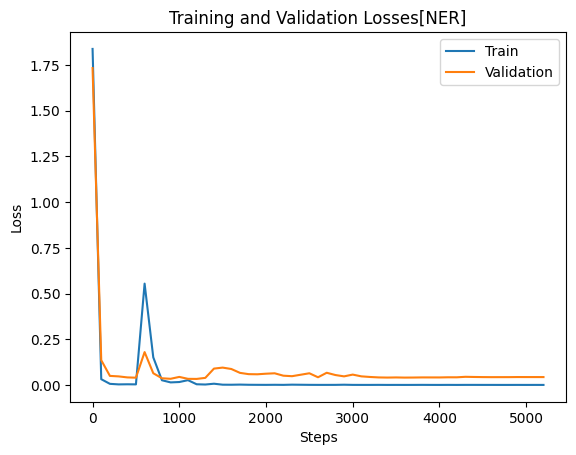

In [14]:
# plot the losses
import numpy as np

# Align losses
steps = [i*10 for i in range(len(aligned_loss_callback.train_losses))]
train_losses = np.array(aligned_loss_callback.train_losses)

eval_losses = np.array(aligned_loss_callback.eval_losses)
print(len(validation_steps), len(train_losses), len(eval_losses))

# Plot aligned losses
plt.plot(steps[::10], train_losses[::10], label='Train')
plt.plot(steps[::10], eval_losses[::10], label='Validation')

plt.title('Training and Validation Losses[NER]')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.savefig('./images/ner_losses.png')

In [15]:
# copy model to backend
import shutil

shutil.rmtree(target_dir, ignore_errors=True)
shutil.copytree('./ner_model', target_dir)

'../backend/chatbot/'

In [16]:
from transformers import BertTokenizerFast, BertForTokenClassification
import torch

# Load the saved model and tokenizer
# model_dir = "./ner_model"
# tokenizer = BertTokenizerFast.from_pretrained(model_dir)
# model = BertForTokenClassification.from_pretrained(model_dir)

# Load the label mappings
id_to_label = model.config.id2label

# Sample text to test the model
test_sentences = [
    "[INT] [BOT]  [USR] Order 121435, whats the status?"
]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def predict_ner(sentence):
    # Tokenize the sentence
    inputs = tokenizer(sentence, return_tensors="pt", truncation=True, padding=True, max_length=128).to(device)
    # print(inputs)

    # Get model predictions
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Extract logits and compute predictions
    logits = outputs.logits
    predictions = torch.argmax(logits, dim=2)

    # Map predictions to labels
    tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
    predicted_labels = [id_to_label[pred.item()] for pred in predictions[0]]

    # Combine tokens and predicted labels
    results = []
    for token, label in zip(tokens, predicted_labels):
        if token not in ["[CLS]", "[SEP]", "[PAD]"]:  # Ignore special tokens
            results.append((token, label))
    return results

# Test the model with sample sentences
for sentence in test_sentences:
    # print(f"Sentence: {sentence}")
    predictions = predict_ner(sentence)
    # print("Predictions:")
    # for token, label in predictions:
        # print(f"{token:15} -> {label}")
    # print("\n")

def extract_entity(sentence, entity_label):
    """
    enitity_label: the label of the entity to extract (ORD for example)
    extract the entity from the sentence along with I-ORD tokens
    """
    # Get NER predictions
    predictions = predict_ner(sentence)
    # for token, label in predictions:
    #     # print(f"{token:15} -> {label}")

    # get all entities in the label
    all_entities = []
    for token, label in predictions:
        if label.startswith("B-") or label.startswith("I-"):
            all_entities.append(label.split("-")[1])

    all_entities = list(set(all_entities))

    return_values = []
    for entity_label in all_entities:
        # Extract entities with the specified label
        entities = []
        for token, label in predictions:
            if label == f"B-{entity_label}" or label == f"I-{entity_label}":
                entities.append(token)
        # print(entities)
        
        # remove subword prefixes from the entities
        entity_combined = []
        prev_entity = None
        for i , entity in enumerate(entities):
            if entity.startswith("##"):
                if prev_entity is None:
                    prev_entity = ""
                prev_entity += entity[2:]
            else:
                if prev_entity:
                    entity_combined.append(prev_entity)
                prev_entity = entity

            if i == len(entities) - 1:
                entity_combined.append(prev_entity)
        return_values.append((entity_label, entity_combined))
    return return_values
        

# get the B-COUNT entity from the sentence
sentence = "[INT] [BOT]  [USR] Please show me a list of all the orders I've made before 21 November 2024 and after 10 April 2024"
entity_label = "START_DATE"
extracted_entity = extract_entity(sentence, entity_label)
print(f"Extracted entity: {extracted_entity}")

Extracted entity: [('END_DATE', ['21', 'november', '2024']), ('START_DATE', ['10', 'april', '202'])]


In [17]:
# test for 15 random samples
data = pd.read_csv('./data/ner_data.csv')

# draw 15 random samples
test_data = data.sample(15)

for idx, row in test_data.iterrows():
    print(f"Sentence: {row['instruction']}")
    # get the 
    extracted_entity = extract_entity(row['instruction'], "ORD")
    print(f"Extracted entity: {extracted_entity}")
    print("")

Sentence: [INT] [BOT]  [USR] Can you check my order 12345?
Extracted entity: [('ORD', ['12345'])]

Sentence: [INT] cancel_order [BOT] Please confirm the cancellation of your last order. [USR] Yes, confirm it.
Extracted entity: [('CONFIRMATION', ['yes'])]

Sentence: [INT] [BOT]  [USR] Cancel the last item I ordered.
Extracted entity: [('ORD', ['last'])]

Sentence: [INT] give_order_id [BOT] Are you sure? [USR] Yes I am sure!
Extracted entity: [('AFFIRMATION', ['yes'])]

Sentence: [INT] list_orders [BOT] Do you need to filter anything? [USR] Yeah give me just 32 of them
Extracted entity: [('COUNT', ['32'])]

Sentence: [INT] cancel_order [BOT] Can you confirm the cancellation of your most recent order? [USR] No, don’t proceed with it.
Extracted entity: [('AFFIRMATION', ['no'])]

Sentence: [INT] cancel_order [BOT] Are you sure you want to cancel order 112233? [USR] No, leave it as is.
Extracted entity: [('AFFIRMATION', ['no'])]

Sentence: [INT] [BOT]  [USR] Can you list some of my previous 